# Projet Long IATI - SIA : Etude de l'amélioration de la classification des peupleraies par Super Résolution
2024, ENSEEIHT, Toulouse INP
Mohamed Elkairouh - Auriane Bonnot - Maroua Agrouaz - Pierre Ribardière 

## SOMMAIRE

1. Preprocessing des données
    - a) Données d'entrainement
        - Tracé des Pi2 médians et des interquartiles des peupliers et non peupliers
        - PCA du trainset
        - Extraction des features sélectionnées par SFFS "recall"
        - PCA sur les données SFFS
    - b) Données de test
        - Tracé des Pi2 médians et des interquartiles des peupliers et non peupliers
        - SFFS "recall"
        - PCA du testset
        - PCA sur les données SFFS testset

2. Cross validation sans hyperparameter tuning (10fold)
    - a) Sur les données brutes (36 features)
    - b) Sur les données PCA (36 features)
    - c) Sur les données SFFS "recall" 
    - d) Sur les données PCA SFFS "recall"

3. RandomizedSearchCV: Hyperparameter Optimization
    - a) SFFS "recall"
    - b) SFFS "recall" PCA
    - c) SFFS "accuracy"

4. Données Super Résolues
    - a) Trainset
        - Pi2 médians et interquartiles
        - PCA 
    - b) Testset
        - PCA

5. Cross Validation (10fold)
    - a) Sur les données SR brutes (SFFS selected)
    - b) Sur les données SR PCA (SFFS selected)

6. Autres
    - a) Feature Importance
    - b) SFFS "accuracy" based
    - c) Classification multi-classes (7 classes)
    - d) Etude du meilleur nombre de composantes principales pour la PCA
    - e) Classification sur 2 tuiles de train et 1 tuile de test parmis le trainset initial

## 1) Pre processing des données

In [174]:
%pip install geopandas matplotlib numpy pandas scikit-learn seaborn torch torchvision

Note: you may need to restart the kernel to use updated packages.


In [1]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import geopandas as gpd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### a) Données d'entrainement

In [2]:
csv_file_path = 'data_30TYT_31TCJ_31UEQ.csv'
data = pd.read_csv(csv_file_path)

print("\nInformations sur les données :")
print(data.info())



Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123957 entries, 0 to 123956
Data columns (total 47 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         123957 non-null  object 
 1   CODE_TFV   123957 non-null  object 
 2   TFV        123957 non-null  object 
 3   TFV_G11    123957 non-null  object 
 4   ESSENCE    123957 non-null  object 
 5   ID_plot    123957 non-null  int64  
 6   Classe     123957 non-null  int64  
 7   Dep        123957 non-null  int64  
 8   layer      123957 non-null  object 
 9   path       123957 non-null  object 
 10  originfid  123957 non-null  int64  
 11  value_0    123957 non-null  float64
 12  value_1    123957 non-null  float64
 13  value_2    123957 non-null  float64
 14  value_3    123957 non-null  float64
 15  value_4    123957 non-null  float64
 16  value_5    123957 non-null  float64
 17  value_6    123957 non-null  float64
 18  value_7    123957 non-null  floa

In [3]:
#on regarde dans data le label "classe" de tous ceux qui ont value_0 = 0
print(data[data['value_0'] == 0]['Classe'].value_counts())

#on regarde dans data le label "layer" de tous ceux qui ont value_0 = 0
print("\n", data[data['value_0'] == 0]['layer'].value_counts())

Classe
4    1545
3     719
6     617
2     588
5     487
1       3
8       1
Name: count, dtype: int64

 layer
GroundTruth_30TYT_2154    3936
GroundTruth_31UEQ_2154      15
GroundTruth_31TCJ_2154       9
Name: count, dtype: int64


Remarque : On remarque que 3949 pixels ont des valeurs des features qui sont nuls. Or on retrouve ***de toutes les classes dans ce lot, et de toutes les tuiles.*** 
Pour le moment, on ne sait pas à quoi est dû cette erreur à part le fait que les valeurs de ground truth n'auraient pas été situées sur l'emprise des tuiles. Or, un traitement des valeurs de vérité de terrain a été effectué en amont pour ne garder justement que les valeurs comprises dans l'emprise des tuiles.

Néanmoins, pour ne pas dégrader la performance du modèle, on va supprimer ces échantillons. 

In [4]:
data.drop(data[data['value_0']==0].index, inplace=True)

In [5]:
#on range tous les non peupliers en une seule classe
#toutes les classes différentes de 1 deviennent égales à 0

data['Classe'] = data['Classe'].apply(lambda x: 0 if x != 1 else x)

In [6]:
# on rééquilibre les classes avec classe 1 qui garde tous ses échantillons et les autres classes qui en perdent, on undersample aléatoirement
data = data.groupby('Classe').apply(lambda x: x.sample(n=data['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\264404851.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Classe').apply(lambda x: x.sample(n=data['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


In [7]:
data.value_counts('Classe') 

Classe
0    19309
1    19309
Name: count, dtype: int64

In [8]:
#on remplace les features value_0 à value_35 par les dates correspondantes
dates = ['06/01', '16/01', '26/01', '05/02', '15/02', '25/02', '07/03', '17/03', '27/03', '06/04', '16/04', '26/04', '06/05', '16/05', '26/05', '05/06', '15/06', '25/06', '05/07', '15/07', '25/07', '04/08', '14/08', '24/08', '03/09', '13/09', '23/09', '03/10', '13/10', '23/10', '02/11', '12/11', '22/11', '02/12', '12/12', '22/12']
for i in range(36):
    data = data.rename(columns={f'value_{i}': dates[i]})

data

ID   CODE_TFV  \
0      FORESTIE0000000008206854  FF1-00-00   
1      FORESTIE0000000003705963  FF1G01-01   
2      FORESTIE0000000003706909  FF1-10-10   
3      FORESTIE0000000003708333  FF1-00-00   
4      FORESTIE0000000005111008        FO1   
...                         ...        ...   
38613                   PI_2_68         FP   
38614                  PI_49_21         FP   
38615                  PI_37_67         FP   
38616                   PI_49_6         FP   
38617                   PI_2_13         FP   

                                       TFV                 TFV_G11  \
0       For?t ferm?e ? m?lange de feuillus   For?t ferm?e feuillus   
1      Forêt fermée de chênes décidus purs   Forêt fermée feuillus   
2          Forêt fermée de châtaignier pur   Forêt fermée feuillus   
3       Forêt fermée à mélange de feuillus   Forêt fermée feuillus   
4           Forêt ouverte de feuillus purs  Forêt ouverte feuillus   
...                                    ...                     ...   
38613                           Peupleraie              Peupleraie   
38614                           Peupleraie              Peupleraie   
38615                           Peupleraie              Peupleraie   
38616                           Peupleraie              Peupleraie   
38617                           Peupleraie              Peupleraie   

              ESSENCE  ID_plot  Classe  Dep                   layer  \
0            Feuillus      902       0   82  GroundTruth_31TCJ_2154   
1      Chênes décidus     1205       0   37  GroundTruth_30TYT_2154   
2         Châtaignier     1034       0   37  GroundTruth_30TYT_2154   
3            Feuillus     1384       0   37  GroundTruth_30TYT_2154   
4            Feuillus      593       0   51  GroundTruth_31UEQ_2154   
...               ...      ...     ...  ...                     ...   
38613        Peuplier       68       1    2  GroundTruth_31UEQ_2154   
38614        Peuplier       21       1   49  GroundTruth_30TYT_2154   
38615        Peuplier       67       1   37  GroundTruth_30TYT_2154   
38616        Peuplier        6       1   49  GroundTruth_30TYT_2154   
38617        Peuplier       13       1    2  GroundTruth_31UEQ_2154   

                                                    path  ...   23/09   03/10  \
0      /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1358.0 -1248.0   
1      /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1718.0 -1818.0   
2      /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1547.0 -1599.0   
3      /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1892.0 -1958.0   
4      /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ...  -745.0  -668.0   
...                                                  ...  ...     ...     ...   
38613  /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1518.0 -1263.0   
38614  /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1060.0 -1217.0   
38615  /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1300.0 -1535.0   
38616  /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -2180.0 -2209.0   
38617  /home/yhamrouni/Documents/IOTA2_TEST_S2/Create...  ... -1329.0 -1522.0   

        13/10   23/10   02/11   12/11   22/11   02/12   12/12   22/12  
0     -1228.0 -1210.0 -1146.0 -1082.0 -1196.0 -1196.0 -1196.0 -1196.0  
1     -1761.0 -1745.0 -1812.0 -1880.0 -2085.0 -2349.0 -2741.0 -2046.0  
2     -1684.0 -1726.0 -1584.0 -1443.0 -1425.0 -1460.0 -1447.0 -1240.0  
3     -1817.0 -1667.0 -1533.0 -1731.0 -1930.0 -2129.0 -2288.0 -2288.0  
4      -604.0  -361.0  -390.0  -342.0  -118.0  -118.0  -118.0  -118.0  
...       ...     ...     ...     ...     ...     ...     ...     ...  
38613 -1645.0 -1838.0 -1648.0 -1845.0 -2473.0 -2473.0 -2473.0 -2473.0  
38614 -1434.0 -1695.0 -1673.0 -1650.0 -1847.0 -2138.0 -2203.0 -1570.0  
38615 -1842.0 -1909.0 -1440.0 -1783.0 -1923.0 -2227.0 -2348.0 -1733.0  
38616 -2154.0 -2055.0 -1778.0 -1502.0 -1374.0 -1310.0 -1237.0 -1151.0  
38617 -1907.0 -16

In [9]:
#shuffle des données
data = data.sample(frac=1, random_state=7).reset_index(drop=True)

#Split en Features et Label
X = data.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid']) 
y = data['Classe']

# X = X.values
# y = y.values


In [10]:
X

06/01   16/01   26/01   05/02   15/02   25/02   07/03   17/03   27/03  \
0     -1794.0 -1884.0 -1044.0   218.0    26.0  -788.0 -1321.0 -1732.0 -1681.0   
1     -1754.0 -1784.0 -1783.0 -1782.0 -1782.0 -1781.0 -1781.0 -1781.0 -1611.0   
2     -1064.0 -1134.0 -1205.0  -243.0  -678.0 -1714.0 -1681.0 -1649.0 -1490.0   
3     -1704.0 -1707.0 -1710.0 -1713.0 -1969.0 -2476.0 -2556.0 -2608.0 -2361.0   
4       217.0   511.0   804.0  1097.0    67.0 -1669.0 -1808.0 -1947.0 -2072.0   
...       ...     ...     ...     ...     ...     ...     ...     ...     ...   
38613 -2438.0 -2361.0 -2285.0 -2207.0 -2325.0 -2634.0 -2787.0 -2780.0 -2519.0   
38614 -1175.0 -1168.0 -1144.0  -846.0 -1179.0 -2140.0 -2102.0 -2066.0 -2138.0   
38615 -1440.0 -1438.0  -907.0   740.0 -1313.0 -1784.0 -1700.0 -1612.0 -1619.0   
38616 -1217.0 -1352.0 -1162.0   397.0  -314.0 -1999.0 -1918.0 -1837.0 -1695.0   
38617 -2554.0 -2027.0   475.0  2728.0  2912.0  2207.0  1503.0   799.0    94.0   

        06/04  ...   23/09   03/10   13/10   23/10   02/11   12/11   22/11  \
0     -1434.0  ... -1214.0 -1217.0 -1209.0 -1232.0 -1381.0 -1529.0 -1677.0   
1     -1369.0  ...  -951.0  -969.0  -961.0  -995.0 -1197.0 -1399.0 -1535.0   
2     -1276.0  ...  -594.0  -486.0  -453.0  -471.0  -344.0  -463.0  -583.0   
3     -1811.0  ...  -948.0  -915.0 -1035.0  -314.0  -800.0 -1287.0 -1747.0   
4     -2163.0  ...  -880.0  -790.0  -841.0  -780.0  -910.0 -1161.0  -760.0   
...       ...  ...     ...     ...     ...     ...     ...     ...     ...   
38613 -2000.0  ... -2116.0 -2077.0 -2499.0 -2285.0 -2166.0 -2046.0 -2246.0   
38614 -2259.0  ... -1592.0 -1663.0 -1740.0 -2022.0 -1706.0 -1390.0 -1315.0   
38615 -1666.0  ... -1419.0 -1485.0 -1524.0 -1538.0 -1079.0 -1115.0 -1210.0   
38616 -1526.0  ... -1084.0 -1642.0 -1977.0 -1911.0 -1565.0 -1949.0 -1739.0   
38617  -608.0  ... -2759.0 -2659.0 -2324.0 -2015.0 -1811.0 -1607.0 -1476.0   

        02/12   12/12   22/12  
0     -1826.0 -1872.0 -1542.0  
1     -1642.0 -1674.0 -1502.0  
2      -703.0  -725.0  -651.0  
3     -1863.0 -1544.0 -1502.0  
4      -557.0  -354.0  -354.0  
...       ...     ...     ...  
38613 -2504.0 -2634.0 -2634.0  
38614 -1342.0 -1284.0 -1102.0  
38615 -1333.0 -1349.0 -1382.0  
38616 -2105.0 -2347.0 -1945.0  
38617 -1374.0 -1293.0 -1282.0  

[38618 rows x 36 columns]

In [11]:
y.unique()

array([1, 0], dtype=int64)

### Tracé des Pi2 médians et des interquartiles des peupliers et non peupliers

<Figure size 640x480 with 0 Axes>

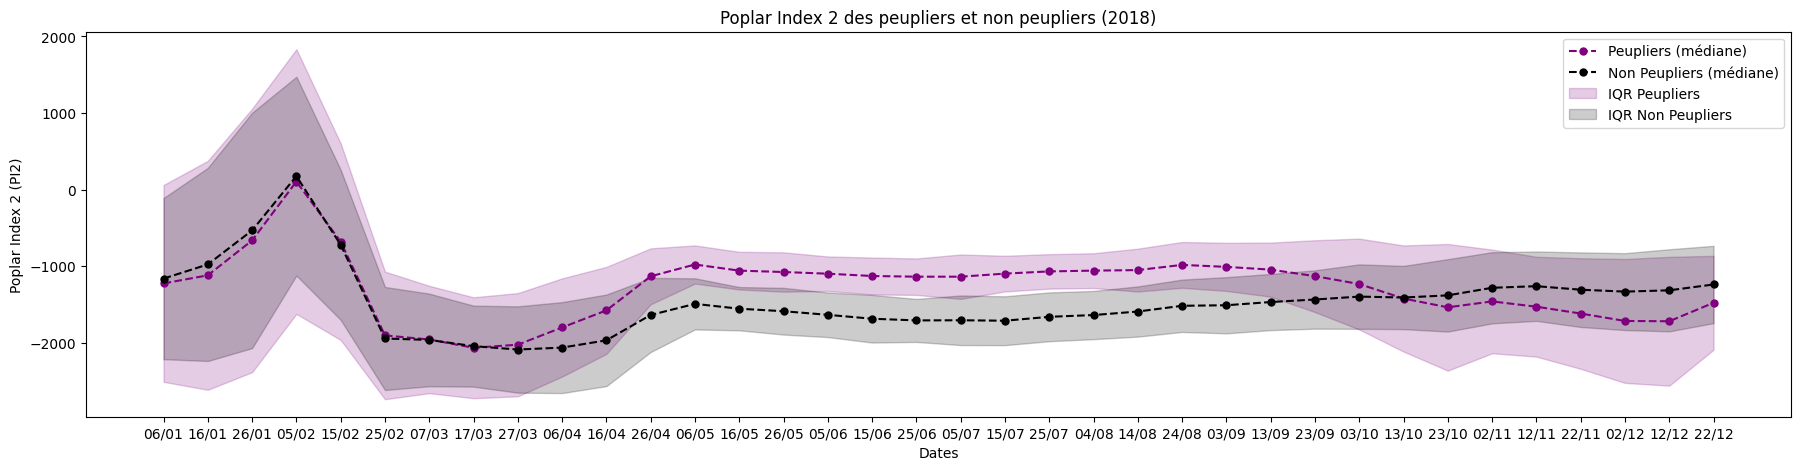

<Figure size 640x480 with 0 Axes>

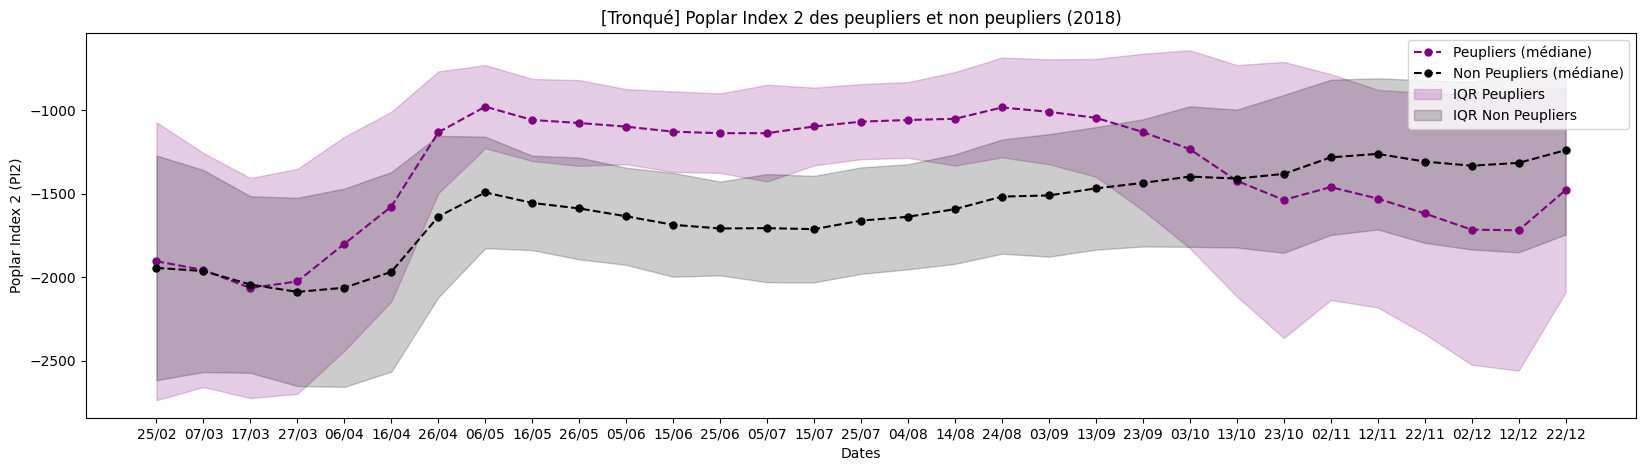

<Figure size 640x480 with 0 Axes>

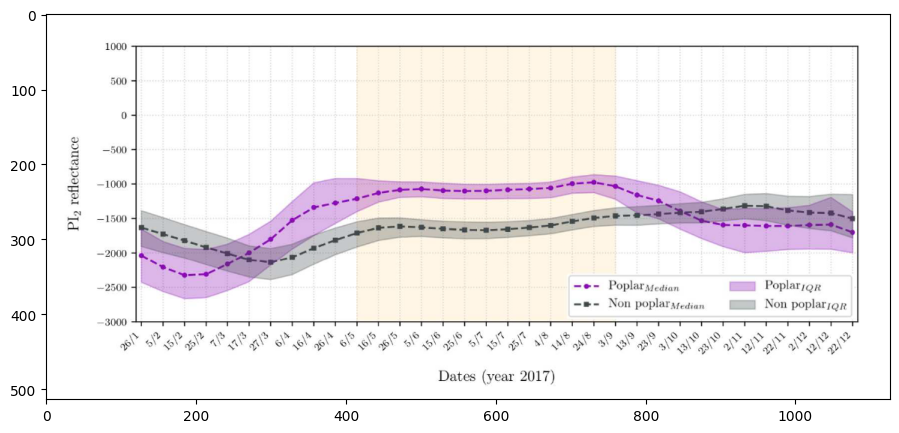

In [12]:
#on va tracer la médiane des peupliers et des non peupliers ainsi que l'interquartile
peupliers = data[data['Classe'] == 1]
peupliers = peupliers.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])
non_peupliers = data[data['Classe'] == 0]
non_peupliers = non_peupliers.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

peupliers_median = peupliers.median()
non_peupliers_median = non_peupliers.median()

peupliers_iqr = peupliers.quantile(0.75) - peupliers.quantile(0.25)
non_peupliers_iqr = non_peupliers.quantile(0.75) - non_peupliers.quantile(0.25)

dates = ['06/01', '16/01', '26/01', '05/02', '15/02', '25/02', '07/03', '17/03', '27/03', '06/04', '16/04', '26/04', '06/05', '16/05', '26/05', '05/06', '15/06', '25/06', '05/07', '15/07', '25/07', '04/08', '14/08', '24/08', '03/09', '13/09', '23/09', '03/10', '13/10', '23/10', '02/11', '12/11', '22/11', '02/12', '12/12', '22/12']
#on tracer sur une même figure les interquartiles et les médianes
plt.figure(1)
plt.figure(figsize=(22, 5))
plt.plot(dates,peupliers_median, label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates, non_peupliers_median, label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates, peupliers_median - peupliers_iqr, peupliers_median + peupliers_iqr, color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates, non_peupliers_median - non_peupliers_iqr, non_peupliers_median + non_peupliers_iqr, color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018)')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()

#On retire le début pour comparer à la courbe de la diapo 
plt.figure(2)
plt.figure(figsize=(20, 5))
plt.plot(dates[5:],peupliers_median[5:], label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates[5:], non_peupliers_median[5:], label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates[5:], peupliers_median[5:] - peupliers_iqr[5:], peupliers_median[5:] + peupliers_iqr[5:], color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates[5:], non_peupliers_median[5:] - non_peupliers_iqr[5:], non_peupliers_median[5:] + non_peupliers_iqr[5:], color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('[Tronqué] Poplar Index 2 des peupliers et non peupliers (2018)')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()

#Affichage de la courbe de la diapo de 2017
plt.figure(3)
plt.figure(figsize=(20, 5))
img = plt.imread('Pi2_2017.png')
plt.imshow(img)
plt.show()




In [13]:
peupliers.describe()

06/01         16/01         26/01         05/02         15/02  \
count  19309.000000  19309.000000  19309.000000  19309.000000  19309.000000   
mean    -962.601067   -719.102646   -382.267336    129.864519   -766.407478   
std     1182.412036   1400.873111   1409.774461   1458.340755    960.459490   
min    -5305.000000  -4147.000000  -4151.000000  -4496.000000  -4109.000000   
25%    -1760.000000  -1680.000000  -1395.000000   -677.000000  -1459.000000   
50%    -1225.000000  -1119.000000   -664.000000    105.000000   -680.000000   
75%     -475.000000   -185.000000    325.000000   1051.000000   -176.000000   
max     2556.000000   3670.000000   4133.000000   5700.000000   2558.000000   

              25/02         07/03         17/03         27/03         06/04  \
count  19309.000000  19309.000000  19309.000000  19309.000000  19309.000000   
mean   -1770.481900  -1896.476462  -2043.718163  -2016.872288  -1873.300533   
std      722.664401    621.564574    594.187622    540.547811    480.458000   
min    -4209.000000  -4419.000000  -4629.000000  -4554.000000  -4544.000000   
25%    -2220.000000  -2288.000000  -2411.000000  -2354.000000  -2175.000000   
50%    -1904.000000  -1957.000000  -2065.000000  -2025.000000  -1800.000000   
75%    -1387.000000  -1587.000000  -1752.000000  -1680.000000  -1534.000000   
max     1232.000000   2911.000000   -134.000000   -127.000000    -78.000000   

       ...         23/09         03/10         13/10         23/10  \
count  ...  19309.000000  19309.000000  19309.000000  19309.000000   
mean   ...  -1248.610855  -1338.103371  -1510.286913  -1594.860894   
std    ...    460.507631    499.084120    538.407174    617.950828   
min    ...  -4502.000000  -4702.000000  -4029.000000  -4244.000000   
25%    ...  -1411.000000  -1581.000000  -1819.000000  -1984.000000   
50%    ...  -1130.000000  -1233.000000  -1422.000000  -1537.000000   
75%    ...   -942.000000   -988.000000  -1126.000000  -1157.000000   
max    ...   -165.000000   -224.000000   -398.000000   -122.000000   

             02/11         12/11         22/11         02/12         12/12  \
count  19309.00000  19309.000000  19309.000000  19309.000000  19309.000000   
mean   -1505.18235  -1579.147082  -1658.605831  -1709.554664  -1700.999896   
std      542.43771    512.441062    541.919713    598.411837    657.701859   
min    -4065.00000  -3903.000000  -3934.000000  -4062.000000  -5272.000000   
25%    -1827.00000  -1873.000000  -1985.000000  -2094.000000  -2105.000000   
50%    -1460.00000  -1529.000000  -1618.000000  -1715.000000  -1719.000000   
75%    -1150.00000  -1221.000000  -1263.000000  -1285.000000  -1264.000000   
max      -38.00000    158.000000    111.000000    111.000000    111.000000   

              22/12  
count  19309.000000  
mean   -1480.178207  
std      529.780241  
min    -6083.000000  
25%    -1781.000000  
50%    -1478.000000  
75%    -1168.000000  
max      111.000000  

[8 rows x 36 columns]

<Figure size 640x480 with 0 Axes>

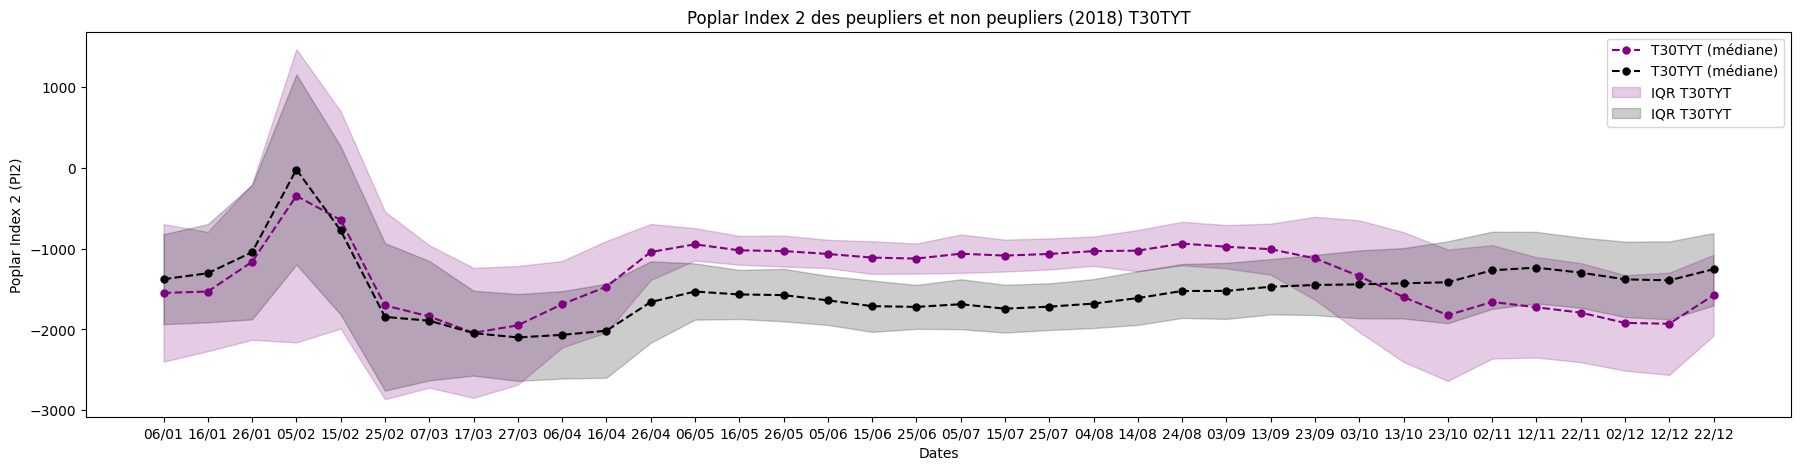

<Figure size 640x480 with 0 Axes>

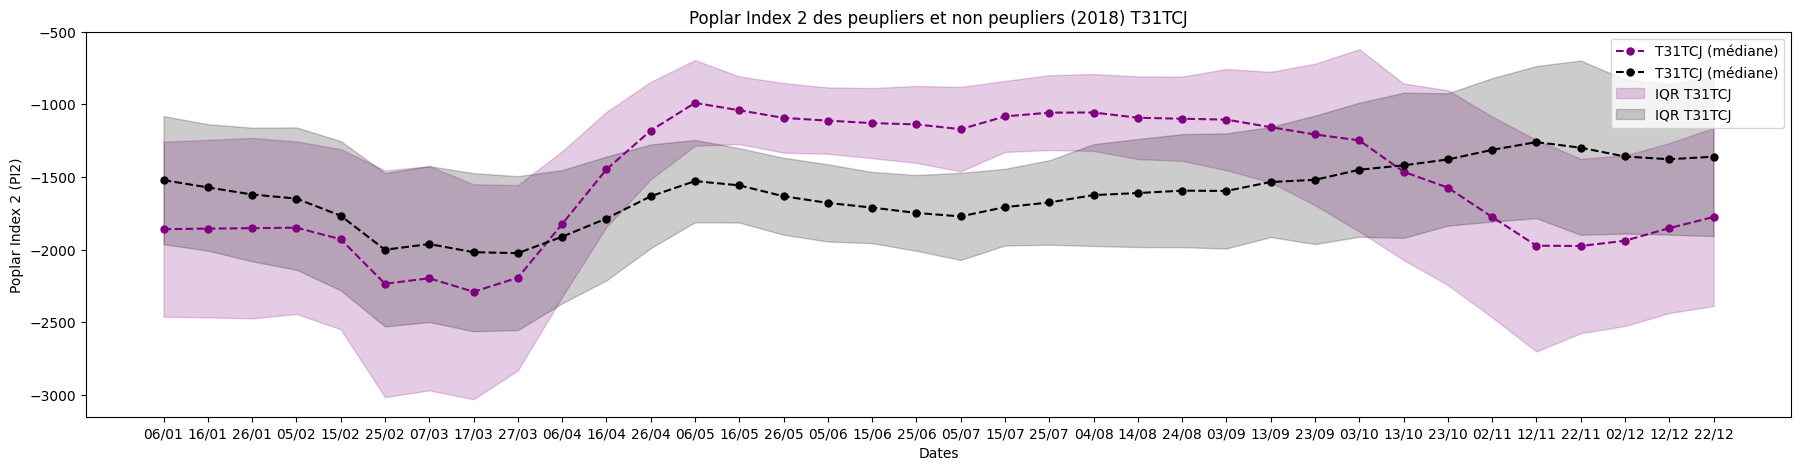

<Figure size 640x480 with 0 Axes>

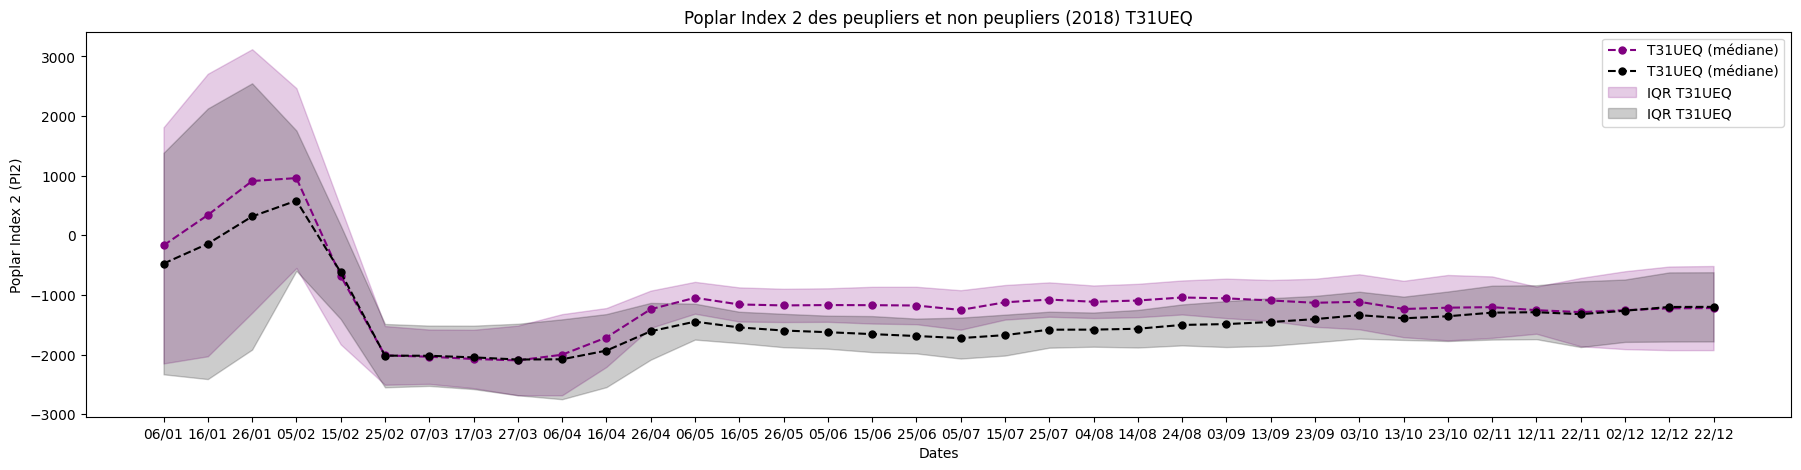

In [14]:
# Plot par tuiles
T30TYT = data[data['layer'] == 'GroundTruth_30TYT_2154']
T31TCJ = data[data['layer'] == 'GroundTruth_31TCJ_2154']
T31UEQ = data[data['layer'] == 'GroundTruth_31UEQ_2154']

#T30TYT
peupliers_T30TYT = T30TYT[T30TYT['Classe'] == 1]
peupliers_T30TYT = peupliers_T30TYT.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])
non_peupliers_T30TYT = T30TYT[T30TYT['Classe'] == 0]
non_peupliers_T30TYT = non_peupliers_T30TYT.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

peupliers_median_T30TYT = peupliers_T30TYT.median()
non_peupliers_median_T30TYT = non_peupliers_T30TYT.median()

peupliers_iqr_T30TYT = peupliers_T30TYT.quantile(0.75) - peupliers_T30TYT.quantile(0.25)
non_peupliers_iqr_T30TYT = non_peupliers_T30TYT.quantile(0.75) - non_peupliers_T30TYT.quantile(0.25)

#T31TCJ
peupliers_T31TCJ = T31TCJ[T31TCJ['Classe'] == 1]
peupliers_T31TCJ = peupliers_T31TCJ.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])
non_peupliers_T31TCJ = T31TCJ[T31TCJ['Classe'] == 0]
non_peupliers_T31TCJ = non_peupliers_T31TCJ.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

peupliers_median_T31TCJ = peupliers_T31TCJ.median()
non_peupliers_median_T31TCJ = non_peupliers_T31TCJ.median()

peupliers_iqr_T31TCJ = peupliers_T31TCJ.quantile(0.75) - peupliers_T31TCJ.quantile(0.25)
non_peupliers_iqr_T31TCJ = non_peupliers_T31TCJ.quantile(0.75) - non_peupliers_T31TCJ.quantile(0.25)

#T31UEQ
peupliers_T31UEQ = T31UEQ[T31UEQ['Classe'] == 1]
peupliers_T31UEQ = peupliers_T31UEQ.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])
non_peupliers_T31UEQ = T31UEQ[T31UEQ['Classe'] == 0]
non_peupliers_T31UEQ = non_peupliers_T31UEQ.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

peupliers_median_T31UEQ = peupliers_T31UEQ.median()
non_peupliers_median_T31UEQ = non_peupliers_T31UEQ.median()

peupliers_iqr_T31UEQ = peupliers_T31UEQ.quantile(0.75) - peupliers_T31UEQ.quantile(0.25)
non_peupliers_iqr_T31UEQ = non_peupliers_T31UEQ.quantile(0.75) - non_peupliers_T31UEQ.quantile(0.25)

plt.figure(4)
plt.figure(figsize=(22, 5))
plt.plot(dates,peupliers_median_T30TYT, label='T30TYT (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates, non_peupliers_median_T30TYT, label='T30TYT (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates, peupliers_median_T30TYT - peupliers_iqr_T30TYT, peupliers_median_T30TYT + peupliers_iqr_T30TYT, color='purple', alpha=0.2, label='IQR T30TYT')
plt.fill_between(dates, non_peupliers_median_T30TYT - non_peupliers_iqr_T30TYT, non_peupliers_median_T30TYT + non_peupliers_iqr_T30TYT, color='black', alpha=0.2, label='IQR T30TYT')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) T30TYT')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()

plt.figure(5)
plt.figure(figsize=(22, 5))
plt.plot(dates,peupliers_median_T31TCJ, label='T31TCJ (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates, non_peupliers_median_T31TCJ, label='T31TCJ (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates, peupliers_median_T31TCJ - peupliers_iqr_T31TCJ, peupliers_median_T31TCJ + peupliers_iqr_T31TCJ, color='purple', alpha=0.2, label='IQR T31TCJ')
plt.fill_between(dates, non_peupliers_median_T31TCJ - non_peupliers_iqr_T31TCJ, non_peupliers_median_T31TCJ + non_peupliers_iqr_T31TCJ, color='black', alpha=0.2, label='IQR T31TCJ')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) T31TCJ')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()

plt.figure(6)
plt.figure(figsize=(22, 5))
plt.plot(dates,peupliers_median_T31UEQ, label='T31UEQ (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates, non_peupliers_median_T31UEQ, label='T31UEQ (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates, peupliers_median_T31UEQ - peupliers_iqr_T31UEQ, peupliers_median_T31UEQ + peupliers_iqr_T31UEQ, color='purple', alpha=0.2, label='IQR T31UEQ')
plt.fill_between(dates, non_peupliers_median_T31UEQ - non_peupliers_iqr_T31UEQ, non_peupliers_median_T31UEQ + non_peupliers_iqr_T31UEQ, color='black', alpha=0.2, label='IQR T31UEQ')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) T31UEQ')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()



### PCA du trainset

On remarque que certaines features ont plus d'importance que d'autres donc on réduit le nombre de features aux premières composantes principales. 

De plus, cela accélère l'entrainement car il y a moins de données.

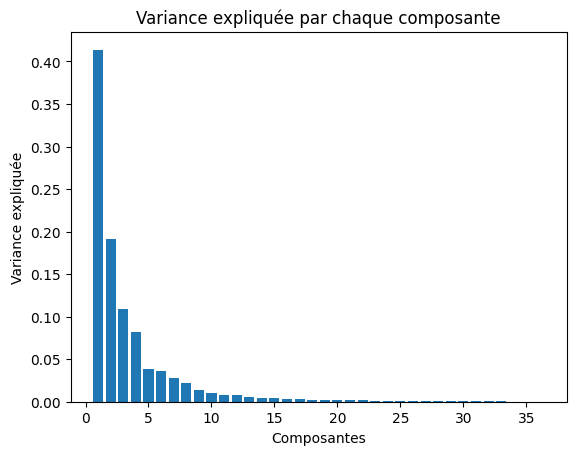

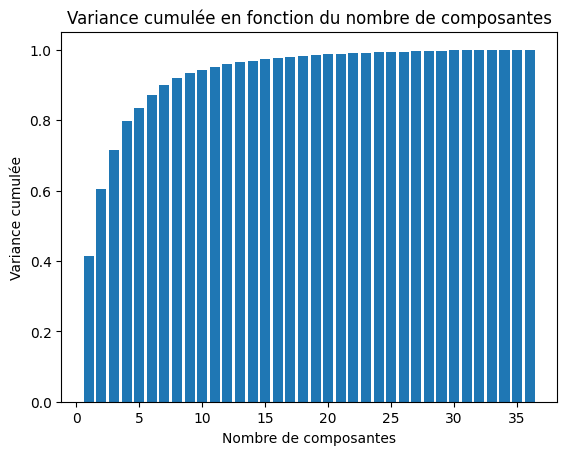

<Figure size 640x480 with 0 Axes>

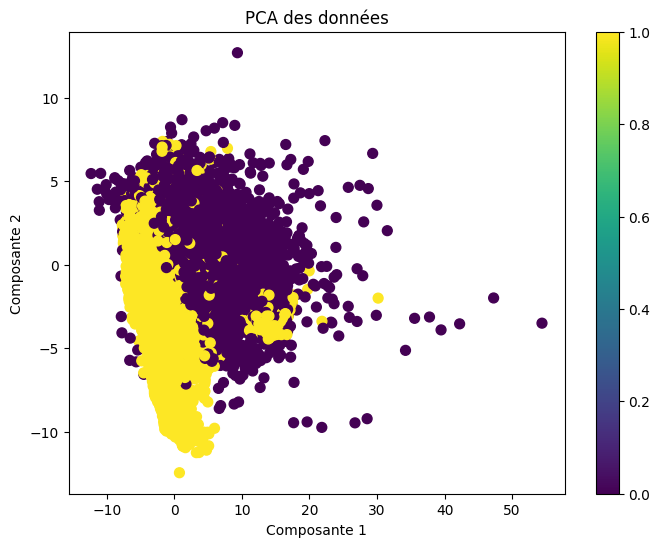

In [15]:
#PCA sur les données pour visualiser les composantes les plus importantes puis pour l'entrainement
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#on regarde la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
explained_variance

#on regarde la variance cumulée
cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

#on trace la variance expliquée par chaque composante en barres
plt.figure(9)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

#on trace la variance cumulée en barres
plt.figure(10)
plt.bar(range(1, len(cum_explained_variance)+1), cum_explained_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Variance cumulée en fonction du nombre de composantes')
plt.show()

#on va tracer les deux premières composantes principales
plt.figure(11)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

#on va créer X_PCA qui contient les 5 premières composantes principales
X_pca = X_pca[:, :3]


### Extraction des features sélectionnées par SFFS "recall"

Ici, on garde les features qui ont été choisies au préalable par Mme Hamrouni à l'aide de la méthode SFFS basé sur le recall. Deux choses à préciser :

1. L'application de la super résolution étant très coûteuse en calculs, seules 5 bandes spectrales (dates) ont été super résolues sur cette série. C'est pour cette raison qu'on garde ces features sur les données sans SR.

2. Ces 5 features sont les suivantes : 05/06, 23/10, 25/07, 24/08 et 16/04

In [16]:
#on extrait les colonnes 05/06, 23/10, 25/07, 24/08 et 16/04 pour les garder en features
X_SFFS = X[['05/06', '23/10', '25/07', '24/08', '16/04']] 

X_SFFS

05/06   23/10   25/07   24/08   16/04
0     -1022.0 -1232.0  -992.0 -1235.0 -1185.0
1      -872.0  -995.0  -923.0  -848.0 -1128.0
2      -983.0  -471.0  -926.0  -763.0 -1062.0
3     -1075.0  -314.0  -963.0  -907.0 -1262.0
4      -998.0  -780.0  -874.0 -1034.0 -1395.0
...       ...     ...     ...     ...     ...
38613 -1285.0 -2285.0 -1147.0 -1859.0 -1481.0
38614 -1575.0 -2022.0 -1848.0 -1633.0 -2380.0
38615 -1934.0 -1538.0 -1739.0 -1504.0 -1714.0
38616 -1214.0 -1911.0 -1248.0 -1383.0 -1357.0
38617 -1677.0 -2015.0 -2764.0 -2729.0 -1313.0

[38618 rows x 5 columns]

<Figure size 640x480 with 0 Axes>

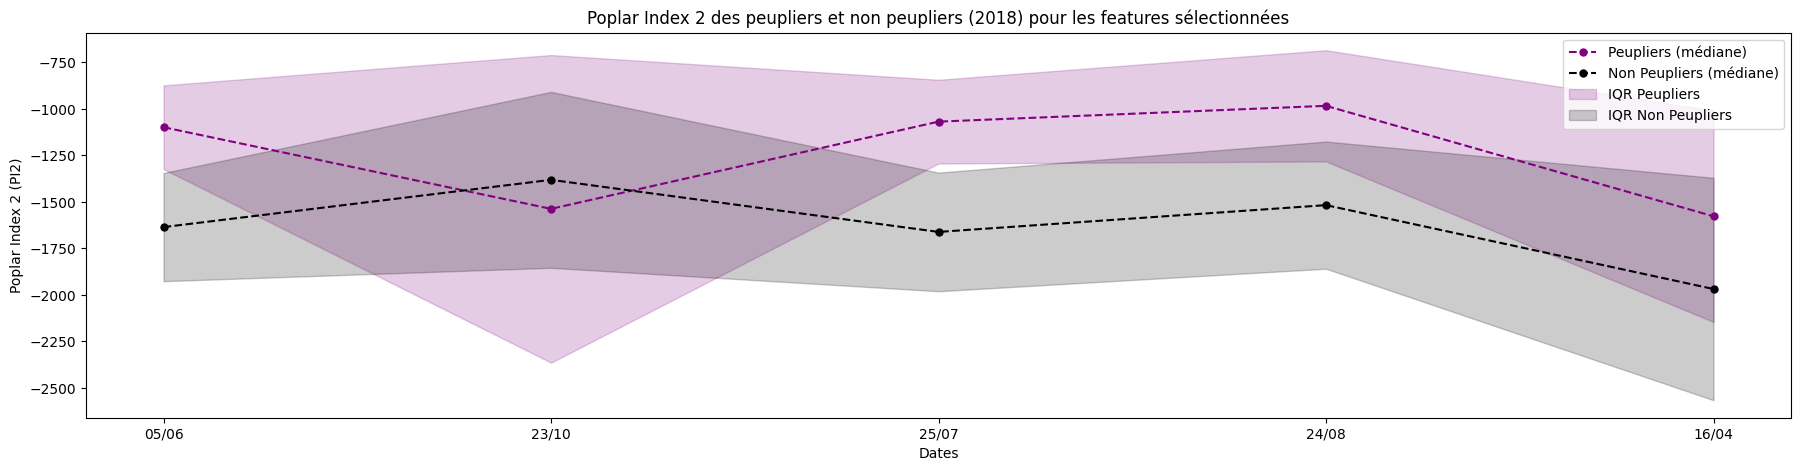

In [17]:
#Tracé du pi2 médian et de l'interquartile pour les features sélectionnées
peupliers_SFFS = X_SFFS[y == 1]
non_peupliers_SFFS = X_SFFS[y == 0]

peupliers_SFFS = pd.DataFrame(peupliers_SFFS)
non_peupliers_SFFS = pd.DataFrame(non_peupliers_SFFS)

peupliers_median_SFFS = peupliers_SFFS.median()
non_peupliers_median_SFFS = non_peupliers_SFFS.median()

peupliers_iqr_SFFS = peupliers_SFFS.quantile(0.75) - peupliers_SFFS.quantile(0.25)
non_peupliers_iqr_SFFS = non_peupliers_SFFS.quantile(0.75) - non_peupliers_SFFS.quantile(0.25)

dates_SFFS = ['05/06', '23/10', '25/07', '24/08', '16/04']
plt.figure(12)
plt.figure(figsize=(22, 5))
plt.plot(dates_SFFS,peupliers_median_SFFS, label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates_SFFS, non_peupliers_median_SFFS, label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates_SFFS, peupliers_median_SFFS - peupliers_iqr_SFFS, peupliers_median_SFFS + peupliers_iqr_SFFS, color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates_SFFS, non_peupliers_median_SFFS - non_peupliers_iqr_SFFS, non_peupliers_median_SFFS + non_peupliers_iqr_SFFS, color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) pour les features sélectionnées')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()



### PCA sur les features SFFS

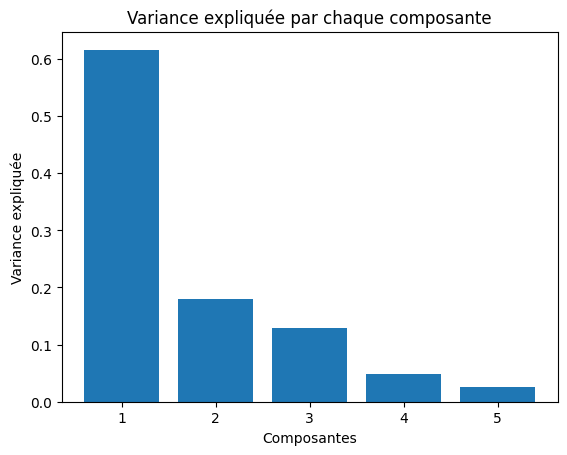

<Figure size 640x480 with 0 Axes>

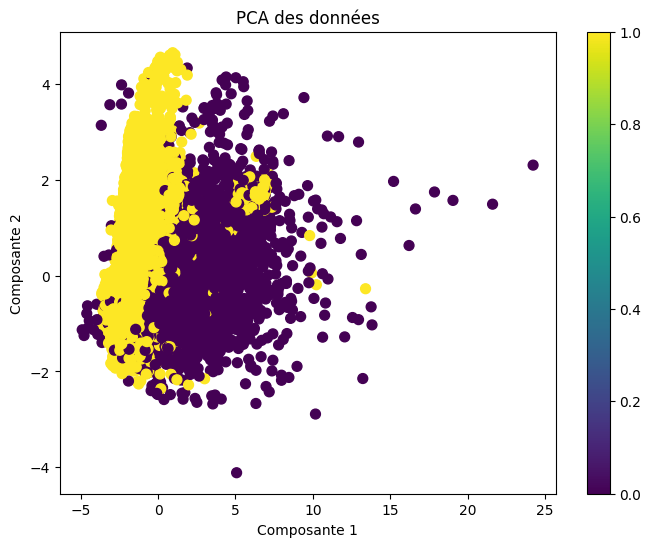

In [18]:
#pca
scaler = StandardScaler()
X_sffs_scaled = scaler.fit_transform(X_SFFS)

pca = PCA()
X_sffs_pca = pca.fit_transform(X_sffs_scaled)

#on regarde la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
explained_variance

#on regarde la variance cumulée
cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

#on trace la variance expliquée par chaque composante en barres
plt.figure(12)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

#on trace les deux premières composantes principales
plt.figure(13)
plt.figure(figsize=(8, 6))
plt.scatter(X_sffs_pca[:, 0], X_sffs_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

#on va créer X_SFFS_PCA qui contient les 2 premières composantes principales
X_sffs_pca = X_sffs_pca[:, :5]


### b) Données de Test

In [19]:
csv_file_path = 'data_30TYQ_peupliers.csv'
csv_file_path_peup_aug = 'data_30TYQ_peupliers_AUG.csv'
csv_file_path_non_peupliers = "data_30TYQ_non_peupliers.csv"

peupliers = pd.read_csv(csv_file_path)
peupliers_aug = pd.read_csv(csv_file_path_peup_aug)

peupliers = pd.concat([peupliers, peupliers_aug], ignore_index=True)

#ajouter la colonne "Classe" dans data_test et donner la valeur 1 à tous les échantillons
peupliers['Classe'] = pd.DataFrame(np.ones(peupliers.shape[0]), columns=['Classe'])

data_test_non_peupliers = pd.read_csv(csv_file_path_non_peupliers)

#Fusionner les deux dataframes
data_test = pd.concat([peupliers, data_test_non_peupliers], ignore_index=True)

#shuffle
data_test = data_test.sample(frac=1, random_state=7).reset_index(drop=True)

#enregistrer le dataframe
data_test.to_csv('test_set_tuile_4_GT.csv', index=False)

print("\nInformations sur les données :")
print(data_test.info())

#on retire les échantillons avec features nuls
data_test.drop(data_test[data_test['value_0']==0].index, inplace=True) 

for i in range(36):
    data_test = data_test.rename(columns={f'value_{i}': dates[i]})

print(data_test.value_counts('Classe'))

#on range tous les non peupliers en une seule classe
#toutes les classes différentes de 1 deviennent égales à 0
data_test['Classe'] = data_test['Classe'].apply(lambda x: 0 if x != 1 else x)

#on rééquilibre les classes 
data_test = data_test.groupby('Classe').apply(lambda x: x.sample(n=data_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)

data_test = data_test.sample(frac=1, random_state=7).reset_index(drop=True)

print(data_test.value_counts('Classe'))


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54348 entries, 0 to 54347
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Annee_pl   17451 non-null  float64
 1   Cultivars  17451 non-null  object 
 2   value_0    54348 non-null  float64
 3   value_1    54348 non-null  float64
 4   value_2    54348 non-null  float64
 5   value_3    54348 non-null  float64
 6   value_4    54348 non-null  float64
 7   value_5    54348 non-null  float64
 8   value_6    54348 non-null  float64
 9   value_7    54348 non-null  float64
 10  value_8    54348 non-null  float64
 11  value_9    54348 non-null  float64
 12  value_10   54348 non-null  float64
 13  value_11   54348 non-null  float64
 14  value_12   54348 non-null  float64
 15  value_13   54348 non-null  float64
 16  value_14   54348 non-null  float64
 17  value_15   54348 non-null  float64
 18  value_16   54348 non-null  float64
 19  value_17   543

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\3688725934.py:40: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_test = data_test.groupby('Classe').apply(lambda x: x.sample(n=data_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


### Distribution de l'age des peupliers

In [20]:
data_test['age'] = data_test['Annee_pl'].apply(lambda x: 2018 - x)


<Figure size 640x480 with 0 Axes>

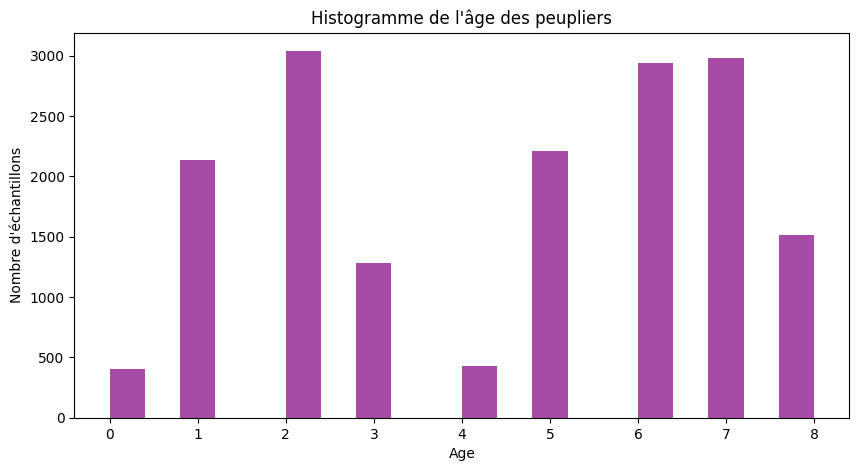

In [21]:
plt.figure(14)
plt.figure(figsize=(10, 5))
plt.hist(data_test['age'], bins=20, color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Nombre d\'échantillons')
plt.title('Histogramme de l\'âge des peupliers')
plt.show()

In [22]:
#On split en features et label
X_test = data_test.drop(columns=['Annee_pl', 'Cultivars', 'age', 'Classe', 'id', 'originfid'])
y_test = data_test['Classe']

X_test.head()

06/01   16/01   26/01   05/02   15/02   25/02   07/03   17/03   27/03  \
0 -1382.0 -1270.0  -888.0 -1383.0 -1718.0 -1895.0 -2071.0 -2315.0 -2264.0   
1 -2158.0 -2008.0 -1858.0 -1707.0 -1664.0 -1726.0 -1843.0 -1961.0 -1940.0   
2 -1474.0 -1231.0 -1929.0 -1813.0 -1952.0 -2348.0 -2205.0 -2468.0 -2197.0   
3 -2281.0 -2286.0 -2290.0 -2294.0 -2342.0 -2434.0 -2528.0 -2620.0 -2553.0   
4 -1816.0 -1593.0 -1622.0 -2002.0 -2171.0 -2125.0 -2079.0 -2254.0 -2307.0   

    06/04  ...   23/09   03/10   13/10   23/10   02/11   12/11   22/11  \
0 -1655.0  ...  -795.0  -866.0 -1029.0 -1309.0 -1402.0 -1495.0 -1854.0   
1 -1781.0  ... -3499.0 -3612.0 -3938.0 -3479.0 -3493.0 -3506.0 -3999.0   
2 -1895.0  ... -1719.0 -1912.0 -1844.0 -1973.0 -2002.0 -2032.0 -2377.0   
3 -2326.0  ... -3012.0 -2872.0 -2463.0 -2054.0 -2158.0 -2264.0 -2316.0   
4 -1914.0  ...  -996.0 -1028.0 -1305.0 -1747.0 -1750.0 -1754.0 -2806.0   

    02/12   12/12   22/12  
0 -1676.0 -1536.0 -1536.0  
1 -3999.0 -3999.0 -3999.0  
2 -1919.0 -1802.0 -1802.0  
3 -2316.0 -2316.0 -2316.0  
4 -2248.0 -2248.0 -2248.0  

[5 rows x 36 columns]

In [23]:
y_test.value_counts()

Classe
1.0    22908
0.0    22908
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

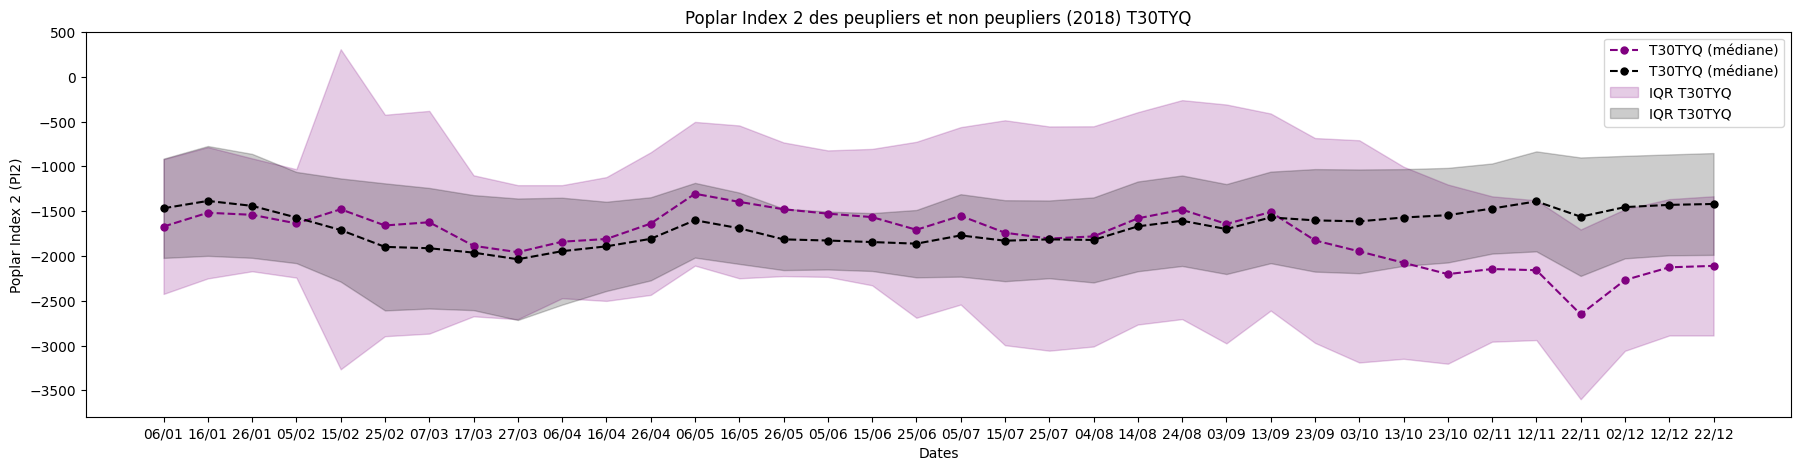

In [24]:
#Plot du Pi2 pour la tuile T30TYQ
peupliers_T30TYQ = data_test[data_test['Classe'] == 1]
peupliers_T30TYQ = peupliers_T30TYQ.drop(columns=['Annee_pl', 'Cultivars', 'age', 'Classe', 'id', 'originfid'])
non_peupliers_T30TYQ = data_test[data_test['Classe'] == 0]
non_peupliers_T30TYQ = non_peupliers_T30TYQ.drop(columns=['Annee_pl', 'Cultivars', 'age', 'Classe','id', 'originfid'])

peupliers_median_T30TYQ = peupliers_T30TYQ.median()
non_peupliers_median_T30TYQ = non_peupliers_T30TYQ.median()

peupliers_iqr_T30TYQ = peupliers_T30TYQ.quantile(0.75) - peupliers_T30TYQ.quantile(0.25)
non_peupliers_iqr_T30TYQ = non_peupliers_T30TYQ.quantile(0.75) - non_peupliers_T30TYQ.quantile(0.25)

plt.figure(7)
plt.figure(figsize=(22, 5))
plt.plot(dates,peupliers_median_T30TYQ, label='T30TYQ (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates, non_peupliers_median_T30TYQ, label='T30TYQ (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates, peupliers_median_T30TYQ - peupliers_iqr_T30TYQ, peupliers_median_T30TYQ + peupliers_iqr_T30TYQ, color='purple', alpha=0.2, label='IQR T30TYQ')
plt.fill_between(dates, non_peupliers_median_T30TYQ - non_peupliers_iqr_T30TYQ, non_peupliers_median_T30TYQ + non_peupliers_iqr_T30TYQ, color='black', alpha=0.2, label='IQR T30TYQ')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) T30TYQ')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()



### Features SFFS

In [25]:
#features sffs
X_test_sffs = X_test[['05/06', '23/10', '25/07', '24/08', '16/04']]
X_test_sffs

05/06   23/10   25/07   24/08   16/04
0     -1016.0 -1309.0  -847.0  -671.0 -1047.0
1     -1671.0 -3479.0 -2834.0 -3212.0 -1621.0
2     -2528.0 -1973.0 -2353.0 -2312.0 -2266.0
3     -2456.0 -2054.0 -2370.0 -2564.0 -2098.0
4      -776.0 -1747.0 -1009.0  -847.0 -1764.0
...       ...     ...     ...     ...     ...
45811 -1083.0 -1982.0  -998.0  -903.0  -816.0
45812 -2779.0 -1931.0 -2929.0 -2548.0 -2348.0
45813 -3823.0 -3577.0 -4492.0 -3835.0 -2672.0
45814 -1625.0 -1822.0 -1692.0 -1251.0 -1856.0
45815 -1633.0 -1135.0 -1626.0 -1333.0 -1677.0

[45816 rows x 5 columns]

### Tracé du pi2 médian et de l'interquartile pour les features sélectionnées

<Figure size 640x480 with 0 Axes>

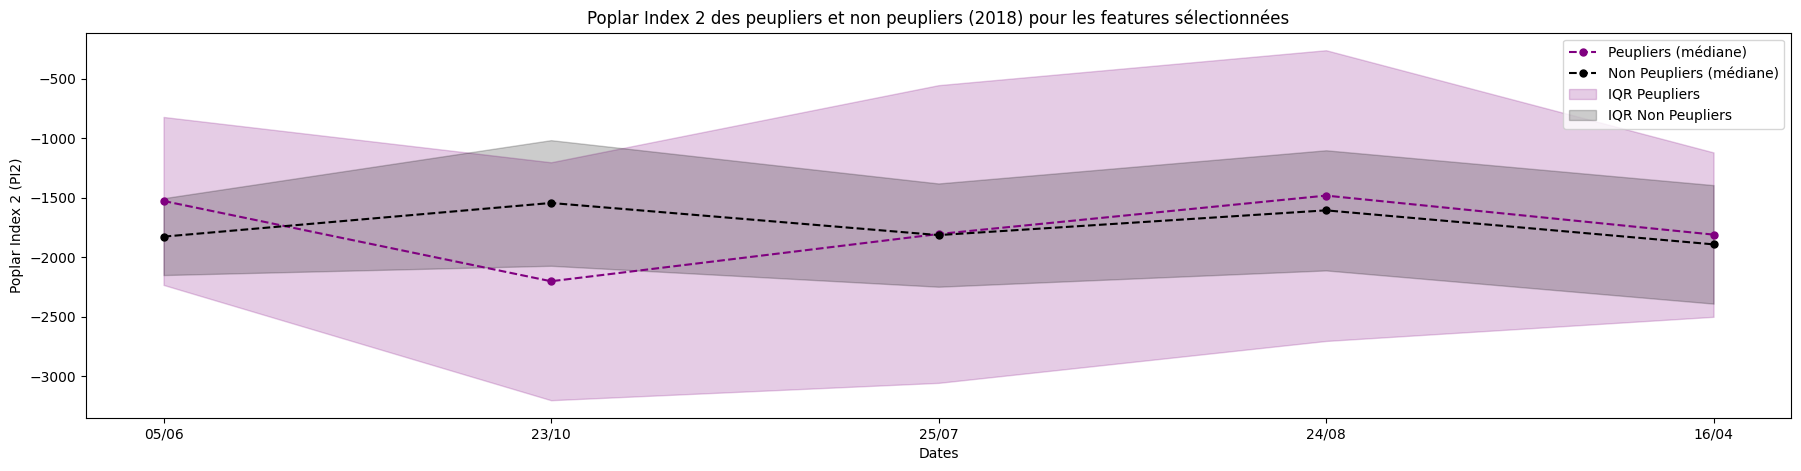

In [26]:
# Tracé du pi2 médian et de l'interquartile pour les features sélectionnées
peupliers_test_SFFS = X_test_sffs[y_test == 1]
non_peupliers_test_SFFS = X_test_sffs[y_test == 0]

peupliers_test_SFFS = pd.DataFrame(peupliers_test_SFFS)
non_peupliers_test_SFFS = pd.DataFrame(non_peupliers_test_SFFS)

peupliers_median_test_SFFS = peupliers_test_SFFS.median()
non_peupliers_median_test_SFFS = non_peupliers_test_SFFS.median()

peupliers_iqr_test_SFFS = peupliers_test_SFFS.quantile(0.75) - peupliers_test_SFFS.quantile(0.25)
non_peupliers_iqr_test_SFFS = non_peupliers_test_SFFS.quantile(0.75) - non_peupliers_test_SFFS.quantile(0.25)

dates_SFFS = ['05/06', '23/10', '25/07', '24/08', '16/04']
plt.figure(14)
plt.figure(figsize=(22, 5))
plt.plot(dates_SFFS,peupliers_median_test_SFFS, label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates_SFFS, non_peupliers_median_test_SFFS, label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates_SFFS, peupliers_median_test_SFFS - peupliers_iqr_test_SFFS, peupliers_median_test_SFFS + peupliers_iqr_test_SFFS, color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates_SFFS, non_peupliers_median_test_SFFS - non_peupliers_iqr_test_SFFS, non_peupliers_median_test_SFFS + non_peupliers_iqr_test_SFFS, color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) pour les features sélectionnées')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()



### PCA sur les données de test

In [27]:
#PCA sur les données de test
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

pca = PCA()
X_test_pca = pca.fit_transform(X_test_scaled)

#on garde les cinq premières composantes principales
X_test_pca = X_test_pca[:, :3]

### PCA sur les features SFFS

In [28]:
#pca sur les features sffs

scaler = StandardScaler()
X_test_sffs_scaled = scaler.fit_transform(X_test_sffs)

pca = PCA()
X_test_sffs_pca = pca.fit_transform(X_test_sffs_scaled)

X_test_sffs_pca = X_test_sffs_pca[:,:5]

## 2) Cross validation sans hyperparameter tuning (10fold)

### a) Avec données brutes (36 features)

In [29]:
X = X.values #on convertit en np array
y = y.values


num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

Fold 0 Accuracy: 0.9774728120145003
Fold 1 Accuracy: 0.9785085447954428
Fold 2 Accuracy: 0.9766960124287933
Fold 3 Accuracy: 0.981874676333506
Fold 4 Accuracy: 0.9754013464526152
Fold 5 Accuracy: 0.9766960124287933
Fold 6 Accuracy: 0.9761781460383221
Fold 7 Accuracy: 0.9795442775763853
Fold 8 Accuracy: 0.9772079772079773
Fold 9 Accuracy: 0.98005698005698
Meilleur score d'exactitude : 0.98
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  114.37884187698364


In [30]:
# On entraine le meilleur modèle sur toutes les données
best_model_cv.fit(X, y)

#joblib.dump(best_model_cv, 'Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl')

RandomForestClassifier(random_state=7)

In [31]:
models

[(RandomForestClassifier(random_state=7), 0.9774728120145003),
 (RandomForestClassifier(random_state=7), 0.9785085447954428),
 (RandomForestClassifier(random_state=7), 0.9766960124287933),
 (RandomForestClassifier(random_state=7), 0.981874676333506),
 (RandomForestClassifier(random_state=7), 0.9754013464526152),
 (RandomForestClassifier(random_state=7), 0.9766960124287933),
 (RandomForestClassifier(random_state=7), 0.9761781460383221),
 (RandomForestClassifier(random_state=7), 0.9795442775763853),
 (RandomForestClassifier(random_state=7), 0.9772079772079773),
 (RandomForestClassifier(random_state=7), 0.98005698005698)]

In [32]:
y_pred_test = best_model_cv.predict(X_test.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test.values)
accuracy_test = accuracy_score(y_test.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)

Test Set Accuracy: 0.7299633315872185


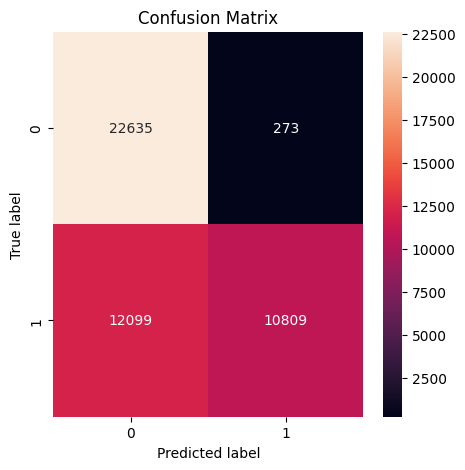

              precision    recall  f1-score   support

         0.0       0.65      0.99      0.79     22908
         1.0       0.98      0.47      0.64     22908

    accuracy                           0.73     45816
   macro avg       0.81      0.73      0.71     45816
weighted avg       0.81      0.73      0.71     45816



In [33]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

### Tracés des accuracy par âge, par cultivar, par âge et cultivar + probabilité d'appartenance par âge, par cultivar et par âge et cultivar

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['age'] = data_test[y_test_['Classe'] == 1]['age']
C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empt

<Figure size 640x480 with 0 Axes>

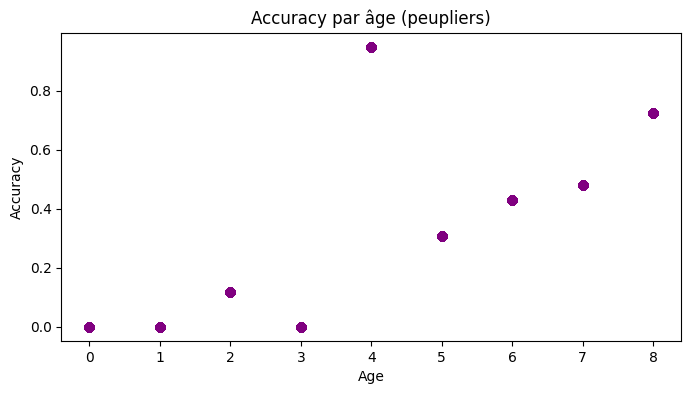

<Figure size 640x480 with 0 Axes>

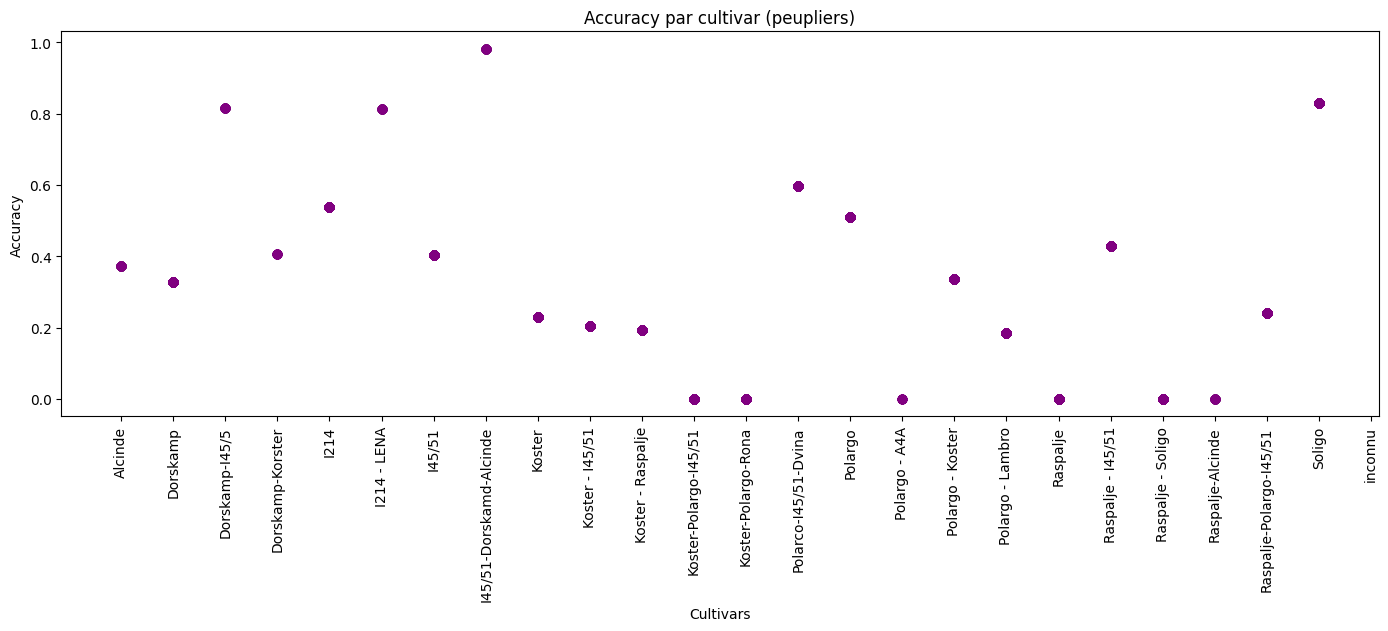

<Figure size 640x480 with 0 Axes>

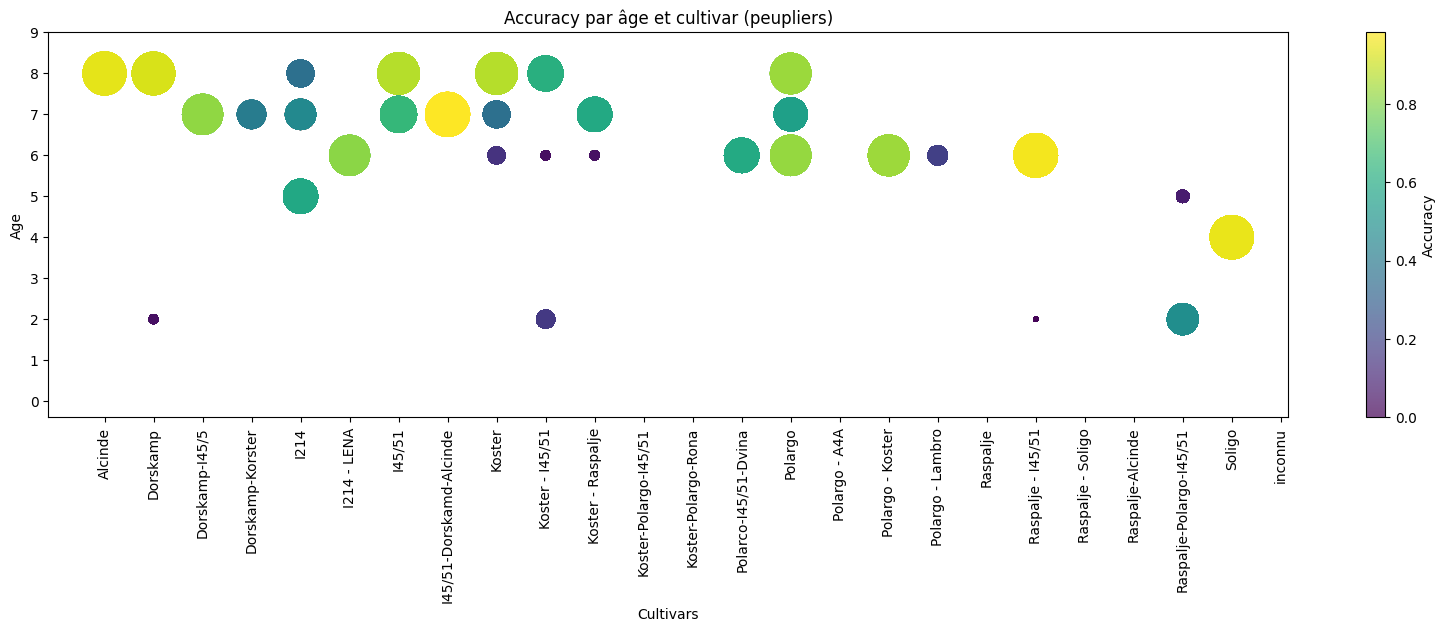

<Figure size 640x480 with 0 Axes>

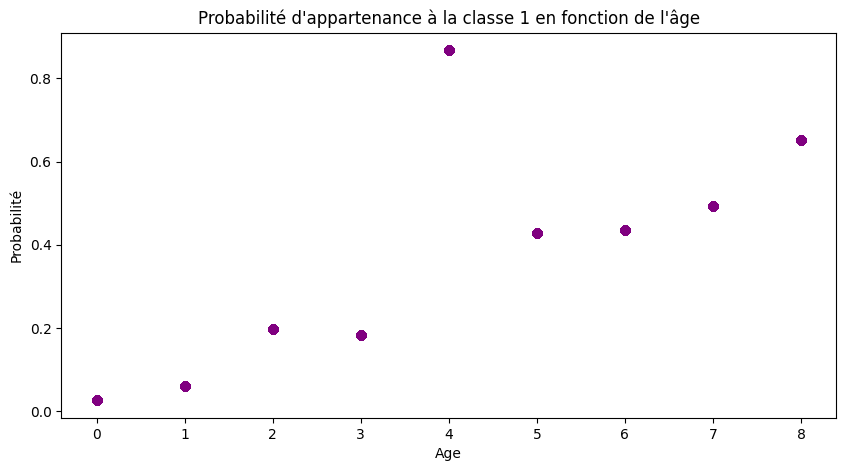

<Figure size 640x480 with 0 Axes>

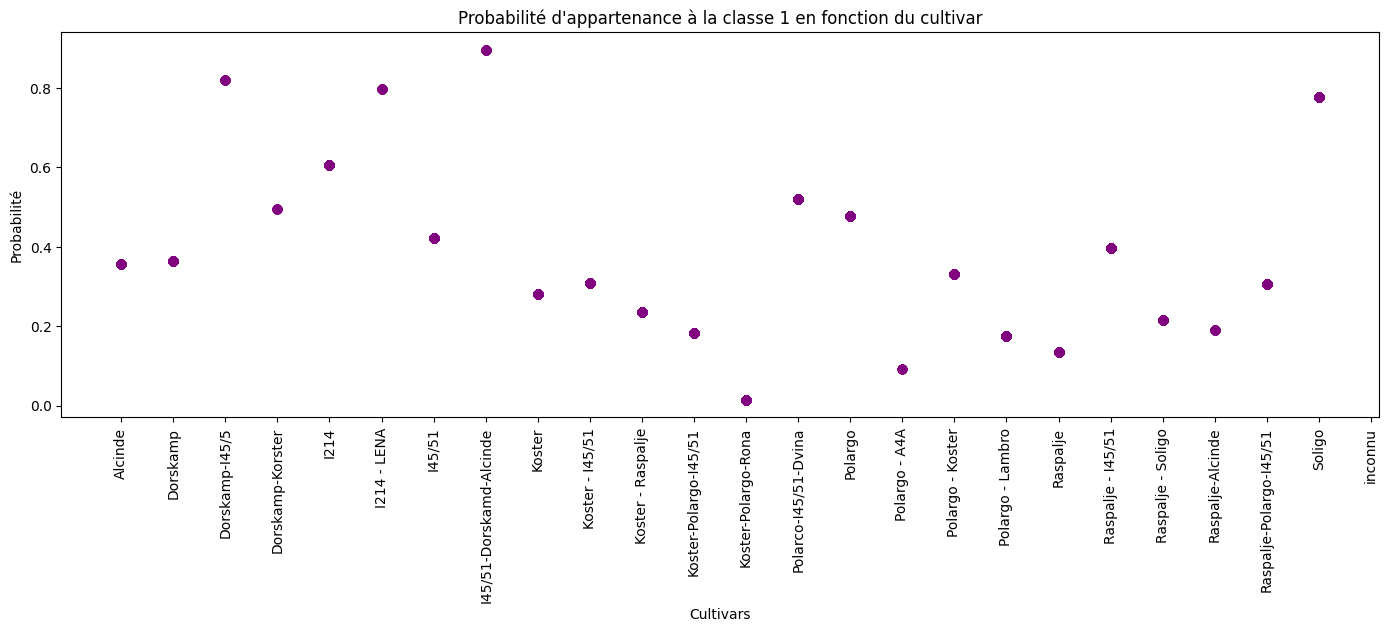

<Figure size 640x480 with 0 Axes>

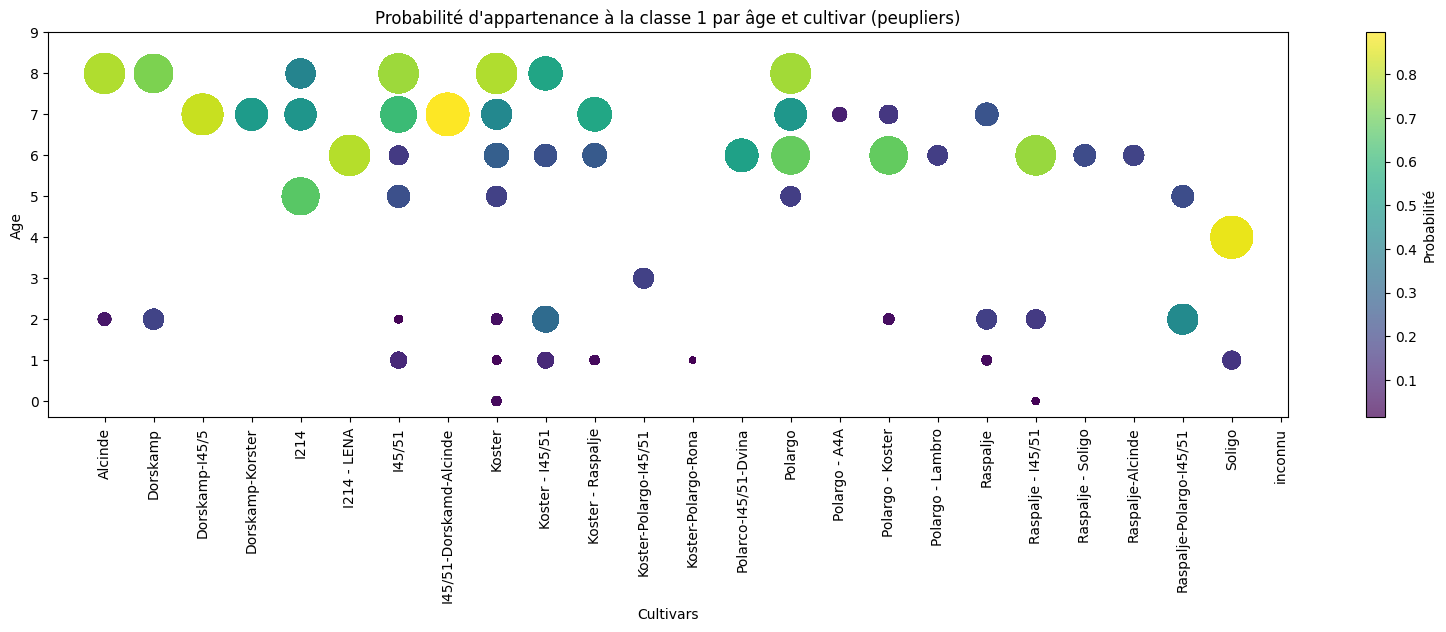

In [35]:
#On observe la qualité de prédiction par âge de plantation de peupliers
peupliers_pred = pd.DataFrame(y_pred_test, columns=['Classe'])
peupliers_pred['Probabilité'] = y_pred_test_proba[:,1]
y_test_ = pd.DataFrame(y_test, columns=['Classe'])

peupliers_pred = peupliers_pred[y_test_['Classe'] == 1]
peupliers_pred['age'] = data_test[y_test_['Classe'] == 1]['age']
peupliers_pred['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
peupliers_pred = peupliers_pred.reset_index(drop=True)

y_test_peupliers = y_test_[y_test_['Classe'] == 1]
y_test_peupliers['age'] = data_test[y_test_['Classe'] == 1]['age']
y_test_peupliers['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
y_test_peupliers = y_test_peupliers.reset_index(drop=True)

#print(peupliers_pred.value_counts('age'))
#print(y_test_peupliers.value_counts('age'))

#On rassemble les cultivars dupliqués
peupliers_pred.loc[peupliers_pred["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
peupliers_pred.loc[peupliers_pred["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'

y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'


for age in peupliers_pred['age'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Accuracy par age'] = accuracy_score(peupliers_pred[peupliers_pred['age'] == age]['Classe'], y_test_peupliers[y_test_peupliers['age'] == age]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Accuracy par cultivar'] = accuracy_score(peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Classe'], y_test_peupliers[y_test_peupliers['Cultivars'] == cultivar]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Accuracy par cultivar et age'] = accuracy_score(peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Classe'], y_test_peupliers[(y_test_peupliers['Cultivars'] == cultivar) & (y_test_peupliers['age'] == age)]['Classe'])

#moyenne de proba d'appartenance à la classe 1 par âge
for age in peupliers_pred['age'].unique():
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Probabilité par âge'] = peupliers_pred[peupliers_pred['age'] == age]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Probabilité par cultivar'] = peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par âge et par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Probabilité par cultivar et age'] = peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Probabilité'].mean()



#remplacer les nan par "inconnu"    
peupliers_pred['Cultivars'] = peupliers_pred['Cultivars'].fillna('inconnu')

#ranger les cultivars par ordre alphabétique (pour l'affichage)
peupliers_pred = peupliers_pred.sort_values('Cultivars')


#plot
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred['age'], peupliers_pred['Accuracy par age'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.title('Accuracy par âge (peupliers)')
plt.show()

plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Accuracy par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers
plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Accuracy par cultivar et age']*1000, c=peupliers_pred['Accuracy par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Accuracy')
plt.show()


#proba d'appartenance à la classe 1 en fonction de l'âge
plt.figure(18)
plt.figure(figsize=(10, 5))
plt.scatter(peupliers_pred['age'], peupliers_pred['Probabilité par âge'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction de l\'âge')
plt.show()

#proba d'appartenance à la classe 1 en fonction du cultivar
plt.figure(19)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Probabilité par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction du cultivar')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser la probabilité d'appartenance à la classe 1 par âge et par cultivar pour les peupliers
plt.figure(20)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Probabilité par cultivar et age']*1000, c=peupliers_pred['Probabilité par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Probabilité d\'appartenance à la classe 1 par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Probabilité')
plt.show()



### Remarque (AVEC LE TEST SET INITIAL)
Ici on a juste effectué la cross validation 10 fold sans se préoccuper du finetuning. Trois approches ont été testées sur les données brutes : 

Approche 1 : Classification sur 7 classes (peupliers et les autres variétés d'arbre), dataset presque équilibrée (19000 pour tous sauf 1 classe à 8000 échantillons), accuracy sur la validation = 84%, sur le testset = 18%.

Approche 2 : Classification sur 2 classes (peuplier et non-peupliers), dataset non équilibrée (environ 100 000 éch pour non-peupliers et 19000 pour peupliers), accuracy sur valset = 98%, sur testset = 20%. 

***Approche 3 (approche actuelle)*** : Classification sur 2 classes (peupliers et non-peupliers), dataset équilibrée (19309 de chaque classe), accuracy sur valset = 98%, sur testset = 24,3%

### Remarque 
On obtient une accuracy sur trainset de 98% et 73% sur le testset. On soupçonne un potentiel overfitting ou des données de test plus complexe que le trainset.

### b) Sur les données PCA des 36 features

In [36]:
#Avec les données PCA
X_pca
y = y
X_test_pca
#y_test = y_test.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucler sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_pca)):
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    # Sauvegarder le modèle et son score
    models.append((rf_model, accuracy))

    # Mettre à jour le meilleur modèle si nécessaire
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_pca, y)
joblib.dump(best_model_cv, 'PCA_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl')

# Evaluate the best model on the validation set
y_pred_test = best_model_cv.predict(X_test_pca)
y_pred_test_proba = best_model_cv.predict_proba(X_test_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", accuracy_test)

Fold 0 Accuracy: 0.9445882962195753
Fold 1 Accuracy: 0.9412221646815122
Fold 2 Accuracy: 0.946918694976696
Fold 3 Accuracy: 0.9510616261004661
Fold 4 Accuracy: 0.9357845675815639
Fold 5 Accuracy: 0.9425168306576903
Fold 6 Accuracy: 0.9456240290005179
Fold 7 Accuracy: 0.9435525634386328
Fold 8 Accuracy: 0.940947940947941
Fold 9 Accuracy: 0.9427609427609428
Meilleur score d'exactitude : 0.95
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  28.193939924240112
Test Set Accuracy: 0.6365025318665968


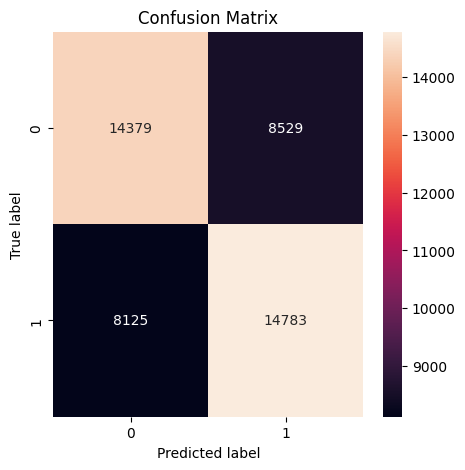

              precision    recall  f1-score   support

         0.0       0.64      0.63      0.63     22908
         1.0       0.63      0.65      0.64     22908

    accuracy                           0.64     45816
   macro avg       0.64      0.64      0.64     45816
weighted avg       0.64      0.64      0.64     45816



In [37]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

Remarque : 3 composantes donne le meilleur résultat. 64% d'accuracy sur le testset et 95% sur le trainset. 

### c) Sur les features sélectionnées par SFFS 2017

In [40]:
#A DECOMMENTER SI ERREUR
# X_SFFS = X_SFFS.values
# y = y.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS)):
    X_train, X_val = X_SFFS[train_index], X_SFFS[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS, y)
joblib.dump(best_model_cv, 'SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl')


Fold 0 Accuracy: 0.9526152252718798
Fold 1 Accuracy: 0.9531330916623512
Fold 2 Accuracy: 0.9505437597099948
Fold 3 Accuracy: 0.9554634904194718
Fold 4 Accuracy: 0.9476954945624029
Fold 5 Accuracy: 0.953909891248058
Fold 6 Accuracy: 0.9515794924909373
Fold 7 Accuracy: 0.9528741584671155
Fold 8 Accuracy: 0.9531209531209531
Fold 9 Accuracy: 0.9528619528619529
Meilleur score d'exactitude : 0.96
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  37.13606262207031


['SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl']

Test Set Accuracy: 0.7021346254583551


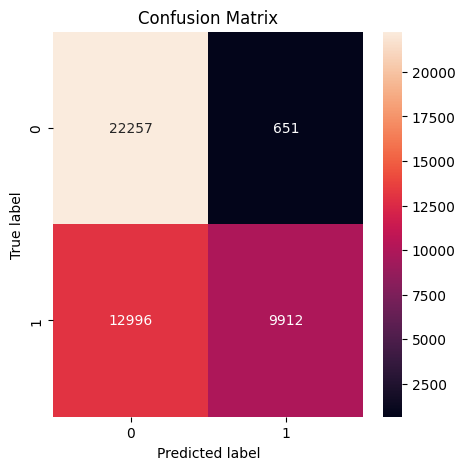

              precision    recall  f1-score   support

         0.0       0.63      0.97      0.77     22908
         1.0       0.94      0.43      0.59     22908

    accuracy                           0.70     45816
   macro avg       0.78      0.70      0.68     45816
weighted avg       0.78      0.70      0.68     45816



In [41]:
y_pred_test = best_model_cv.predict(X_test_sffs.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test_sffs.values)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

### Tracés des accuracy par âge, par cultivar, par âge et cultivar + probabilité d'appartenance par âge, par cultivar et par âge et cultivar

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['age'] = data_test[y_test_['Classe'] == 1]['age']
C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empt

<Figure size 640x480 with 0 Axes>

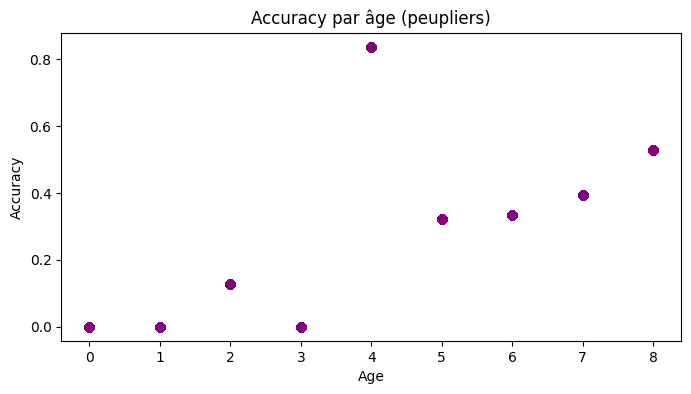

<Figure size 640x480 with 0 Axes>

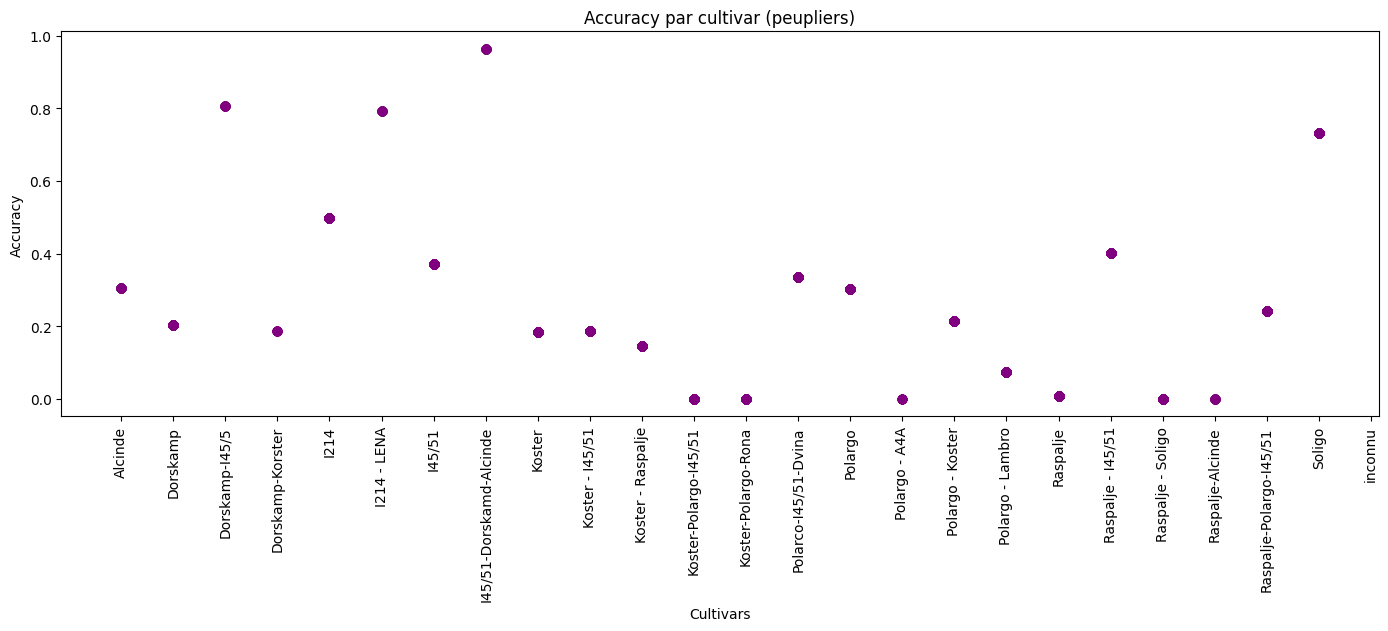

<Figure size 640x480 with 0 Axes>

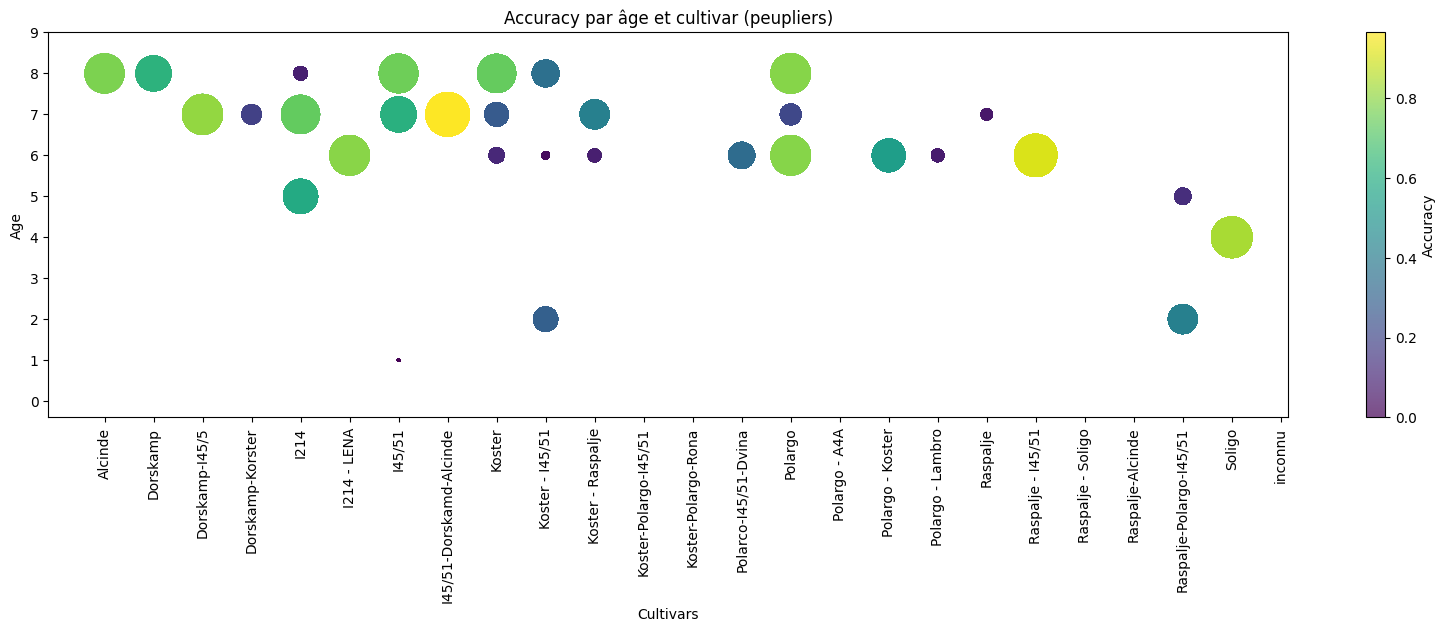

<Figure size 640x480 with 0 Axes>

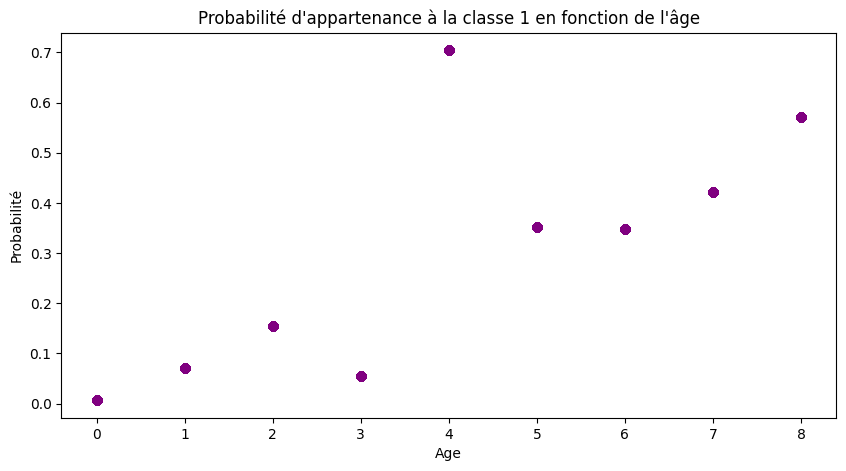

<Figure size 640x480 with 0 Axes>

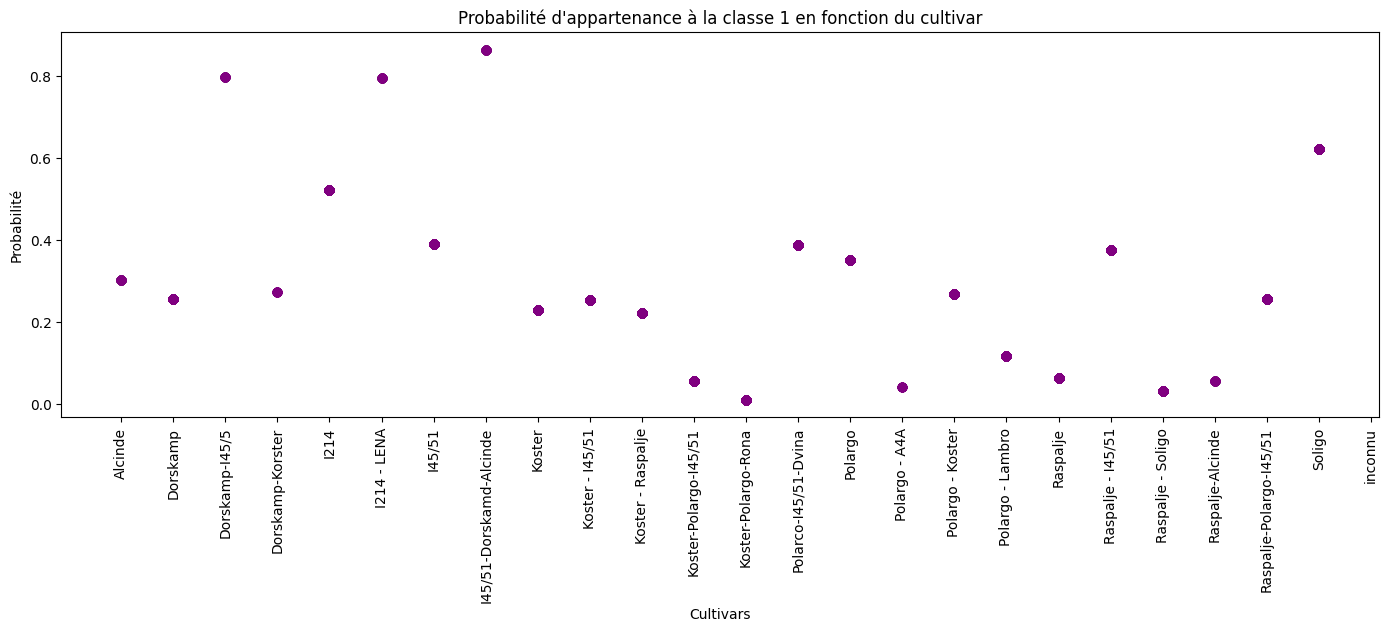

<Figure size 640x480 with 0 Axes>

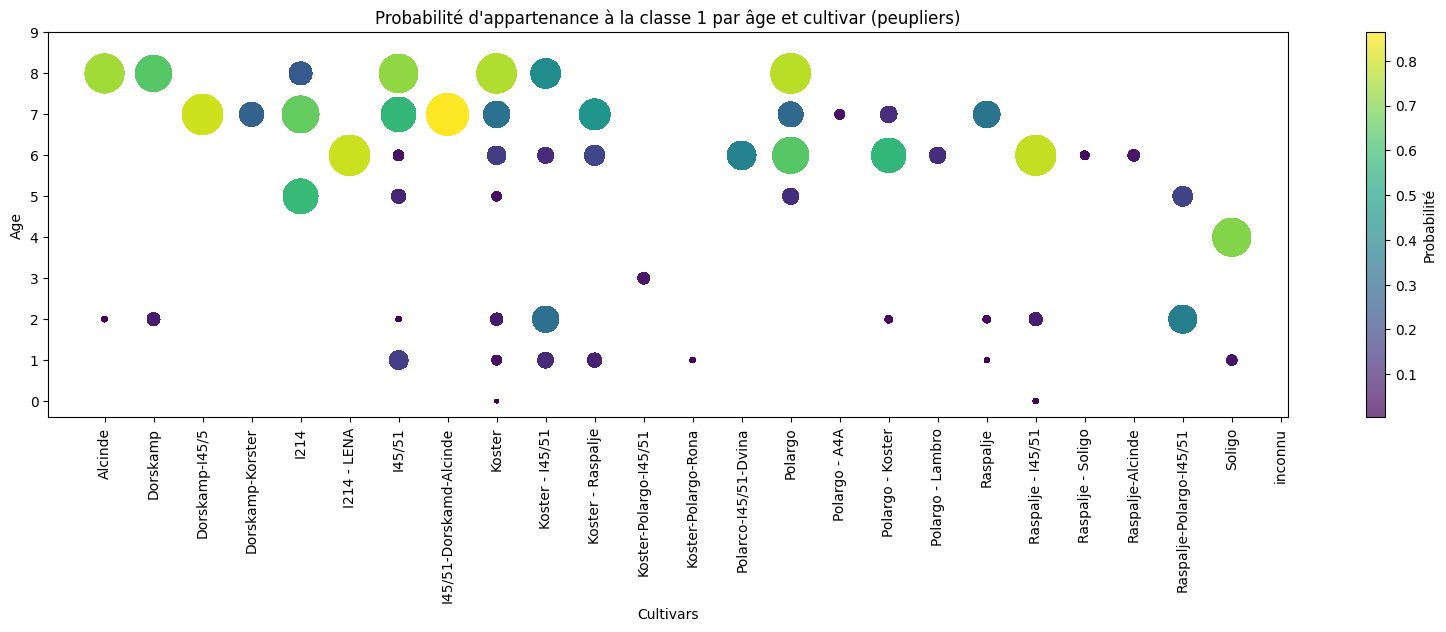

In [42]:
#On observe la qualité de prédiction par âge de plantation de peupliers
peupliers_pred = pd.DataFrame(y_pred_test, columns=['Classe'])
peupliers_pred['Probabilité'] = y_pred_test_proba[:,1]
y_test_ = pd.DataFrame(y_test, columns=['Classe'])

peupliers_pred = peupliers_pred[y_test_['Classe'] == 1]
peupliers_pred['age'] = data_test[y_test_['Classe'] == 1]['age']
peupliers_pred['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
peupliers_pred = peupliers_pred.reset_index(drop=True)

y_test_peupliers = y_test_[y_test_['Classe'] == 1]
y_test_peupliers['age'] = data_test[y_test_['Classe'] == 1]['age']
y_test_peupliers['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
y_test_peupliers = y_test_peupliers.reset_index(drop=True)

#print(peupliers_pred.value_counts('age'))
#print(y_test_peupliers.value_counts('age'))

#On rassemble les cultivars dupliqués
peupliers_pred.loc[peupliers_pred["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
peupliers_pred.loc[peupliers_pred["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
peupliers_pred.loc[peupliers_pred["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'

y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'


for age in peupliers_pred['age'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Accuracy par age'] = accuracy_score(peupliers_pred[peupliers_pred['age'] == age]['Classe'], y_test_peupliers[y_test_peupliers['age'] == age]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Accuracy par cultivar'] = accuracy_score(peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Classe'], y_test_peupliers[y_test_peupliers['Cultivars'] == cultivar]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Accuracy par cultivar et age'] = accuracy_score(peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Classe'], y_test_peupliers[(y_test_peupliers['Cultivars'] == cultivar) & (y_test_peupliers['age'] == age)]['Classe'])

#moyenne de proba d'appartenance à la classe 1 par âge
for age in peupliers_pred['age'].unique():
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Probabilité par âge'] = peupliers_pred[peupliers_pred['age'] == age]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Probabilité par cultivar'] = peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par âge et par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Probabilité par cultivar et age'] = peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Probabilité'].mean()



#remplacer les nan par "inconnu"    
peupliers_pred['Cultivars'] = peupliers_pred['Cultivars'].fillna('inconnu')

#ranger les cultivars par ordre alphabétique (pour l'affichage)
peupliers_pred = peupliers_pred.sort_values('Cultivars')


#plot
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred['age'], peupliers_pred['Accuracy par age'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.title('Accuracy par âge (peupliers)')
plt.show()

plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Accuracy par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers
plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Accuracy par cultivar et age']*1000, c=peupliers_pred['Accuracy par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Accuracy')
plt.show()


#proba d'appartenance à la classe 1 en fonction de l'âge
plt.figure(18)
plt.figure(figsize=(10, 5))
plt.scatter(peupliers_pred['age'], peupliers_pred['Probabilité par âge'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction de l\'âge')
plt.show()

#proba d'appartenance à la classe 1 en fonction du cultivar
plt.figure(19)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Probabilité par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction du cultivar')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser la probabilité d'appartenance à la classe 1 par âge et par cultivar pour les peupliers
plt.figure(20)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Probabilité par cultivar et age']*1000, c=peupliers_pred['Probabilité par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Probabilité d\'appartenance à la classe 1 par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Probabilité')
plt.show()



### Tracé de la vitesse de croissance en fonction de la croissance juvénile reliée aux cultivars

<Figure size 640x480 with 0 Axes>

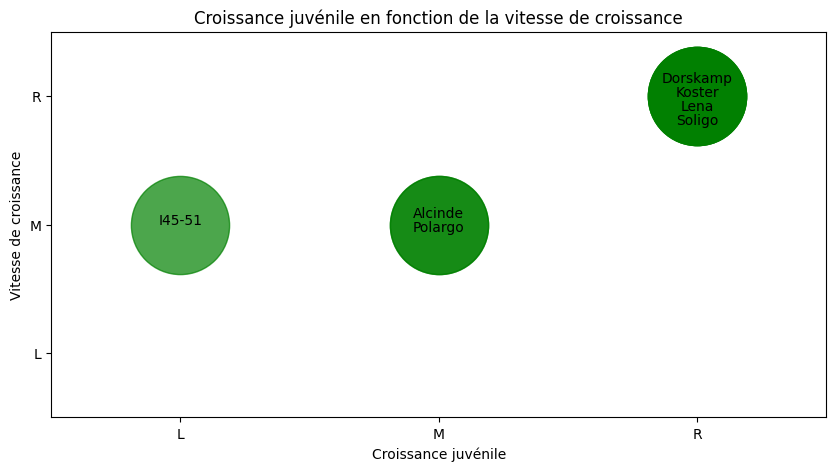

In [43]:
# plot du cultivar en fonction de la croissance juvénile et de la vitesse de croissance
cultivars = ["Albelo", "Alcinde", "Blanc du Poitou", "Brenta", "Dorskamp", "Dvina", "Flevo", "Fritzy Pauley", "I45-51", "Koster", "Lena", "Muur", "Oglio", "Oudenberg", "Polargo", "Soligo", "Taro", "Trichobel", "Vesten"]
croissance_juvenile = ["M", "M", "L", "M", "R", "R", "M","L","L","R","R","M","R","M","M","R","M","L","R"]
vitesse_croissance = ["M", "M", "M", "M", "R", "R", "M", "M", "M", "R", "R", "M", "R", "M", "M", "R", "M", "L", "R"]

#réduits aux cultivars présents dans le jeu de données
cultivars = [ "Alcinde","Dorskamp",  "I45-51", "Koster", "Lena", "Polargo", "Soligo"]
croissance_juvenile = [ "M",  "R" ,"L","R","R","M","R"]
vitesse_croissance = [ "M",  "R", "M", "R", "R", "M", "R"]

#on remplace L par 0, M par 1 et R par 2
croissance_juvenile = [0 if x == "L" else x for x in croissance_juvenile]
croissance_juvenile = [1 if x == "M" else x for x in croissance_juvenile]
croissance_juvenile = [2 if x == "R" else x for x in croissance_juvenile]

vitesse_croissance = [0 if x == "L" else x for x in vitesse_croissance]
vitesse_croissance = [1 if x == "M" else x for x in vitesse_croissance]
vitesse_croissance = [2 if x == "R" else x for x in vitesse_croissance]


plt.cla
plt.figure(21)
plt.figure(figsize=(10, 5))
plt.scatter(croissance_juvenile, vitesse_croissance, s=5000, c='green', alpha=0.7)
plt.xlabel('Croissance juvénile')
plt.ylabel('Vitesse de croissance')
plt.title('Croissance juvénile en fonction de la vitesse de croissance')
plt.xticks(range(0,3,1), ["L", "M", "R"])
plt.xlim(-0.5, 2.5)
plt.ylim(-0.5, 2.5)
plt.yticks(range(0,3,1), ["L", "M", "R"])

j=0
g = 0
h=0
k=0
for i, txt in enumerate(cultivars):
    if croissance_juvenile[i] == 0 & vitesse_croissance[i] == 0:
        plt.annotate(txt, (croissance_juvenile[i], vitesse_croissance[i]), textcoords="offset points", xytext=(0,0-j*10), ha='center')
        j += 1
    elif croissance_juvenile[i] == 0 & vitesse_croissance[i] == 1:
        plt.annotate(txt, (croissance_juvenile[i], vitesse_croissance[i]), textcoords="offset points", xytext=(0,0-g*10), ha='center')
        g += 1
    elif croissance_juvenile[i] == 1 & vitesse_croissance[i] == 1:
        plt.annotate(txt, (croissance_juvenile[i], vitesse_croissance[i]), textcoords="offset points", xytext=(0,5-h*10), ha='center')
        h += 1
    else:
        plt.annotate(txt, (croissance_juvenile[i], vitesse_croissance[i]), textcoords="offset points", xytext=(0,10-k*10), ha='center')
        k += 1
plt.show()

### d) Sur les données PCA des features choisies par SFFS 2017

In [44]:
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs_pca = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_sffs_pca)):
    X_train, X_val = X_sffs_pca[train_index], X_sffs_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_sffs_pca, y)
#joblib.dump(best_model_cv, 'PCA_SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state=7.pkl')



Fold 0 Accuracy: 0.9520973588814086
Fold 1 Accuracy: 0.9523562920766442
Fold 2 Accuracy: 0.9526152252718798
Fold 3 Accuracy: 0.9557224236147074
Fold 4 Accuracy: 0.9510616261004661
Fold 5 Accuracy: 0.9518384256861729
Fold 6 Accuracy: 0.9526152252718798
Fold 7 Accuracy: 0.9508026929052305
Fold 8 Accuracy: 0.9505309505309505
Fold 9 Accuracy: 0.9557109557109557
Meilleur score d'exactitude : 0.96
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  57.025150537490845


RandomForestClassifier(random_state=7)

In [45]:
y_pred_test = best_model_cv.predict(X_test_sffs_pca)
y_pred_test_proba = best_model_cv.predict_proba(X_test_sffs_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

Test Set Accuracy: 0.6561681508643269


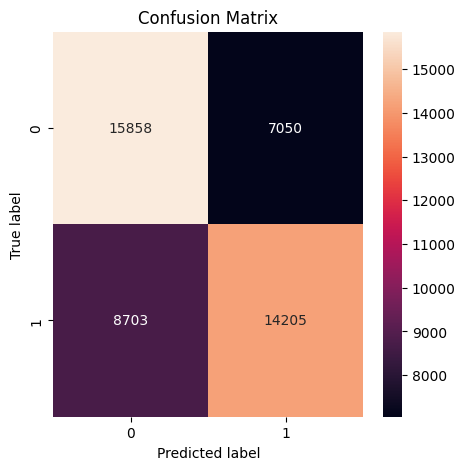

              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67     22908
         1.0       0.67      0.62      0.64     22908

    accuracy                           0.66     45816
   macro avg       0.66      0.66      0.66     45816
weighted avg       0.66      0.66      0.66     45816



In [46]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['age'] = data_test[y_test_['Classe'] == 1]['age']
C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_54076\1580808160.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['Cultivars'] = data_test[y_test_['Classe'] == 1]['Cultivars']
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empt

<Figure size 640x480 with 0 Axes>

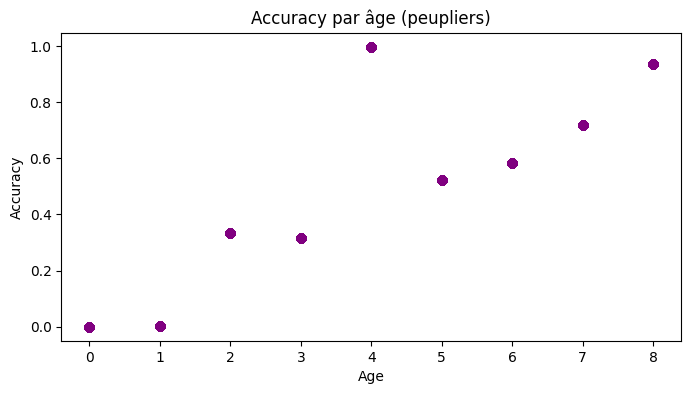

<Figure size 640x480 with 0 Axes>

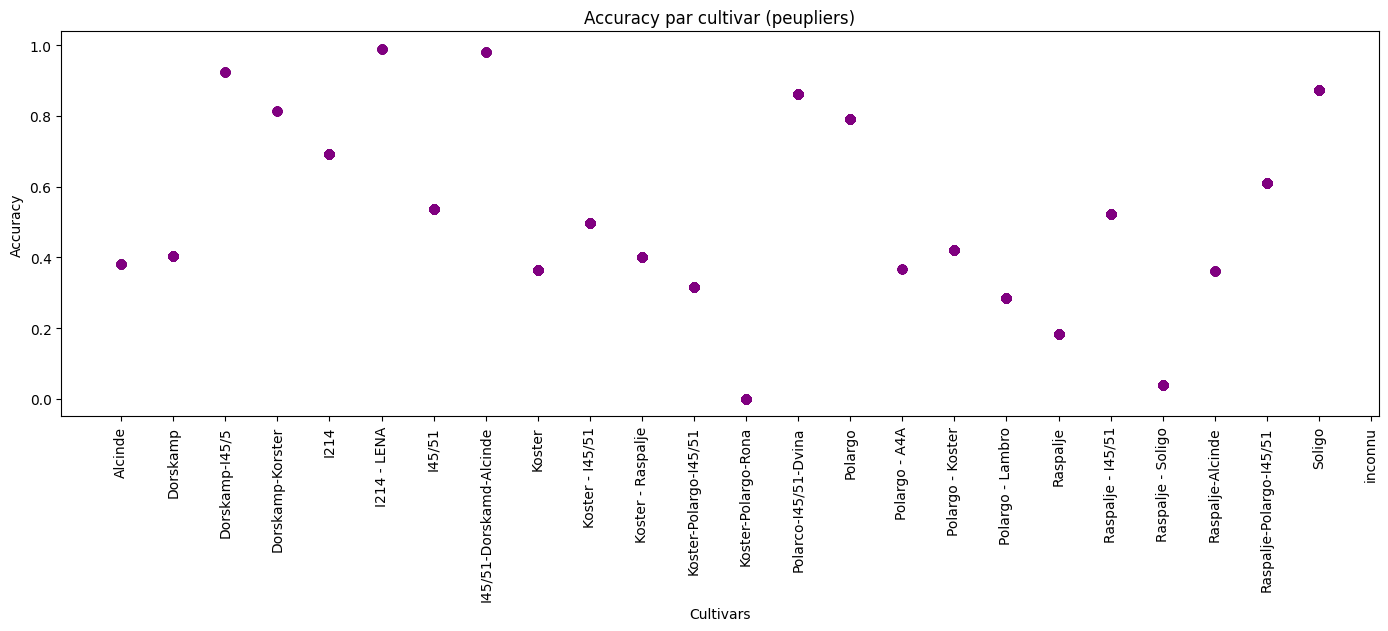

<Figure size 640x480 with 0 Axes>

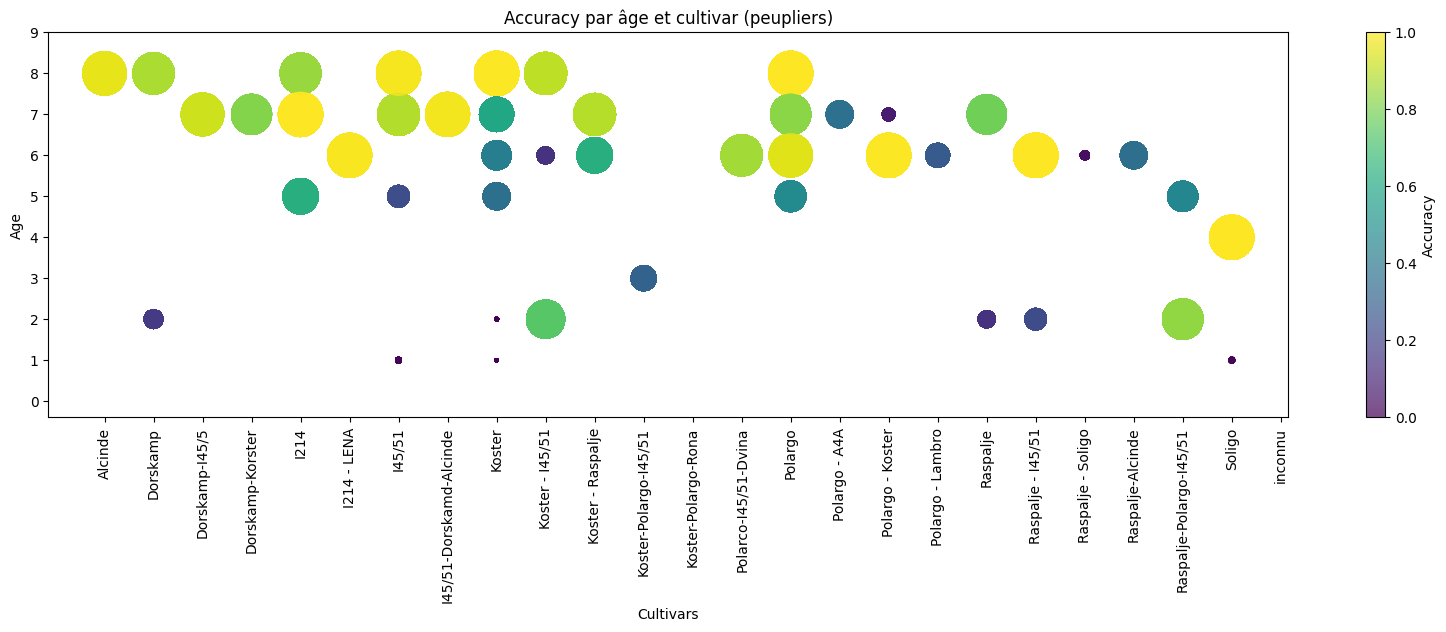

<Figure size 640x480 with 0 Axes>

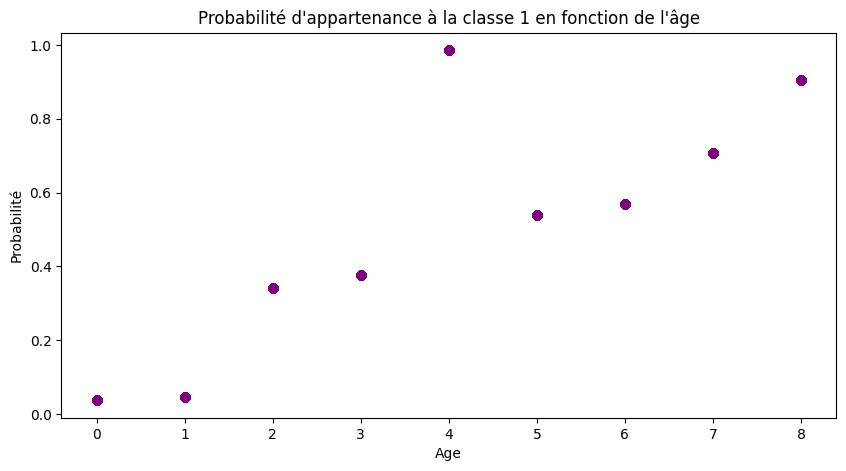

<Figure size 640x480 with 0 Axes>

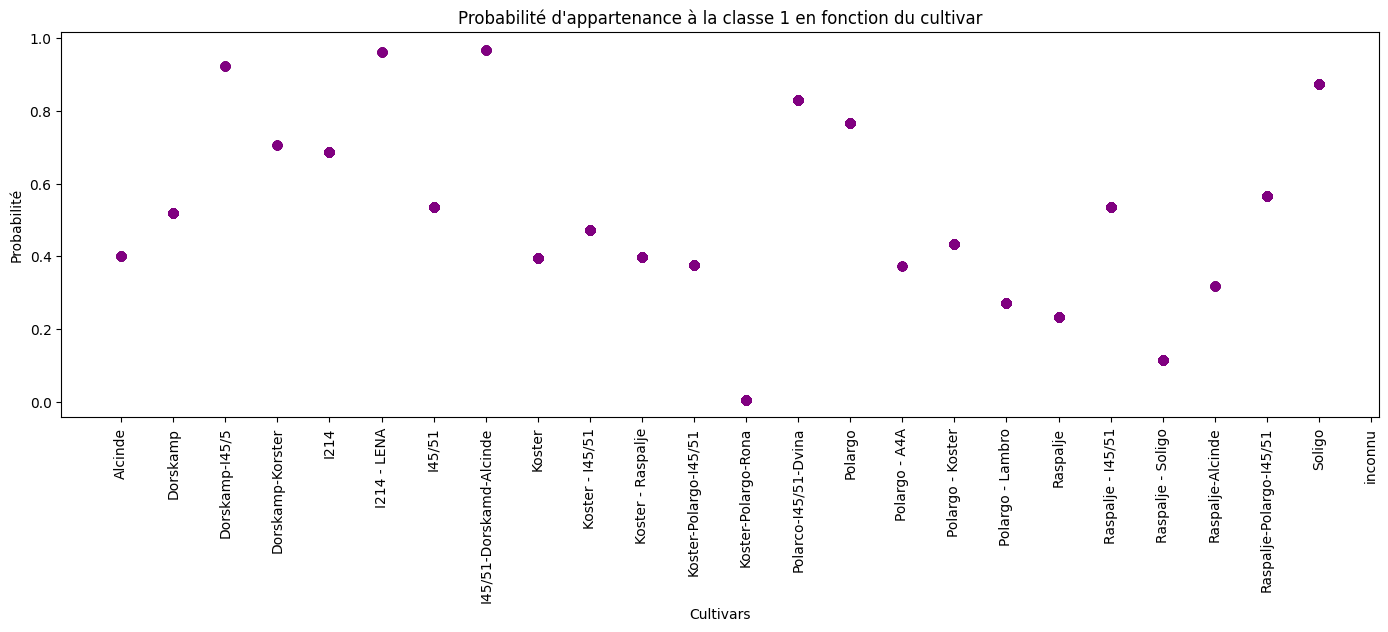

<Figure size 640x480 with 0 Axes>

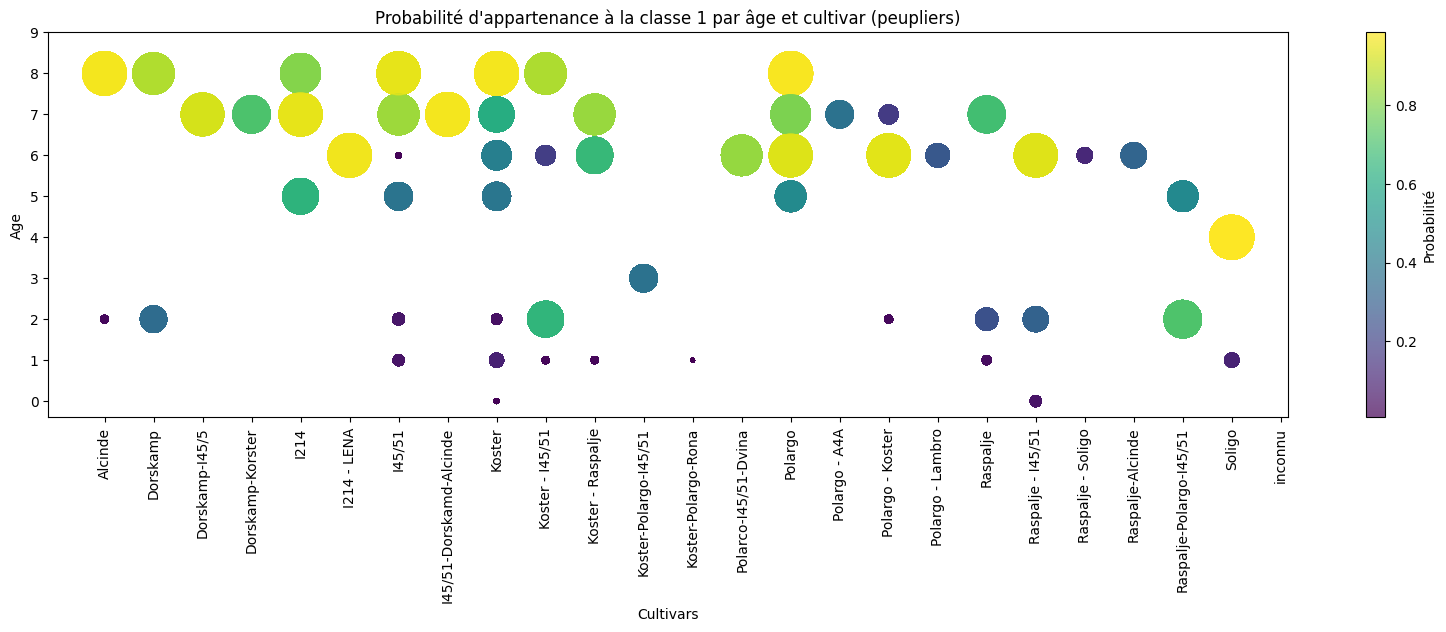

In [47]:
#On observe la qualité de prédiction par âge de plantation de peupliers
peupliers_pred_PCA = pd.DataFrame(y_pred_test, columns=['Classe'])
peupliers_pred_PCA['Probabilité'] = y_pred_test_proba[:,1]
y_test_PCA = pd.DataFrame(y_test, columns=['Classe'])

peupliers_pred_PCA = peupliers_pred_PCA[y_test_PCA['Classe'] == 1]
peupliers_pred_PCA['age'] = data_test[y_test_PCA['Classe'] == 1]['age']
peupliers_pred_PCA['Cultivars'] = data_test[y_test_PCA['Classe'] == 1]['Cultivars']
peupliers_pred_PCA = peupliers_pred_PCA.reset_index(drop=True)

y_test_peupliers = y_test_PCA[y_test_PCA['Classe'] == 1]
y_test_peupliers['age'] = data_test[y_test_PCA['Classe'] == 1]['age']
y_test_peupliers['Cultivars'] = data_test[y_test_PCA['Classe'] == 1]['Cultivars']
y_test_peupliers = y_test_peupliers.reset_index(drop=True)

#print(peupliers_pred.value_counts('age'))
#print(y_test_peupliers.value_counts('age'))

#On rassemble les cultivars dupliqués
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
peupliers_pred_PCA.loc[peupliers_pred_PCA["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'

y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'


for age in peupliers_pred_PCA['age'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred_PCA.loc[peupliers_pred_PCA['age'] == age, 'Accuracy par age'] = accuracy_score(peupliers_pred_PCA[peupliers_pred_PCA['age'] == age]['Classe'], y_test_peupliers[y_test_peupliers['age'] == age]['Classe'])

for cultivar in peupliers_pred_PCA['Cultivars'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred_PCA.loc[peupliers_pred_PCA['Cultivars'] == cultivar, 'Accuracy par cultivar'] = accuracy_score(peupliers_pred_PCA[peupliers_pred_PCA['Cultivars'] == cultivar]['Classe'], y_test_peupliers[y_test_peupliers['Cultivars'] == cultivar]['Classe'])

for cultivar in peupliers_pred_PCA['Cultivars'].unique():
    for age in peupliers_pred_PCA['age'].unique():
        #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
        peupliers_pred_PCA.loc[(peupliers_pred_PCA['Cultivars'] == cultivar) & (peupliers_pred_PCA['age'] == age), 'Accuracy par cultivar et age'] = accuracy_score(peupliers_pred_PCA[(peupliers_pred_PCA['Cultivars'] == cultivar) & (peupliers_pred_PCA['age'] == age)]['Classe'], y_test_peupliers[(y_test_peupliers['Cultivars'] == cultivar) & (y_test_peupliers['age'] == age)]['Classe'])

#moyenne de proba d'appartenance à la classe 1 par âge
for age in peupliers_pred_PCA['age'].unique():
    peupliers_pred_PCA.loc[peupliers_pred_PCA['age'] == age, 'Probabilité par âge'] = peupliers_pred_PCA[peupliers_pred_PCA['age'] == age]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par cultivar
for cultivar in peupliers_pred_PCA['Cultivars'].unique():
    peupliers_pred_PCA.loc[peupliers_pred_PCA['Cultivars'] == cultivar, 'Probabilité par cultivar'] = peupliers_pred_PCA[peupliers_pred_PCA['Cultivars'] == cultivar]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par âge et par cultivar
for cultivar in peupliers_pred_PCA['Cultivars'].unique():
    for age in peupliers_pred_PCA['age'].unique():
        peupliers_pred_PCA.loc[(peupliers_pred_PCA['Cultivars'] == cultivar) & (peupliers_pred_PCA['age'] == age), 'Probabilité par cultivar et age'] = peupliers_pred_PCA[(peupliers_pred_PCA['Cultivars'] == cultivar) & (peupliers_pred_PCA['age'] == age)]['Probabilité'].mean()



#remplacer les nan par "inconnu"    
peupliers_pred_PCA['Cultivars'] = peupliers_pred_PCA['Cultivars'].fillna('inconnu')

#ranger les cultivars par ordre alphabétique (pour l'affichage)
peupliers_pred_PCA = peupliers_pred_PCA.sort_values('Cultivars')


#plot
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred_PCA['age'], peupliers_pred_PCA['Accuracy par age'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.title('Accuracy par âge (peupliers)')
plt.show()

plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred_PCA['Cultivars'], peupliers_pred_PCA['Accuracy par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers
plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred_PCA['Cultivars'], peupliers_pred_PCA['age'], s=peupliers_pred_PCA['Accuracy par cultivar et age']*1000, c=peupliers_pred_PCA['Accuracy par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Accuracy')
plt.show()


#proba d'appartenance à la classe 1 en fonction de l'âge
plt.figure(18)
plt.figure(figsize=(10, 5))
plt.scatter(peupliers_pred_PCA['age'], peupliers_pred_PCA['Probabilité par âge'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction de l\'âge')
plt.show()

#proba d'appartenance à la classe 1 en fonction du cultivar
plt.figure(19)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred_PCA['Cultivars'], peupliers_pred_PCA['Probabilité par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction du cultivar')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser la probabilité d'appartenance à la classe 1 par âge et par cultivar pour les peupliers
plt.figure(20)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred_PCA['Cultivars'], peupliers_pred_PCA['age'], s=peupliers_pred_PCA['Probabilité par cultivar et age']*1000, c=peupliers_pred_PCA['Probabilité par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Probabilité d\'appartenance à la classe 1 par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Probabilité')
plt.show()



## 3) Randomized Search CV DIY

RandomizedSearchCV version maison. La version de sklearn donnait des performances médiocres (70% d'accuracy sur le valset au mieux). 

Note: ici les modèles ont seulement été entraînés sur les données brutes binaires équilibrées. 

In [140]:
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_rs = 0.0
best_model_rs = None

param_dist = {
    'n_estimators': randint(100, 151), 
    'max_depth': [None] + list(range(5, 51, 10)),  
    'max_features': ['sqrt'] + list(range(1, 21, 2)) 
}

t0 = time.time()
for iter in range(40):
    n_estimator = param_dist['n_estimators'].rvs()
    max_depth = param_dist['max_depth'][np.random.randint(0, len(param_dist['max_depth']))]
    max_features = param_dist['max_features'][np.random.randint(0, len(param_dist['max_features']))]
    best_accuracy_rs_fold = 0.0
    best_model_rs_fold = None
    for i, (train_index, val_index) in enumerate (kf.split(X_SFFS)):
        X_train, X_val = X_SFFS[train_index], X_SFFS[val_index]
        y_train, y_val = y[train_index], y[val_index] 

        rf_model = RandomForestClassifier(n_estimators=n_estimator, max_depth=max_depth, max_features=max_features, random_state=7)

        rf_model.fit(X_train, y_train)

        y_pred = rf_model.predict(X_val)

        accuracy = accuracy_score(y_val, y_pred)

        if accuracy > best_accuracy_rs_fold:
            best_accuracy_rs_fold = accuracy
            best_model_rs_fold = rf_model

        print("Iter", iter, "Fold", i, "Accuracy:", accuracy)
    
    if best_accuracy_rs_fold > best_accuracy_rs:
        best_accuracy_rs = best_accuracy_rs_fold
        best_model_rs = best_model_rs_fold   

    # Sauvegarder le modèle et son score
    models.append((n_estimator, max_depth, max_features, best_accuracy_rs_fold))
    print("n_estimators:", n_estimator, "max_depth:", max_depth, "max_features:", max_features, "Accuracy:", best_accuracy_rs)


#Le meilleur modèle
print(f"\nMeilleur score d'exactitude : {best_accuracy_rs:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_rs)
print("Temps de l'entrainement total: ", time.time()-t0)

print("\n",models)

Iter 0 Fold 0 Accuracy: 0.9528741584671155
Iter 0 Fold 1 Accuracy: 0.9508026929052305
Iter 0 Fold 2 Accuracy: 0.9502848265147592
Iter 0 Fold 3 Accuracy: 0.9554634904194718
Iter 0 Fold 4 Accuracy: 0.9474365613671673
Iter 0 Fold 5 Accuracy: 0.9492490937338167
Iter 0 Fold 6 Accuracy: 0.9489901605385811
Iter 0 Fold 7 Accuracy: 0.9513205592957017
Iter 0 Fold 8 Accuracy: 0.9526029526029526
Iter 0 Fold 9 Accuracy: 0.9531209531209531
n_estimators: 149 max_depth: 35 max_features: 7 Accuracy: 0.9554634904194718
Iter 1 Fold 0 Accuracy: 0.9520973588814086
Iter 1 Fold 1 Accuracy: 0.9520973588814086
Iter 1 Fold 2 Accuracy: 0.9510616261004661
Iter 1 Fold 3 Accuracy: 0.9549456240290005
Iter 1 Fold 4 Accuracy: 0.946918694976696
Iter 1 Fold 5 Accuracy: 0.9489901605385811
Iter 1 Fold 6 Accuracy: 0.9492490937338167
Iter 1 Fold 7 Accuracy: 0.9513205592957017
Iter 1 Fold 8 Accuracy: 0.952084952084952
Iter 1 Fold 9 Accuracy: 0.9533799533799534
n_estimators: 108 max_depth: None max_features: 5 Accuracy: 0.955

In [141]:
# On entraine le meilleur modèle sur toutes les données
best_model_rs.fit(X_SFFS, y)

joblib.dump(best_model_rs, 'SFFS_Random_forest_binary_bal_rs_n_estimator_125_max_features_17_max_depth_45.pkl')

['SFFS_Random_forest_binary_bal_rs_n-estimator_105_max_features_11_max_depth_none.pkl']

In [142]:
#joblib.dump(best_model_rs, 'Random_forest_binary_bal_rs_n-estimator_105_max_features_11_max_depth_none.pkl')

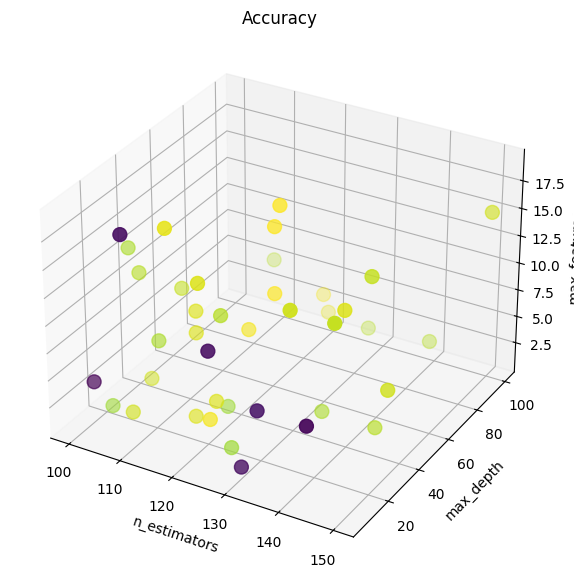

In [146]:
#Plot l'accuracy en fonction des 3 paramètres n_estimators, max_depth et max_features (figure en 3D)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

n_estimators = [x[0] for x in models]
max_depth = [x[1] if x[1] != None else 100 for x in models]
max_features = [x[2] if x[2] != 'sqrt' else 2**0.5 for x in models] #srqt(2) car on a deux features : peuplier ou non peuplier
accuracy = [x[3] for x in models]

ax.scatter(n_estimators, max_depth, max_features, c=accuracy, cmap='viridis', s=100)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('max_features')
ax.set_title('Accuracy')

plt.show()



### Remarque

Le finetuning par randomized search cross validation n'a pas apporté beaucoup d'amélioration. On reste sur du 98% d'accuracy. Il est vrai qu'il est difficile de faire mieux avec une accuracy déjà aussi haute. Nous avons tracé en 3 dimensions les résultats du finetuning avec chaque point reflétant l'accuracy en sortie en fonction des 3 paramètres : max_depth, max_features, n_estimator. Mais avec seulement 40 itérations, nous observons difficilement un cluster où l'accuracy est grand. Il faudrait itérer davantage. 

Hypeparamètres optimaux: (n_estimators=125, max_features=17, max_depth=45, random_state=7)

Dans la suite, nous allons réentrainer un modèle RF avec les paramètres optimaux que nous avons déterminés. 

### a) Sur les données SFFS 

In [492]:
#X_SFFS = X_SFFS.values
num_folds = 10

X_SFFS = X_SFFS.values

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS)):
    X_train, X_val = X_SFFS[train_index], X_SFFS[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=125, max_features=17, max_depth=45, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS, y)
joblib.dump(best_model_cv, 'SFFS_Binary_target_bal_RandomForestClassifier_max_depth=none_max_features=11_n_estimators=105_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_test_sffs.values)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

Fold 0 Accuracy: 0.9528741584671155
Fold 1 Accuracy: 0.9515794924909373
Fold 2 Accuracy: 0.9502848265147592
Fold 3 Accuracy: 0.9564992232004143
Fold 4 Accuracy: 0.9471776281719316
Fold 5 Accuracy: 0.9492490937338167
Fold 6 Accuracy: 0.9489901605385811
Fold 7 Accuracy: 0.9515794924909373
Fold 8 Accuracy: 0.9528619528619529
Fold 9 Accuracy: 0.9531209531209531
Meilleur score d'exactitude : 0.96
Caractéristiques du meilleur modèle :  RandomForestClassifier(max_depth=45, max_features=17, n_estimators=125,
                       random_state=7)
Temps de l'entrainement total:  116.54832816123962
Test Set Accuracy: 0.7019381875327396


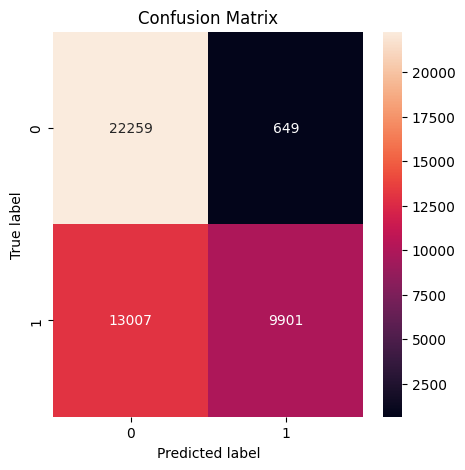

              precision    recall  f1-score   support

         0.0       0.63      0.97      0.77     22908
         1.0       0.94      0.43      0.59     22908

    accuracy                           0.70     45816
   macro avg       0.78      0.70      0.68     45816
weighted avg       0.78      0.70      0.68     45816



In [493]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

### b) Sur les données SFFS avec PCA

In [494]:
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs_pca = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_sffs_pca)):
    X_train, X_val = X_sffs_pca[train_index], X_sffs_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=125, max_features=17, max_depth=45, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_sffs_pca, y)
joblib.dump(best_model_cv, 'PCA_SFFS_Binary_target_bal_RandomForestClassifier_max_depth=none_max_features=11_n_estimators=105_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_test_sffs_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

Fold 0 Accuracy: 0.918953909891248
Fold 1 Accuracy: 0.914810978767478
Fold 2 Accuracy: 0.9174003107198343
Fold 3 Accuracy: 0.9181771103055412
Fold 4 Accuracy: 0.9119627136198861
Fold 5 Accuracy: 0.916882444329363
Fold 6 Accuracy: 0.9142931123770067
Fold 7 Accuracy: 0.9155877783531848
Fold 8 Accuracy: 0.9166019166019166
Fold 9 Accuracy: 0.9186739186739187
Meilleur score d'exactitude : 0.92
Caractéristiques du meilleur modèle :  RandomForestClassifier(max_depth=45, max_features=17, n_estimators=125,
                       random_state=7)
Temps de l'entrainement total:  76.73219728469849
Test Set Accuracy: 0.6240614632442815


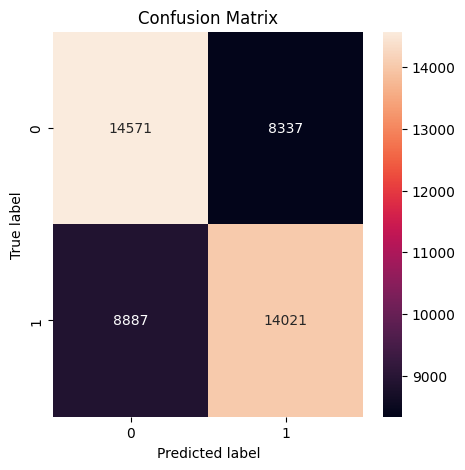

              precision    recall  f1-score   support

         0.0       0.62      0.64      0.63     22908
         1.0       0.63      0.61      0.62     22908

    accuracy                           0.62     45816
   macro avg       0.62      0.62      0.62     45816
weighted avg       0.62      0.62      0.62     45816



In [495]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

### c) Avec SFFS "accuracy" based

(Features issues de la dernière partie du Notebook : Autres/SFFS "Accuracy" based

Fold 0 Accuracy: 0.9614189539098913
Fold 1 Accuracy: 0.9634904194717763
Fold 2 Accuracy: 0.9609010875194199
Fold 3 Accuracy: 0.9642672190574831
Fold 4 Accuracy: 0.9575349559813569
Fold 5 Accuracy: 0.9637493526670119
Fold 6 Accuracy: 0.9577938891765925
Fold 7 Accuracy: 0.9645261522527188
Fold 8 Accuracy: 0.9647759647759647
Fold 9 Accuracy: 0.9637399637399637
Meilleur score d'exactitude : 0.96
Caractéristiques du meilleur modèle :  RandomForestClassifier(max_depth=45, max_features=17, n_estimators=125,
                       random_state=7)
Temps de l'entrainement total:  109.66396188735962
Test Set Accuracy: 0.7328007682905535


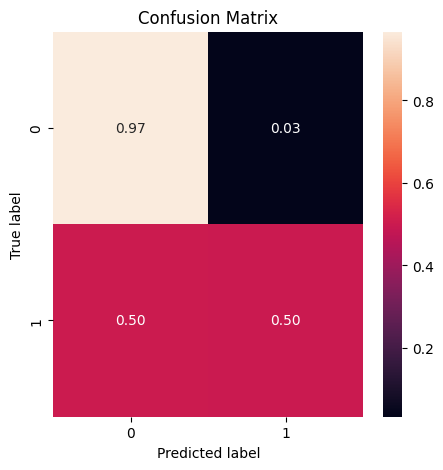

              precision    recall  f1-score   support

         0.0       0.66      0.97      0.78     22908
         1.0       0.94      0.50      0.65     22908

    accuracy                           0.73     45816
   macro avg       0.80      0.73      0.72     45816
weighted avg       0.80      0.73      0.72     45816



In [507]:
X_SFFS_2018 = X[['05/02', '06/05', '05/07', '25/07', '12/11']]
X_SFFS_2018 = X_SFFS_2018.values
X_test_SFFS_2018 = X_test[['05/02', '06/05', '05/07', '25/07', '12/11']]

# cross validation
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs = []

best_accuracy_cv = 0.0

best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS_2018)):
    X_train, X_val = X_SFFS_2018[train_index], X_SFFS_2018[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=125, max_features=17, max_depth=45, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS_2018, y)

#joblib.dump(best_model_cv, 'SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_test_SFFS_2018.values)
accuracy_test = accuracy_score(y_test.values, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

#Matrice de confusion

cm = confusion_matrix(y_test.values, y_pred_test, labels=[0,1], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))




# II - Données Super résolues

A présent, on va réentrainer des modèles RF sur les images super-résolues, passant d'une résolution de 10m à 5m. 

A noter que les données super résolues ne comprennent que 5 dates. Ces dates ont été choisies à l'issue de la SFFS basée sur le recall.

Dû à des contraintes techniques (nuage à éviter, facteurs liés au parcours du satellite), les dates ont parfois des décalages de quelques jours. Néanmoins, l'impact devrait être négligeable, nous devrions tout de même observer de meilleures performances des modèles RF avec la super résolution. 

### a) Trainset

In [80]:
csv_data_path = 'data_30TYT_31TCJ_31UEQ_SR.csv'
data_SR = pd.read_csv(csv_data_path)

data_SR.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496036 entries, 0 to 496035
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         496036 non-null  object 
 1   CODE_TFV   496036 non-null  object 
 2   TFV        496036 non-null  object 
 3   TFV_G11    496036 non-null  object 
 4   ESSENCE    496036 non-null  object 
 5   ID_plot    496036 non-null  int64  
 6   Classe     496036 non-null  int64  
 7   Dep        496036 non-null  int64  
 8   layer      496036 non-null  object 
 9   path       496036 non-null  object 
 10  originfid  496036 non-null  int64  
 11  value_0    496036 non-null  float64
 12  value_1    496036 non-null  float64
 13  value_2    496036 non-null  float64
 14  value_3    496036 non-null  float64
 15  value_4    496036 non-null  float64
dtypes: float64(5), int64(4), object(7)
memory usage: 60.6+ MB


In [81]:
print(data_SR.value_counts('Classe'))

Classe
1    77285
2    77285
3    77285
4    77285
5    77285
6    77285
8    32326
Name: count, dtype: int64


In [82]:
#on retire les No data (=0)
data_SR.drop(data_SR[data_SR['value_0']==0].index, inplace=True)

#on retire les colonnes inutiles
data_SR = data_SR.drop(columns=['ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot','Dep', 'layer', 'path', 'originfid'])

#on renomme les colonnes
dates_sffs = ['05/06', '23/10', '25/07', '24/08', '16/04']
for i in range(5):
    data_SR = data_SR.rename(columns={f'value_{i}': dates_sffs[i]})


#on met tous les non peupliers (Classe !=1) ensemble
data_SR['Classe'] = data_SR['Classe'].apply(lambda x: 0 if x != 1 else 1)

# on rééquilibre les classes avec classe 1 qui garde tous ses échantillons et les autres classes qui en perdent, on undersample aléatoirement
data_SR = data_SR.groupby('Classe').apply(lambda x: x.sample(n=data_SR['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)

#on shuffle
data_SR = data_SR.sample(frac=1, random_state=7).reset_index(drop=True)

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_15144\1325996951.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_SR = data_SR.groupby('Classe').apply(lambda x: x.sample(n=data_SR['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


In [83]:
data_SR.value_counts('Classe')

Classe
0    77245
1    77245
Name: count, dtype: int64

In [84]:
data_SR.head(15)

Classe   05/06   23/10   25/07   24/08   16/04
0        1   134.0  1917.0  1926.0  1572.0   322.0
1        1  2057.0  2497.0  2417.0  2279.0  -385.0
2        0  1633.0  1844.0  1589.0  1330.0    62.0
3        1   683.0  1307.0   916.0   851.0 -2440.0
4        0    26.0  2092.0  1879.0  1598.0   734.0
5        0 -1637.0  2921.0  2223.0  2179.0 -2891.0
6        1  -778.0  2480.0  2474.0  2410.0 -1601.0
7        1   118.0  2138.0  2332.0  2286.0    60.0
8        0  -749.0     7.0  -279.0  -356.0  -329.0
9        1  -819.0  2259.0  2775.0  2216.0   539.0
10       1    55.0  2059.0  2003.0   866.0 -1047.0
11       1  1201.0  1770.0  1549.0  1638.0  1560.0
12       0  -805.0  1491.0  1494.0  1054.0   376.0
13       0  -240.0  1141.0   971.0   990.0   661.0
14       1   936.0  2438.0  2283.0  1842.0  -304.0

### Pi2 médians et interquartiles

<Figure size 640x480 with 0 Axes>

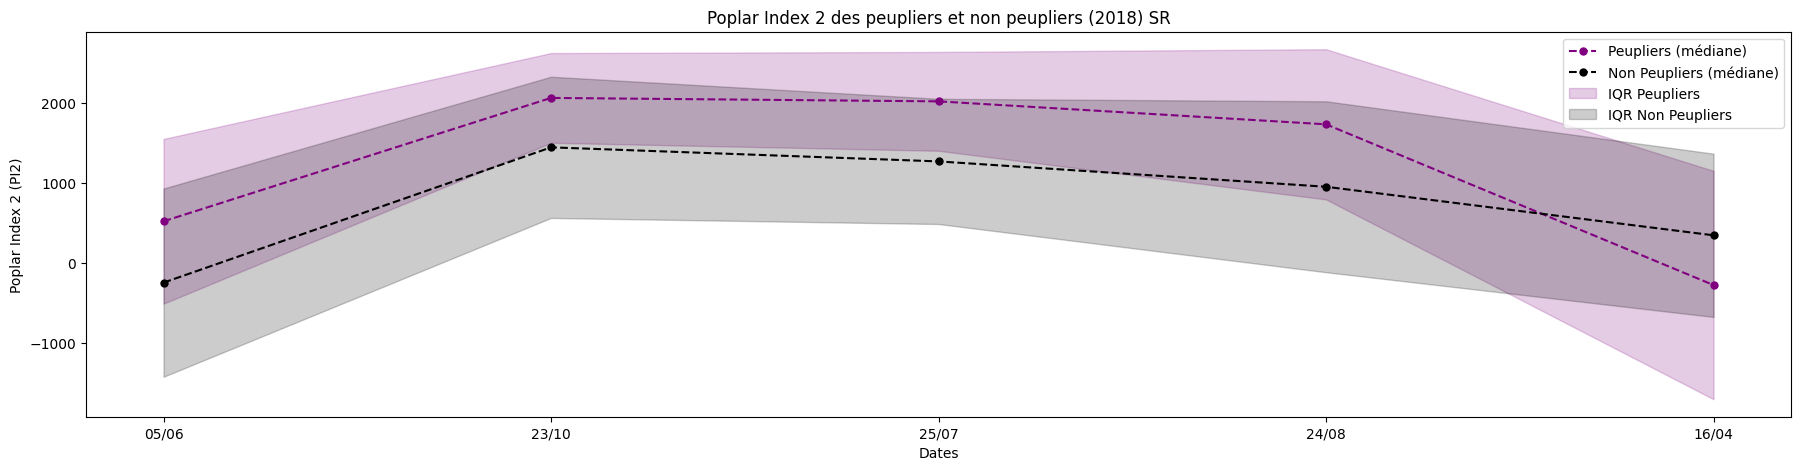

<Figure size 640x480 with 0 Axes>

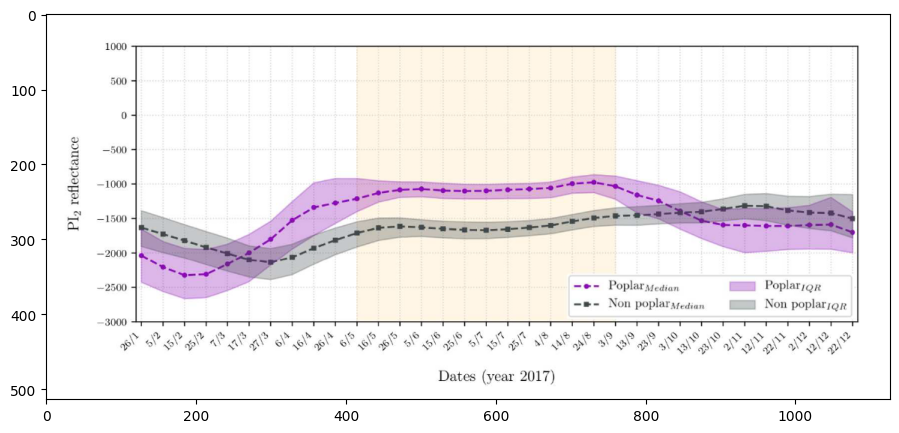

In [85]:
#On trace les PI2 médians avec les interquartiles des peupliers et non peupliers
peupliers_SR = data_SR[data_SR['Classe'] == 1]
peupliers_SR = peupliers_SR.drop(columns=['Classe'])

non_peupliers_SR = data_SR[data_SR['Classe'] == 0]
non_peupliers_SR = non_peupliers_SR.drop(columns=['Classe'])

peupliers_median_SR = peupliers_SR.median()
non_peupliers_median_SR = non_peupliers_SR.median()

peupliers_iqr_SR = peupliers_SR.quantile(0.75) - peupliers_SR.quantile(0.25)
non_peupliers_iqr_SR = non_peupliers_SR.quantile(0.75) - non_peupliers_SR.quantile(0.25)

plt.figure(18)
plt.figure(figsize=(22, 5))
plt.plot(dates_sffs,peupliers_median_SR, label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates_sffs, non_peupliers_median_SR, label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates_sffs, peupliers_median_SR - peupliers_iqr_SR, peupliers_median_SR + peupliers_iqr_SR, color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates_sffs, non_peupliers_median_SR - non_peupliers_iqr_SR, non_peupliers_median_SR + non_peupliers_iqr_SR, color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) SR')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()

#figure de la diapo
plt.figure(19)
plt.figure(figsize=(22, 5))
img = plt.imread('Pi2_2017.png')
plt.imshow(img)
plt.show()


In [86]:
#On split en features et label
X_SR = data_SR.drop(columns=['Classe'])
y_SR = data_SR['Classe']

### PCA sur les données SR 

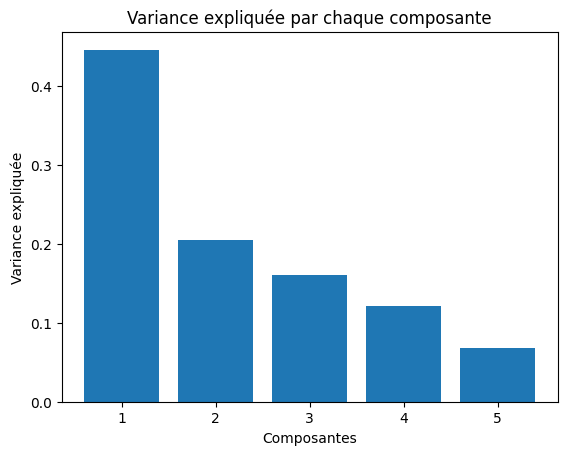

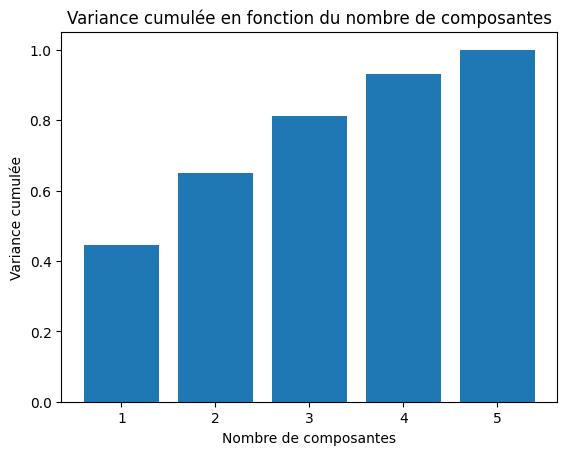

<Figure size 640x480 with 0 Axes>

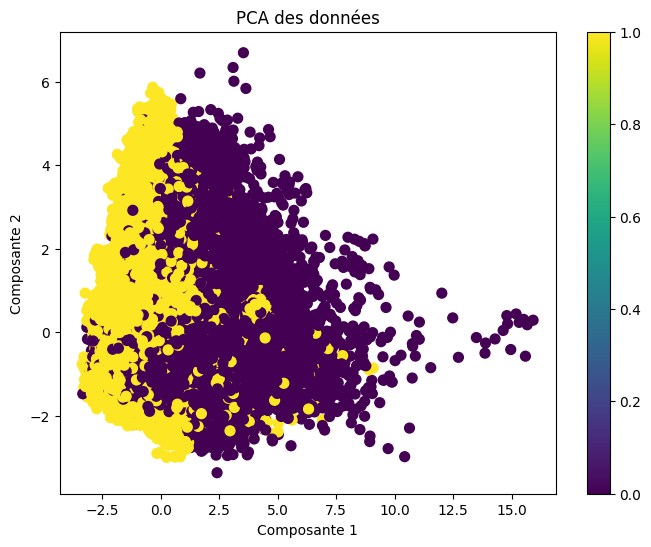

In [87]:
scaler = StandardScaler()
X_SR_scaled = scaler.fit_transform(X_SR)

pca = PCA()

X_SR_pca = pca.fit_transform(X_SR_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance

cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

plt.figure(20)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

plt.figure(21)
plt.bar(range(1, len(cum_explained_variance)+1), cum_explained_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Variance cumulée en fonction du nombre de composantes')
plt.show()

plt.figure(22)
plt.figure(figsize=(8, 6))
plt.scatter(X_SR_pca[:, 0], X_SR_pca[:, 1], c=y_SR, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

X_SR_pca = X_SR_pca[:, :2]

### b) Testset

In [88]:
#donneés test sr
peupliers_csv_data_path = 'data_30TYQ_peupliers_SR.csv'
peupliers_csv_data_path_aug = 'data_30TYQ_peupliers_AUG_SR.csv'

peupliers_data_SR_test = pd.read_csv(peupliers_csv_data_path)
peupliers_data_SR_test_aug = pd.read_csv(peupliers_csv_data_path_aug)

peupliers_data_SR_test = pd.concat([peupliers_data_SR_test, peupliers_data_SR_test_aug], ignore_index=True)

non_peupliers_csv_data_path = "data_30TYQ_non_peupliers_SR.csv"
non_peupliers_data_SR_test = pd.read_csv(non_peupliers_csv_data_path)

peupliers_data_SR_test['Classe'] = pd.DataFrame(np.ones(peupliers_data_SR_test.shape[0]), columns=['Classe'])

data_SR_test = pd.concat([peupliers_data_SR_test, non_peupliers_data_SR_test], ignore_index=True)

data_SR_test = data_SR_test.sample(frac=1, random_state=7).reset_index(drop=True)

data_SR_test['age'] = data_SR_test['Annee_pl'].apply(lambda x: 2018 - x)

data_SR_test.to_csv('test_set_tuile_4_GT_SR.csv', index=False)

data_SR_test.drop(data_SR_test[data_SR_test['value_0']==0].index, inplace=True) #on retire les échantillons avec features nuls

for i in range(5):
    data_SR_test = data_SR_test.rename(columns={f'value_{i}': dates_sffs[i]})

data_SR_test['Classe'] = data_SR_test['Classe'].apply(lambda x: 0 if x != 1 else x)

data_SR_test = data_SR_test.groupby('Classe').apply(lambda x: x.sample(n=data_SR_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)

data_SR_test = data_SR_test.sample(frac=1, random_state=7).reset_index(drop=True)

data_SR_test.info()

print(data_SR_test.value_counts('Classe'))

X_SR_test = data_SR_test.drop(columns=['Classe','Cultivars', 'Annee_pl', 'id', 'originfid', 'age'])

y_SR_test = data_SR_test['Classe']

X_SR_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182240 entries, 0 to 182239
Data columns (total 11 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Annee_pl   67489 non-null   float64
 1   Cultivars  67489 non-null   object 
 2   05/06      182240 non-null  float64
 3   23/10      182240 non-null  float64
 4   25/07      182240 non-null  float64
 5   24/08      182240 non-null  float64
 6   16/04      182240 non-null  float64
 7   id         23631 non-null   float64
 8   originfid  23631 non-null   float64
 9   Classe     182240 non-null  float64
 10  age        67489 non-null   float64
dtypes: float64(10), object(1)
memory usage: 15.3+ MB
Classe
0.0    91120
1.0    91120
Name: count, dtype: int64


C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_15144\2221125629.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_SR_test = data_SR_test.groupby('Classe').apply(lambda x: x.sample(n=data_SR_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


05/06   23/10   25/07   24/08   16/04
0    22.0  1616.0  1228.0  1201.0  -123.0
1  1824.0  2349.0  1808.0  1803.0   -47.0
2    95.0    53.0  -818.0   -97.0 -2067.0
3    -1.0  2045.0  1983.0  1738.0  -416.0
4 -1256.0   581.0   -46.0 -2935.0 -1468.0

In [89]:
y_SR_test.value_counts()

Classe
0.0    91120
1.0    91120
Name: count, dtype: int64

<Figure size 640x480 with 0 Axes>

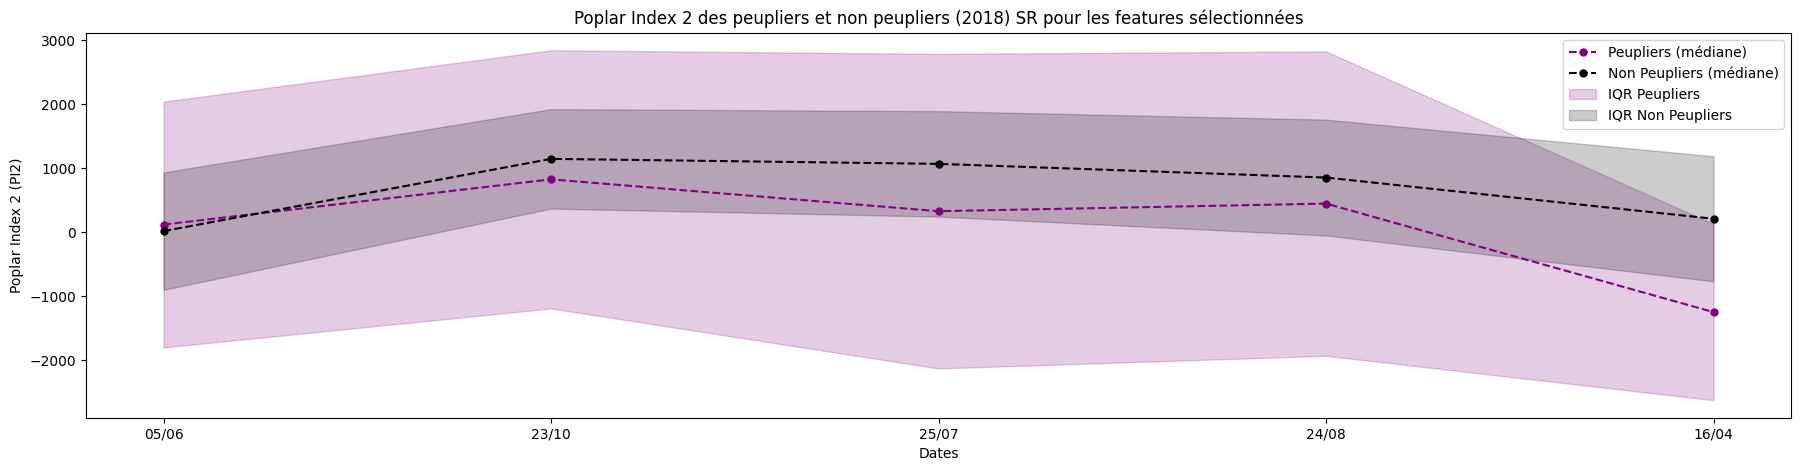

In [90]:
#Pi2 médian et interquartile pour les features sélectionnées sur les données de test
peupliers_SR_test = X_SR_test[y_SR_test == 1]
non_peupliers_SR_test = X_SR_test[y_SR_test == 0]

peupliers_SR_test = pd.DataFrame(peupliers_SR_test)
non_peupliers_SR_test = pd.DataFrame(non_peupliers_SR_test)

peupliers_median_SR_test = peupliers_SR_test.median()
non_peupliers_median_SR_test = non_peupliers_SR_test.median()

peupliers_iqr_SR_test = peupliers_SR_test.quantile(0.75) - peupliers_SR_test.quantile(0.25)
non_peupliers_iqr_SR_test = non_peupliers_SR_test.quantile(0.75) - non_peupliers_SR_test.quantile(0.25)

plt.figure(22)
plt.figure(figsize=(22, 5))
plt.plot(dates_sffs,peupliers_median_SR_test, label='Peupliers (médiane)', color='purple', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.plot(dates_sffs, non_peupliers_median_SR_test, label='Non Peupliers (médiane)', color='black', linestyle='dashed', linewidth=1.5, marker='o', markersize=5)
plt.fill_between(dates_sffs, peupliers_median_SR_test - peupliers_iqr_SR_test, peupliers_median_SR_test + peupliers_iqr_SR_test, color='purple', alpha=0.2, label='IQR Peupliers')
plt.fill_between(dates_sffs, non_peupliers_median_SR_test - non_peupliers_iqr_SR_test, non_peupliers_median_SR_test + non_peupliers_iqr_SR_test, color='black', alpha=0.2, label='IQR Non Peupliers')
plt.title('Poplar Index 2 des peupliers et non peupliers (2018) SR pour les features sélectionnées')
plt.xlabel("Dates")
plt.ylabel("Poplar Index 2 (PI2)")
plt.legend()
plt.show()


### PCA des données de test SR

In [91]:
scaler = StandardScaler()
X_SR_test_scaled = scaler.fit_transform(X_SR_test)

pca = PCA()
X_SR_test_pca = pca.fit_transform(X_SR_test_scaled)

X_SR_test_pca = X_SR_test_pca[:, :2]

## 2) Cross Validation (10fold) des modèles RF

### a) Sur les données SR brutes 

Ici, on utilisera les paramètres optimaux déterminés dans la partie précédente. 

In [92]:
X_SR = X_SR.values
y_SR = y_SR.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SR)):
    X_train, X_val = X_SR[train_index], X_SR[val_index]
    y_train, y_val = y_SR[train_index], y_SR[val_index]

    rf_model = RandomForestClassifier(n_estimators=125, max_features=17, max_depth=45, random_state=7) 

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SR, y_SR)

joblib.dump(best_model_cv, 'SR_Binary_target_bal_RandomForestClassifier_max_depth=none_max_features=11_n_estimators=105_random_state=7.pkl')


y_pred_test = best_model_cv.predict(X_SR_test.values)
y_pred_test_proba = best_model_cv.predict_proba(X_SR_test.values)
accuracy_test = accuracy_score(y_SR_test.values, y_pred_test)

print("Test Set Accuracy:", accuracy_test)


Fold 0 Accuracy: 0.9079552074567934
Fold 1 Accuracy: 0.9106091009126804
Fold 2 Accuracy: 0.9126157032817658
Fold 3 Accuracy: 0.9126157032817658
Fold 4 Accuracy: 0.9102207262605994
Fold 5 Accuracy: 0.9140397436727297
Fold 6 Accuracy: 0.9131982652598873
Fold 7 Accuracy: 0.9124862450644055
Fold 8 Accuracy: 0.9135219108032883
Fold 9 Accuracy: 0.9116447666515632
Meilleur score d'exactitude : 0.91
Caractéristiques du meilleur modèle :  RandomForestClassifier(max_depth=45, max_features=17, n_estimators=125,
                       random_state=7)
Temps de l'entrainement total:  514.3528864383698
Test Set Accuracy: 0.623408691834943


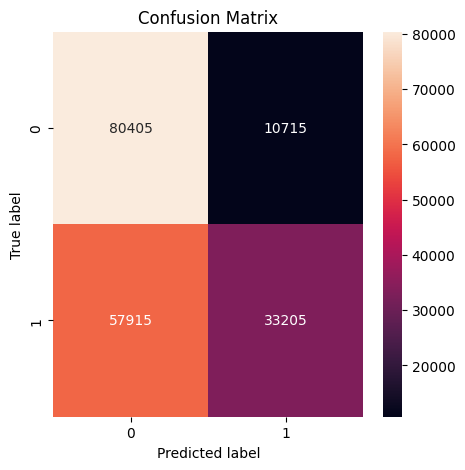

              precision    recall  f1-score   support

         0.0       0.58      0.88      0.70     91120
         1.0       0.76      0.36      0.49     91120

    accuracy                           0.62    182240
   macro avg       0.67      0.62      0.60    182240
weighted avg       0.67      0.62      0.60    182240



In [93]:
#Matrice de confusion
cm = confusion_matrix(y_SR_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_SR_test, y_pred_test))

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_15144\2469069934.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['age'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['age']
C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_15144\2469069934.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['Cultivars'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['Cultivars']
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeW

['I214 - LENA' 'Raspalje-Alcinde' nan 'Raspalje - I45/51'
 'Polargo - Koster' 'Soligo' 'Polargo - Lambro' 'Raspalje-Polargo-I45/51'
 'Raspalje' 'Koster' 'Polargo' 'I45/51' 'I214' 'Koster-Polargo-I45/51'
 'Koster - I45/51' 'Dorskamp' 'Koster - Raspalje' 'Dorskamp-I45/5'
 'Alcinde' 'Koster-Polargo-Rona' 'Raspalje - Soligo'
 'Polarco-I45/51-Dvina' 'I45/51-Dorskamd-Alcinde' 'Dorskamp-Korster'
 'Polargo - A4A']


d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret

<Figure size 640x480 with 0 Axes>

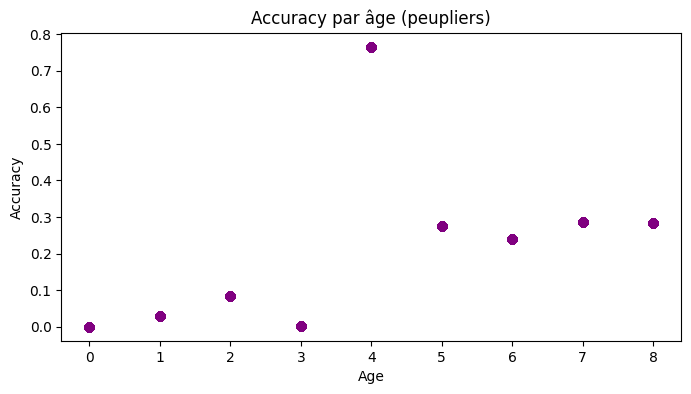

<Figure size 640x480 with 0 Axes>

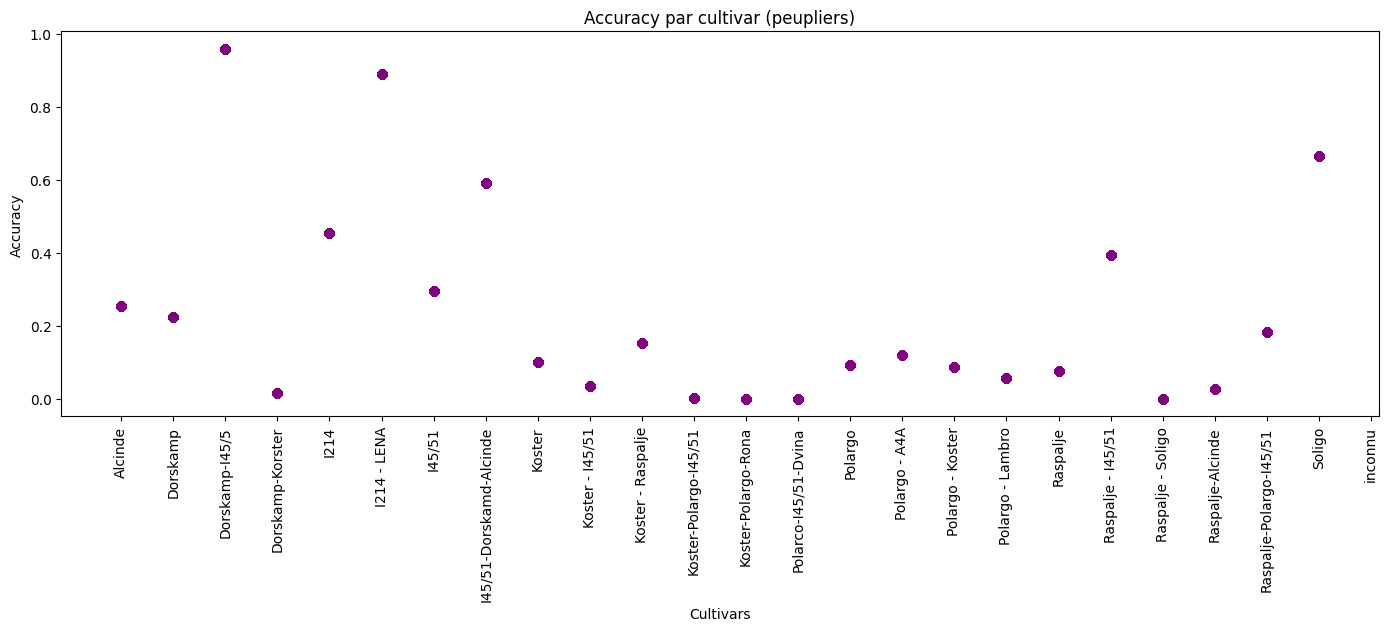

<Figure size 640x480 with 0 Axes>

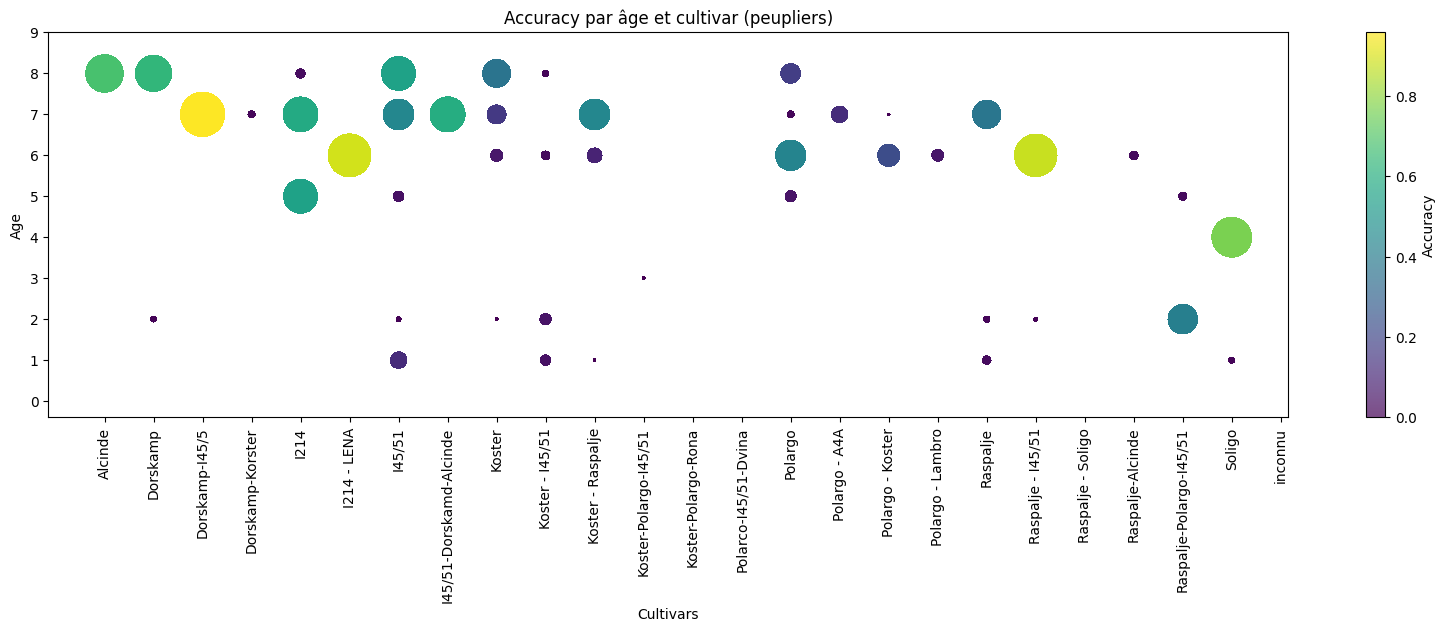

<Figure size 640x480 with 0 Axes>

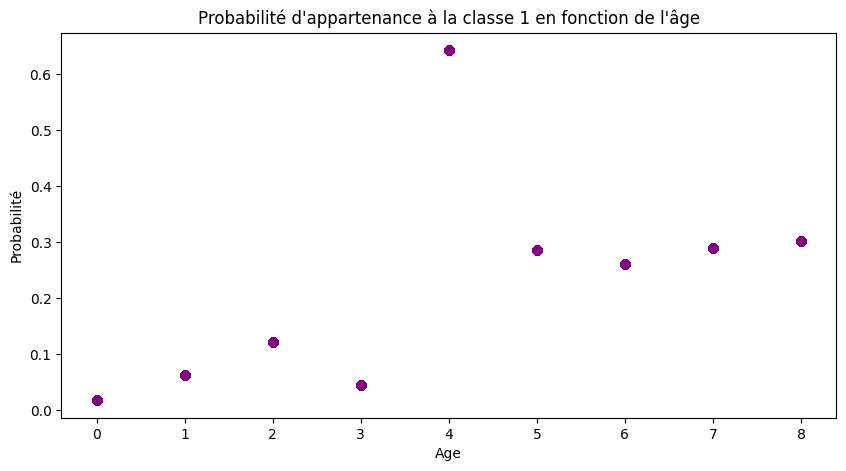

<Figure size 640x480 with 0 Axes>

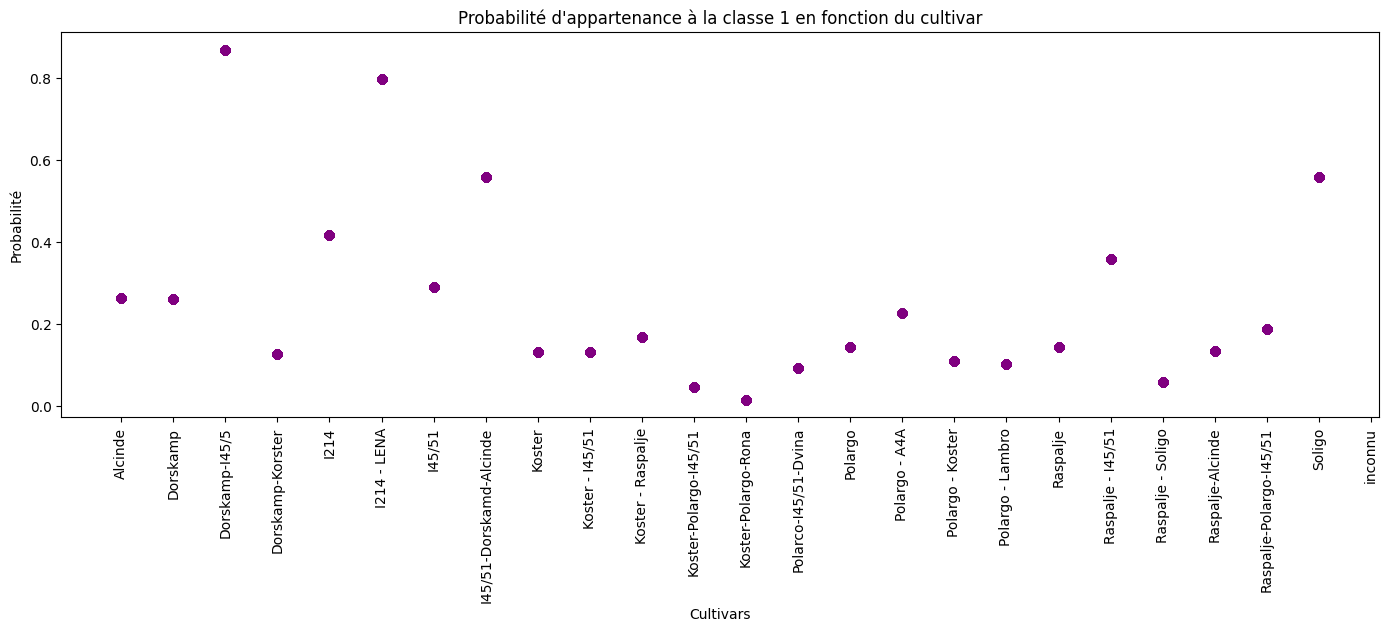

<Figure size 640x480 with 0 Axes>

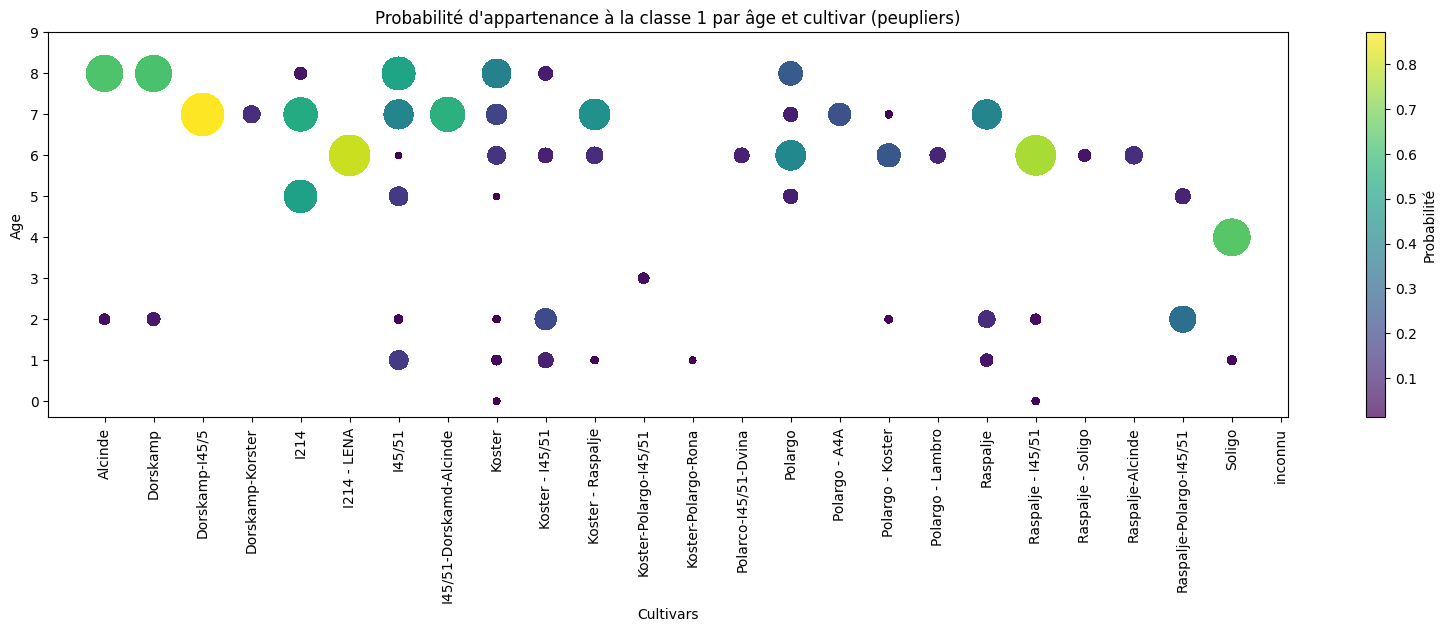

In [441]:
#On observe la qualité de prédiction par âge de plantation de peupliers
peupliers_pred_avec_SR = pd.DataFrame(y_pred_test, columns=['Classe'])
peupliers_pred_avec_SR['Probabilité'] = y_pred_test_proba[:,1]
y_test_avec_SR = pd.DataFrame(y_SR_test.values, columns=['Classe'])

peupliers_pred_avec_SR = peupliers_pred_avec_SR[y_test_avec_SR['Classe'] == 1]
peupliers_pred_avec_SR['age'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['age']
peupliers_pred_avec_SR['Cultivars'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['Cultivars']
peupliers_pred_avec_SR = peupliers_pred_avec_SR.reset_index(drop=True)

y_test_peupliers = y_test_avec_SR[y_test_avec_SR['Classe'] == 1]
y_test_peupliers['age'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['age']
y_test_peupliers['Cultivars'] = data_SR_test[y_test_avec_SR['Classe'] == 1]['Cultivars']
y_test_peupliers = y_test_peupliers.reset_index(drop=True)

#print(peupliers_pred.value_counts('age'))
#print(y_test_peupliers.value_counts('age'))

#On rassemble les cultivars dupliqués
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'

y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "I45/51 - rASPALJE", "Cultivars"] = 'I45/51 - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-I45/51", "Cultivars"] = 'Koster - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == "Koster-Raspalje", "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Raspalje-Koster', "Cultivars"] = 'Koster - Raspalje'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Koster - Polargo', "Cultivars"] = 'Polargo - Koster'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'I45/51 - Raspalje', "Cultivars"] = 'Raspalje - I45/51'
y_test_peupliers.loc[y_test_peupliers["Cultivars"] == 'Polargo-Raspalje-I45/51', "Cultivars"] = 'Raspalje-Polargo-I45/51'

print(peupliers_pred_avec_SR["Cultivars"].unique())

for age in peupliers_pred_avec_SR['age'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR['age'] == age, 'Accuracy par age'] = accuracy_score(peupliers_pred_avec_SR[peupliers_pred_avec_SR['age'] == age]['Classe'], y_test_peupliers[y_test_peupliers['age'] == age]['Classe'])

for cultivar in peupliers_pred_avec_SR['Cultivars'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR['Cultivars'] == cultivar, 'Accuracy par cultivar'] = accuracy_score(peupliers_pred_avec_SR[peupliers_pred_avec_SR['Cultivars'] == cultivar]['Classe'], y_test_peupliers[y_test_peupliers['Cultivars'] == cultivar]['Classe'])

for cultivar in peupliers_pred_avec_SR['Cultivars'].unique():
    for age in peupliers_pred_avec_SR['age'].unique():
        #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
        peupliers_pred_avec_SR.loc[(peupliers_pred_avec_SR['Cultivars'] == cultivar) & (peupliers_pred_avec_SR['age'] == age), 'Accuracy par cultivar et age'] = accuracy_score(peupliers_pred_avec_SR[(peupliers_pred_avec_SR['Cultivars'] == cultivar) & (peupliers_pred_avec_SR['age'] == age)]['Classe'], y_test_peupliers[(y_test_peupliers['Cultivars'] == cultivar) & (y_test_peupliers['age'] == age)]['Classe'])

#moyenne de proba d'appartenance à la classe 1 par âge
for age in peupliers_pred_avec_SR['age'].unique():
    peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR['age'] == age, 'Probabilité par âge'] = peupliers_pred_avec_SR[peupliers_pred_avec_SR['age'] == age]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par cultivar
for cultivar in peupliers_pred_avec_SR['Cultivars'].unique():
    peupliers_pred_avec_SR.loc[peupliers_pred_avec_SR['Cultivars'] == cultivar, 'Probabilité par cultivar'] = peupliers_pred_avec_SR[peupliers_pred_avec_SR['Cultivars'] == cultivar]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par âge et par cultivar
for cultivar in peupliers_pred_avec_SR['Cultivars'].unique():
    for age in peupliers_pred_avec_SR['age'].unique():
        peupliers_pred_avec_SR.loc[(peupliers_pred_avec_SR['Cultivars'] == cultivar) & (peupliers_pred_avec_SR['age'] == age), 'Probabilité par cultivar et age'] = peupliers_pred_avec_SR[(peupliers_pred_avec_SR['Cultivars'] == cultivar) & (peupliers_pred_avec_SR['age'] == age)]['Probabilité'].mean()



#remplacer les nan par "inconnu"    
peupliers_pred_avec_SR['Cultivars'] = peupliers_pred_avec_SR['Cultivars'].fillna('inconnu')

#ranger les cultivars par ordre alphabétique (pour l'affichage)
peupliers_pred_avec_SR = peupliers_pred_avec_SR.sort_values('Cultivars')


#plot
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred_avec_SR['age'], peupliers_pred_avec_SR['Accuracy par age'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.title('Accuracy par âge (peupliers)')
plt.show()

plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred_avec_SR['Cultivars'], peupliers_pred_avec_SR['Accuracy par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers
plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred_avec_SR['Cultivars'], peupliers_pred_avec_SR['age'], s=peupliers_pred_avec_SR['Accuracy par cultivar et age']*1000, c=peupliers_pred_avec_SR['Accuracy par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Accuracy')
plt.show()


#proba d'appartenance à la classe 1 en fonction de l'âge
plt.figure(18)
plt.figure(figsize=(10, 5))
plt.scatter(peupliers_pred_avec_SR['age'], peupliers_pred_avec_SR['Probabilité par âge'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction de l\'âge')
plt.show()

#proba d'appartenance à la classe 1 en fonction du cultivar
plt.figure(19)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred_avec_SR['Cultivars'], peupliers_pred_avec_SR['Probabilité par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction du cultivar')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser la probabilité d'appartenance à la classe 1 par âge et par cultivar pour les peupliers
plt.figure(20)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred_avec_SR['Cultivars'], peupliers_pred_avec_SR['age'], s=peupliers_pred_avec_SR['Probabilité par cultivar et age']*1000, c=peupliers_pred_avec_SR['Probabilité par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Probabilité d\'appartenance à la classe 1 par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Probabilité')
plt.show()



### Sans SR vs SR 

<Figure size 640x480 with 0 Axes>

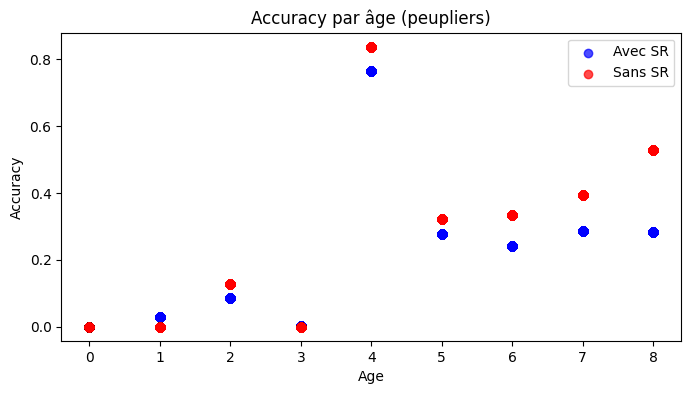

In [95]:
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred_avec_SR['age'], peupliers_pred_avec_SR['Accuracy par age'], color='blue', alpha=0.7)
plt.scatter(peupliers_pred['age'], peupliers_pred['Accuracy par age'], color='red', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.legend(['Avec SR', 'Sans SR'])
plt.title('Accuracy par âge (peupliers)')
plt.show()

<Figure size 640x480 with 0 Axes>

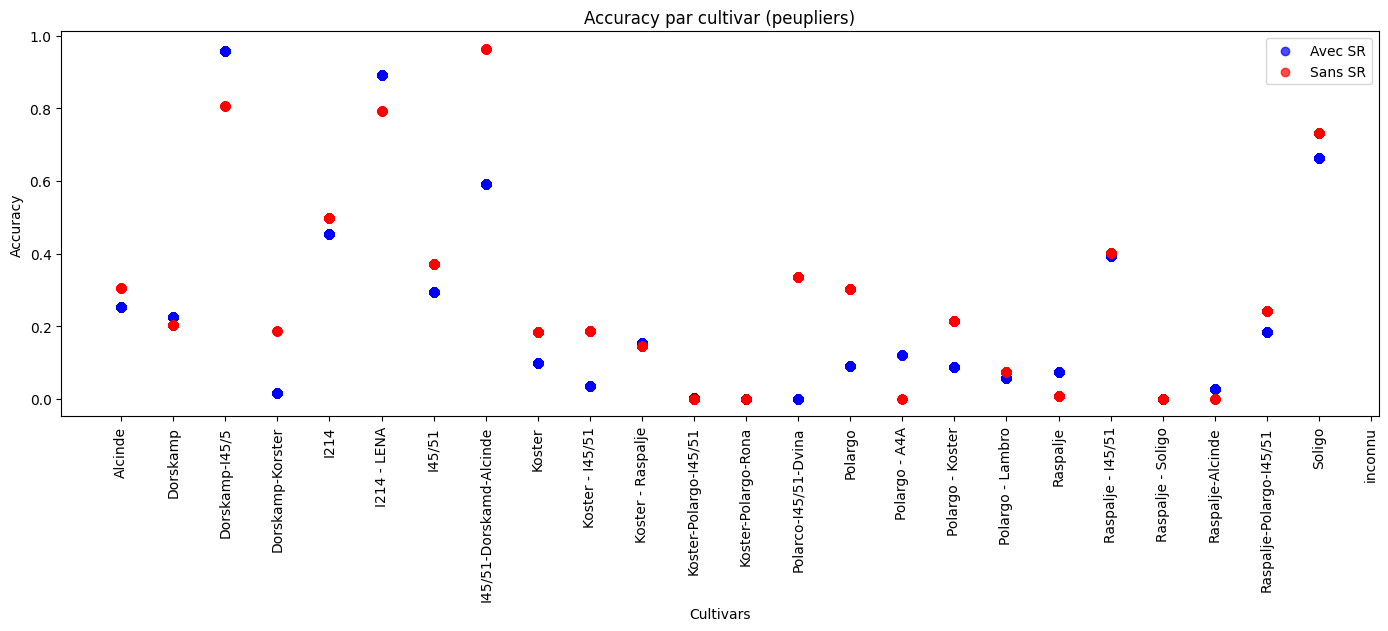

<Figure size 640x480 with 0 Axes>

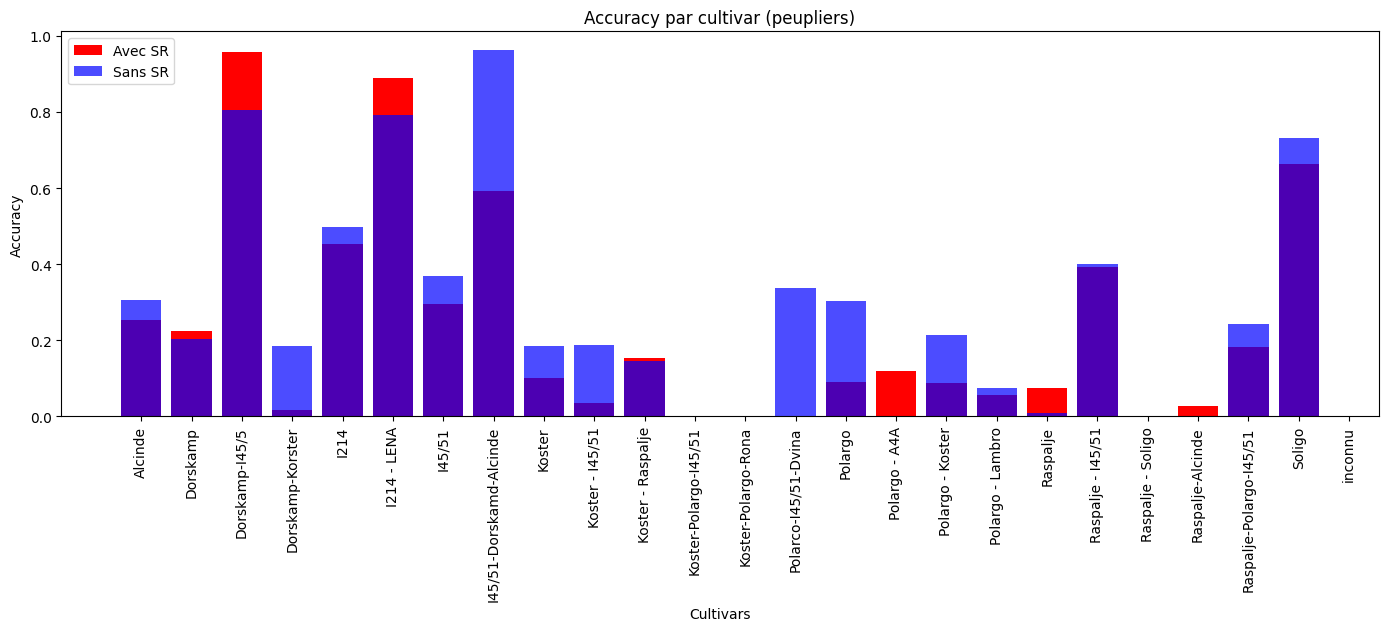

<Figure size 640x480 with 0 Axes>

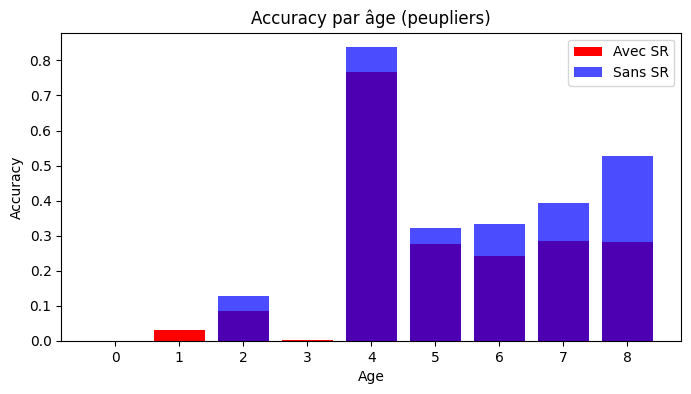

In [450]:
plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred_avec_SR['Cultivars'], peupliers_pred_avec_SR['Accuracy par cultivar'], color='blue', alpha=0.7)
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Accuracy par cultivar'], color='red', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.legend(['Avec SR', 'Sans SR'])
plt.xticks(rotation=90)
plt.show()

#tracer des barres pour visualiser l'accuracy par cultiver avec sr et sans sr et voir où ça superpose
acc_cultivar_SR = list(peupliers_pred_avec_SR.groupby('Cultivars')["Accuracy par cultivar"].unique())
acc_cultivar_sans_SR = list(peupliers_pred.groupby('Cultivars')["Accuracy par cultivar"].unique())
acc_cultivar_SR = [acc_cultivar_SR[i][0] for i in range(len(acc_cultivar_SR))]
acc_cultivar_sans_SR = [acc_cultivar_sans_SR[i][0] for i in range(len(acc_cultivar_sans_SR))]


plt.figure(17)
plt.figure(figsize=(17, 5))
plt.bar(list(peupliers_pred_avec_SR.groupby('Cultivars')["Accuracy par cultivar"].groups.keys()),acc_cultivar_SR, color='red', alpha=1)
plt.bar(list(peupliers_pred.groupby('Cultivars')["Accuracy par cultivar"].groups.keys()),acc_cultivar_sans_SR, color='blue', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.legend(['Avec SR', 'Sans SR'])
plt.xticks(rotation=90)
plt.show()

#pareil pour l'age
acc_age_SR = list(peupliers_pred_avec_SR.groupby('age')["Accuracy par age"].unique())
acc_age_sans_SR = list(peupliers_pred.groupby('age')["Accuracy par age"].unique())
acc_age_SR = [acc_age_SR[i][0] for i in range(len(acc_age_SR))]
acc_age_sans_SR = [acc_age_sans_SR[i][0] for i in range(len(acc_age_sans_SR))]

plt.figure(18)
plt.figure(figsize=(8, 4))
plt.bar(list(peupliers_pred_avec_SR.groupby("age")["Accuracy par age"].groups.keys()), acc_age_SR, color='red', alpha=1)
plt.bar(list(peupliers_pred.groupby("age")["Accuracy par age"].groups.keys()), acc_age_sans_SR, color='blue', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.legend(['Avec SR', 'Sans SR'])
plt.title('Accuracy par âge (peupliers)')
plt.xticks(range(0,9,1))
plt.show()


# Bubble chart sans SR et SR mais qui ne marche pas !

Problème d'affichage, les valeurs sont pas bonnes

LA FIGURE EST PAS BONNE, l'affichage est buguée


C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_15144\3955134418.py:40: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(acc_cultivar_age_SR_CULTIVARS[0], acc_cultivar_age_SR_AGE[0], s=acc_cultivar_age_SR_accuracy[0]*1000, c="red", cmap= "viridis", alpha=0.7)


<Figure size 640x480 with 0 Axes>

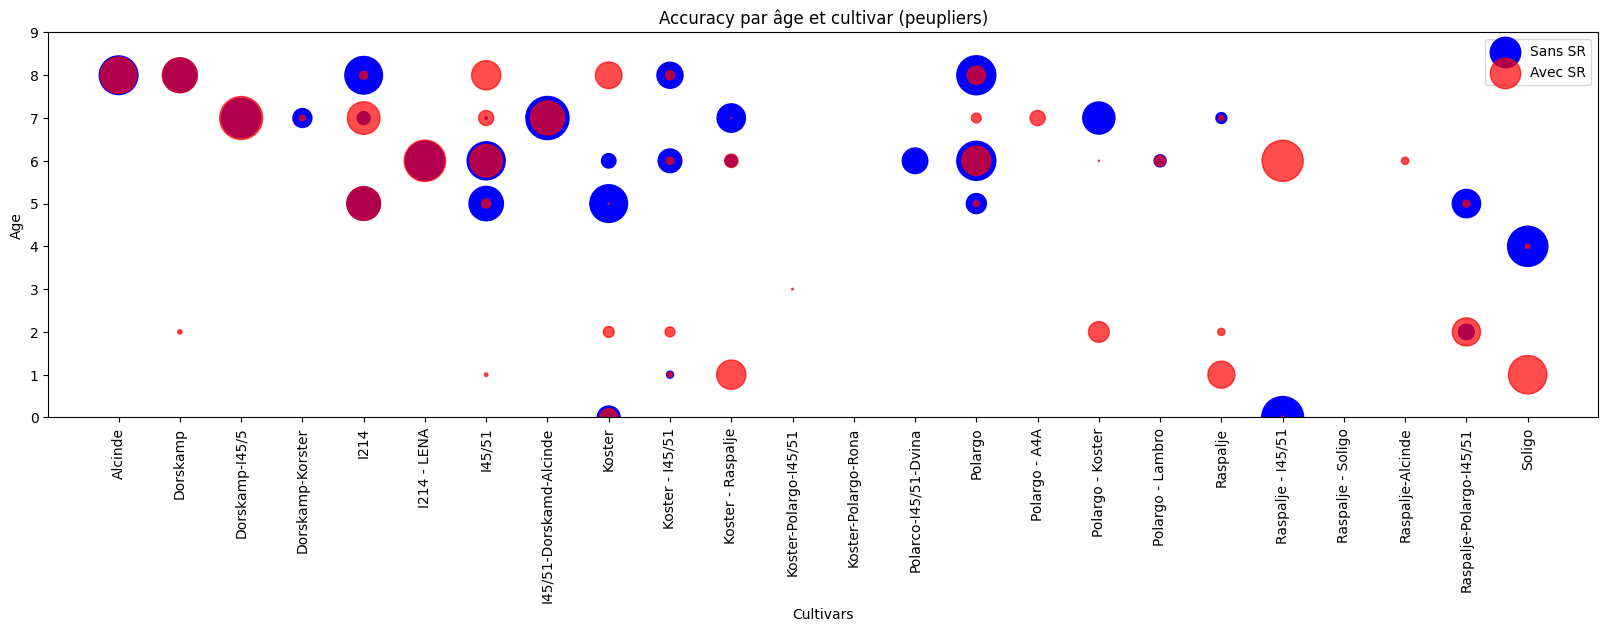

In [453]:
#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers

#tracer des barres pour visualiser l'accuracy par cultiver avec sr et sans sr et voir où ça superpose
acc_cultivar_age_SR_AGE = [val for sublist in list(peupliers_pred_avec_SR.groupby("Cultivars")["age"].unique()) for val in sublist]
acc_cultivar_age_sans_SR_AGE = [val for sublist in list(peupliers_pred.groupby("Cultivars")["age"].unique()) for val in sublist]
acc_cultivar_age_SR_CULTIVARS = [cultivar for cultivar in peupliers_pred_avec_SR['Cultivars'].unique() for i in range(len(peupliers_pred_avec_SR[peupliers_pred_avec_SR['Cultivars'] == cultivar]['age'].unique()))]
acc_cultivar_age_sans_SR_CULTIVARS = [cultivar for cultivar in peupliers_pred['Cultivars'].unique() for i in range(len(peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['age'].unique()))]

#retire les nan
acc_cultivar_age_SR_CULTIVARS = [x for x in acc_cultivar_age_SR_CULTIVARS if x != 'inconnu']
acc_cultivar_age_sans_SR_CULTIVARS = [x for x in acc_cultivar_age_sans_SR_CULTIVARS if x != 'inconnu']

acc_cultivar_age_SR_AGE = [x for x in acc_cultivar_age_SR_AGE if str(x) != 'nan']
acc_cultivar_age_sans_SR_AGE = [x for x in acc_cultivar_age_sans_SR_AGE if str(x) != 'nan']

#dataframe
acc_cultivar_age_SR_AGE = pd.DataFrame(acc_cultivar_age_SR_AGE)
acc_cultivar_age_sans_SR_AGE = pd.DataFrame(acc_cultivar_age_sans_SR_AGE)
acc_cultivar_age_SR_CULTIVARS = pd.DataFrame(acc_cultivar_age_SR_CULTIVARS)
acc_cultivar_age_sans_SR_CULTIVARS = pd.DataFrame(acc_cultivar_age_sans_SR_CULTIVARS)


#print(len(acc_cultivar_age_SR_AGE), len(acc_cultivar_age_sans_SR_AGE), len(acc_cultivar_age_SR_CULTIVARS), len(acc_cultivar_age_sans_SR_CULTIVARS))

acc_cultivar_age_SR_accuracy = list(peupliers_pred_avec_SR.groupby(["Cultivars","age"])["Accuracy par cultivar et age"].unique())
acc_cultivar_age_sans_SR_accuracy = list(peupliers_pred.groupby(["Cultivars","age"])["Accuracy par cultivar et age"].unique())
acc_cultivar_age_SR_accuracy = [acc_cultivar_age_SR_accuracy[i][0] for i in range(len(acc_cultivar_age_SR_accuracy))]
acc_cultivar_age_sans_SR_accuracy =  [acc_cultivar_age_sans_SR_accuracy[i][0] for i in range(len(acc_cultivar_age_sans_SR_accuracy))]

acc_cultivar_age_SR_accuracy = pd.DataFrame(acc_cultivar_age_SR_accuracy)
acc_cultivar_age_sans_SR_accuracy = pd.DataFrame(acc_cultivar_age_sans_SR_accuracy)

#print(len(acc_cultivar_age_SR_accuracy), len(acc_cultivar_age_sans_SR_accuracy))

print("LA FIGURE EST PAS BONNE, l'affichage est buguée")

plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(acc_cultivar_age_sans_SR_CULTIVARS[0], acc_cultivar_age_sans_SR_AGE[0], s=acc_cultivar_age_sans_SR_accuracy*1000, c="blue", alpha=1)
scatter = plt.scatter(acc_cultivar_age_SR_CULTIVARS[0], acc_cultivar_age_SR_AGE[0], s=acc_cultivar_age_SR_accuracy[0]*1000, c="red", cmap= "viridis", alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.legend(['Sans SR', 'Avec SR'])
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))
plt.ylim(0,9)
plt.show()

In [454]:
acc_cultivar_age_SR_CULTIVARS[0], acc_cultivar_age_SR_AGE[0], acc_cultivar_age_SR_accuracy[0]

(0                     Alcinde
 1                     Alcinde
 2                    Dorskamp
 3                    Dorskamp
 4              Dorskamp-I45/5
 5            Dorskamp-Korster
 6                        I214
 7                        I214
 8                        I214
 9                 I214 - LENA
 10                     I45/51
 11                     I45/51
 12                     I45/51
 13                     I45/51
 14                     I45/51
 15                     I45/51
 16    I45/51-Dorskamd-Alcinde
 17                     Koster
 18                     Koster
 19                     Koster
 20                     Koster
 21                     Koster
 22                     Koster
 23                     Koster
 24            Koster - I45/51
 25            Koster - I45/51
 26            Koster - I45/51
 27            Koster - I45/51
 28          Koster - Raspalje
 29          Koster - Raspalje
 30          Koster - Raspalje
 31      Koster-Polargo-I45/51
 32     

### Erreur entre l'accuracy par cultivar sans SR et avec SR

On print à la fin le max et le min

In [456]:
liste =[]
for i,val in enumerate(acc_cultivar_SR):
    #print l'erreur en pourcentage
    print((val - acc_cultivar_sans_SR[i])*100)
    liste.append((val - acc_cultivar_sans_SR[i])*100)

#retirer tous les nombres négatifs
liste = [i for i in liste if i > 0]

#progression max et min entre sans SR et SR
max(liste), min(liste)

-5.197370165159993
2.195579161134109
15.14431239388795
-16.927329599185274
-4.304397829963358
9.90000000000001
-7.465258667361568
-37.21185064935065
-8.460340333888789
-15.25030925420046
0.9197303921568617
0.13637249172024157
0.0
-33.71647509578544
-21.10707039583134
12.0
-12.681092098669506
-1.8638045409352433
6.609195402298851
-0.8512200597075081
0.0
2.7431421446384037
-6.035394648491038
-6.7945143828680665
nan


(15.14431239388795, 0.13637249172024157)

### b) Sur les données SR avec PCA

Ici on utilisera les paramètres par défaut du RF qui avaient donnés de meilleurs résultats que les paramètres optimaux. 

In [152]:
X_SR_pca

X_SR_test_pca
#y_SR_test = y_SR_test.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_pca = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SR_pca)):
    X_train, X_val = X_SR_pca[train_index], X_SR_pca[val_index]
    y_train, y_val = y_SR[train_index], y_SR[val_index]

    rf_model = RandomForestClassifier(n_estimators=125, max_features=17, max_depth=45, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SR_pca, y_SR)

joblib.dump(best_model_cv, 'PCA_SR_Binary_target_bal_RandomForestClassifier_max_depth=none_max_features=11_n_estimators=100_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_SR_test_pca)
y_pred_test_proba = best_model_cv.predict_proba(X_SR_test_pca)
accuracy_test = accuracy_score(y_SR_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)




Fold 0 Accuracy: 0.8152631238267849
Fold 1 Accuracy: 0.8163635186743479
Fold 2 Accuracy: 0.8161693313483074
Fold 3 Accuracy: 0.8198588905430773
Fold 4 Accuracy: 0.819405786782316
Fold 5 Accuracy: 0.8132565214576996
Fold 6 Accuracy: 0.820506181629879
Fold 7 Accuracy: 0.8151983947181047
Fold 8 Accuracy: 0.8210240144993204
Fold 9 Accuracy: 0.8183701210434332
Meilleur score d'exactitude : 0.82
Caractéristiques du meilleur modèle :  RandomForestClassifier(max_depth=45, max_features=17, n_estimators=125,
                       random_state=7)
Temps de l'entrainement total:  363.94889736175537
Test Set Accuracy: 0.3213564530289728


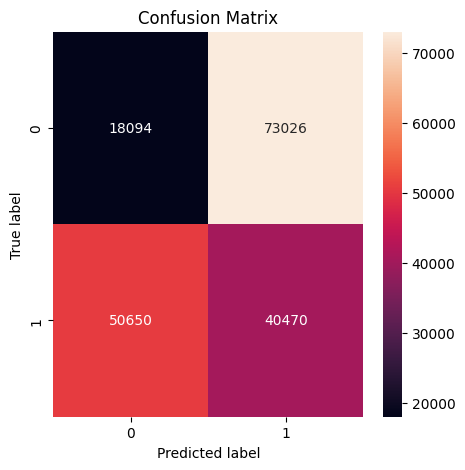

              precision    recall  f1-score   support

         0.0       0.26      0.20      0.23     91120
         1.0       0.36      0.44      0.40     91120

    accuracy                           0.32    182240
   macro avg       0.31      0.32      0.31    182240
weighted avg       0.31      0.32      0.31    182240



In [153]:
#Matrice de confusion
cm = confusion_matrix(y_SR_test.values, y_pred_test)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_SR_test, y_pred_test))


C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_66668\3074946915.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['age'] = data_SR_test[y_test_['Classe'] == 1]['age']
C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_66668\3074946915.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test_peupliers['Cultivars'] = data_SR_test[y_test_['Classe'] == 1]['Cultivars']
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean o

<Figure size 640x480 with 0 Axes>

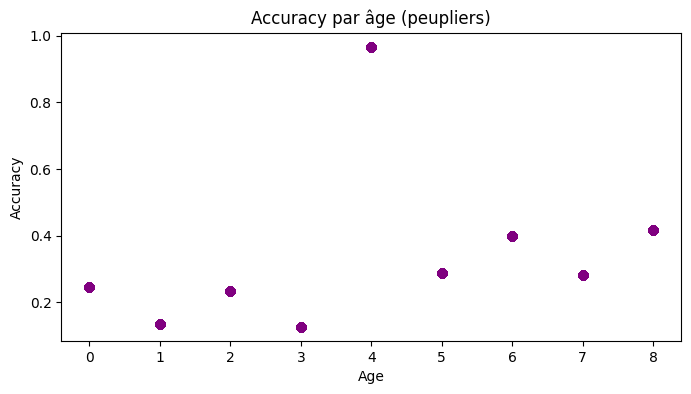

<Figure size 640x480 with 0 Axes>

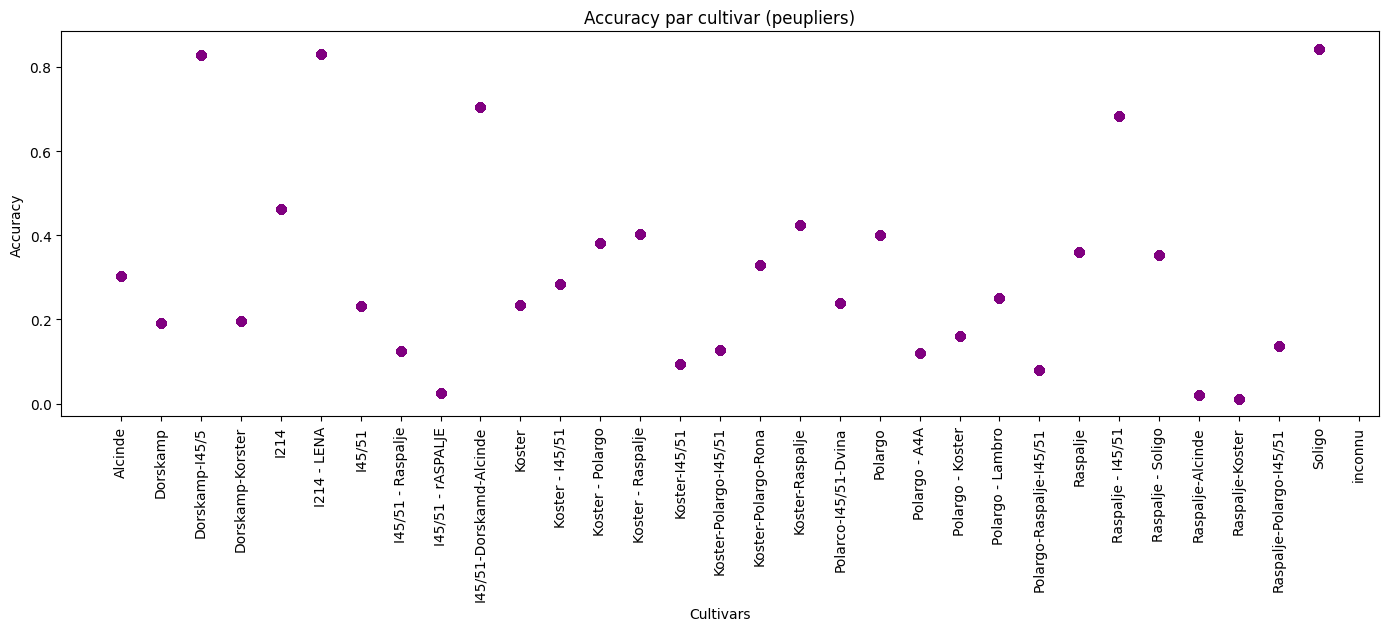

<Figure size 640x480 with 0 Axes>

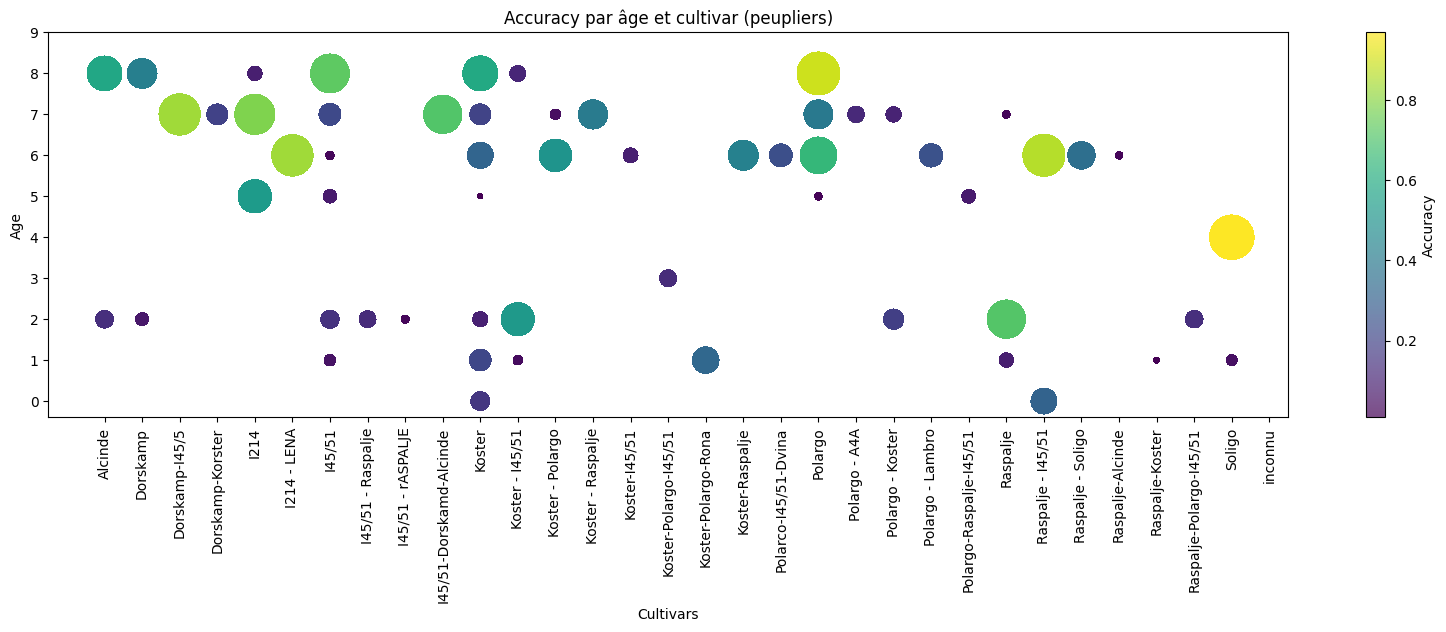

<Figure size 640x480 with 0 Axes>

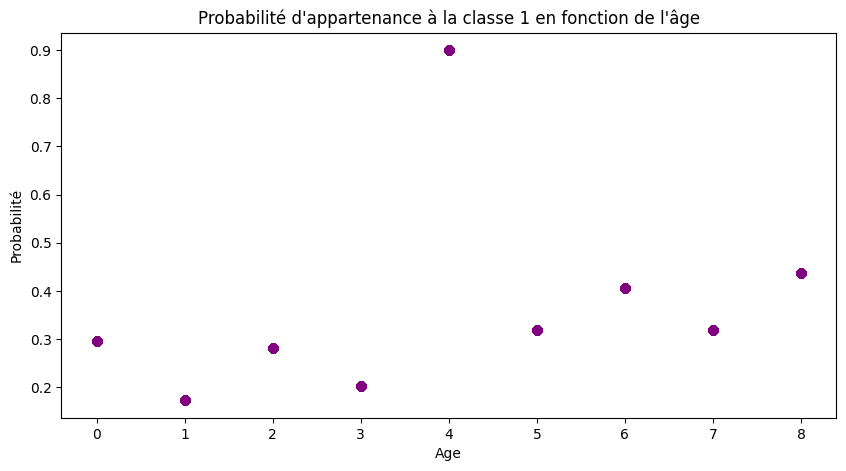

<Figure size 640x480 with 0 Axes>

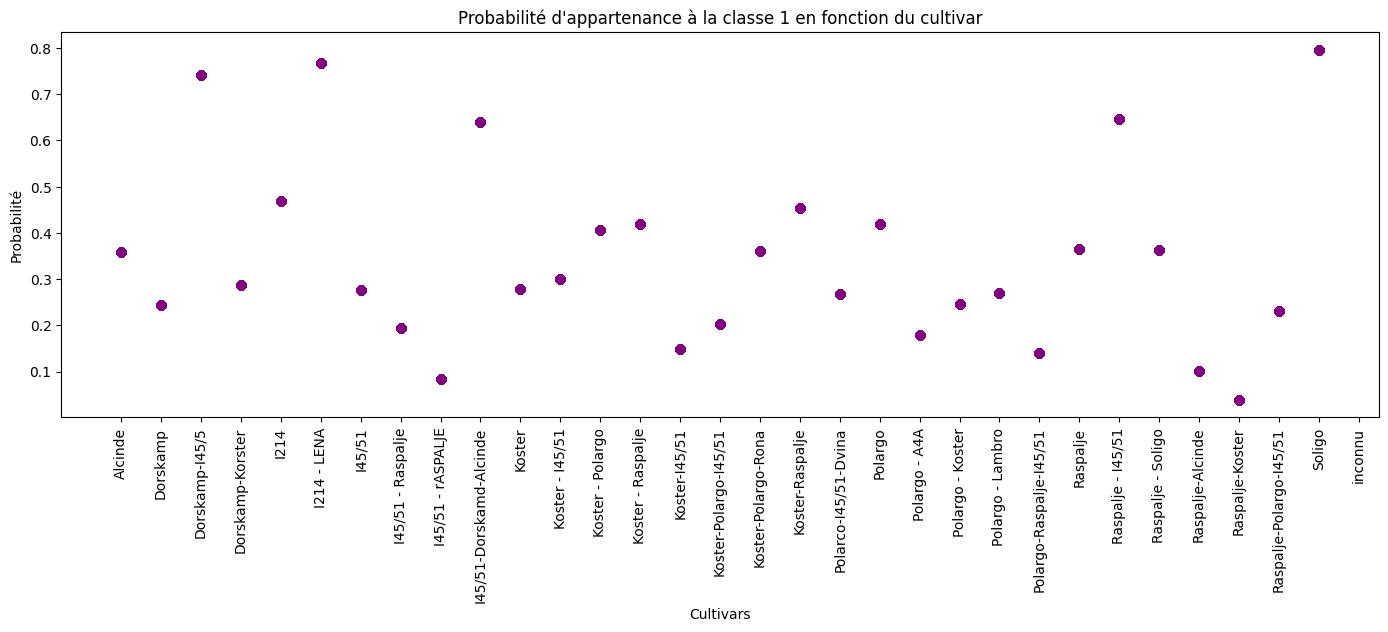

<Figure size 640x480 with 0 Axes>

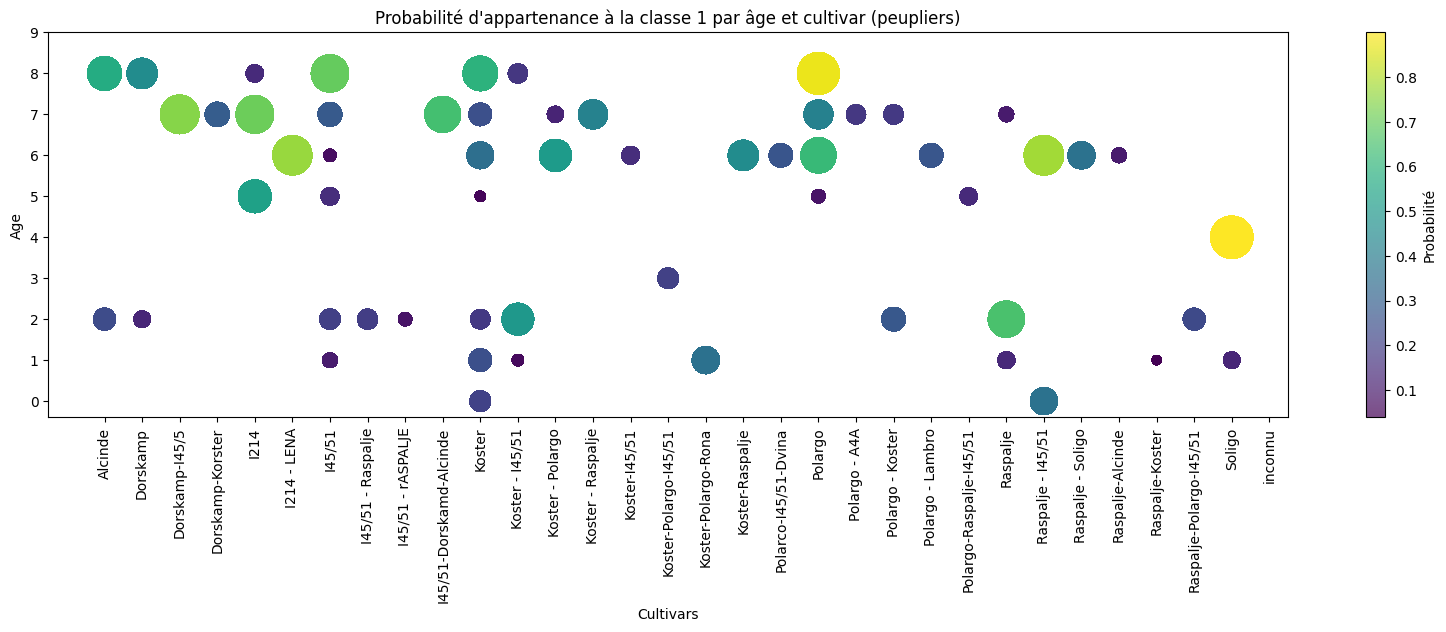

In [154]:
#On observe la qualité de prédiction par âge de plantation de peupliers
peupliers_pred = pd.DataFrame(y_pred_test, columns=['Classe'])
peupliers_pred['Probabilité'] = y_pred_test_proba[:,1]
y_test_ = pd.DataFrame(y_SR_test, columns=['Classe'])

peupliers_pred = peupliers_pred[y_test_['Classe'] == 1]
peupliers_pred['age'] = data_SR_test[y_test_['Classe'] == 1]['age']
peupliers_pred['Cultivars'] = data_SR_test[y_test_['Classe'] == 1]['Cultivars']
peupliers_pred = peupliers_pred.reset_index(drop=True)

y_test_peupliers = y_test_[y_test_['Classe'] == 1]
y_test_peupliers['age'] = data_SR_test[y_test_['Classe'] == 1]['age']
y_test_peupliers['Cultivars'] = data_SR_test[y_test_['Classe'] == 1]['Cultivars']
y_test_peupliers = y_test_peupliers.reset_index(drop=True)

#print(peupliers_pred.value_counts('age'))
#print(y_test_peupliers.value_counts('age'))

for age in peupliers_pred['age'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Accuracy par age'] = accuracy_score(peupliers_pred[peupliers_pred['age'] == age]['Classe'], y_test_peupliers[y_test_peupliers['age'] == age]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Accuracy par cultivar'] = accuracy_score(peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Classe'], y_test_peupliers[y_test_peupliers['Cultivars'] == cultivar]['Classe'])

for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        #on ajoute à peupliers_pred la valeur de l'accuracy pour chaque âge
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Accuracy par cultivar et age'] = accuracy_score(peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Classe'], y_test_peupliers[(y_test_peupliers['Cultivars'] == cultivar) & (y_test_peupliers['age'] == age)]['Classe'])

#moyenne de proba d'appartenance à la classe 1 par âge
for age in peupliers_pred['age'].unique():
    peupliers_pred.loc[peupliers_pred['age'] == age, 'Probabilité par âge'] = peupliers_pred[peupliers_pred['age'] == age]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    peupliers_pred.loc[peupliers_pred['Cultivars'] == cultivar, 'Probabilité par cultivar'] = peupliers_pred[peupliers_pred['Cultivars'] == cultivar]['Probabilité'].mean()

#moyenne de proba d'appartenance à la classe 1 par âge et par cultivar
for cultivar in peupliers_pred['Cultivars'].unique():
    for age in peupliers_pred['age'].unique():
        peupliers_pred.loc[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age), 'Probabilité par cultivar et age'] = peupliers_pred[(peupliers_pred['Cultivars'] == cultivar) & (peupliers_pred['age'] == age)]['Probabilité'].mean()



#remplacer les nan par "inconnu"    
peupliers_pred['Cultivars'] = peupliers_pred['Cultivars'].fillna('inconnu')

#ranger les cultivars par ordre alphabétique (pour l'affichage)
peupliers_pred = peupliers_pred.sort_values('Cultivars')


#plot
plt.figure(15)
plt.figure(figsize=(8, 4))
plt.scatter(peupliers_pred['age'], peupliers_pred['Accuracy par age'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Accuracy')
plt.title('Accuracy par âge (peupliers)')
plt.show()

plt.figure(16)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Accuracy par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Accuracy')
plt.title('Accuracy par cultivar (peupliers)')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser l'accuracy par âge et par cultivar pour les peupliers
plt.figure(17)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Accuracy par cultivar et age']*1000, c=peupliers_pred['Accuracy par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Accuracy par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Accuracy')
plt.show()


#proba d'appartenance à la classe 1 en fonction de l'âge
plt.figure(18)
plt.figure(figsize=(10, 5))
plt.scatter(peupliers_pred['age'], peupliers_pred['Probabilité par âge'], color='purple', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction de l\'âge')
plt.show()

#proba d'appartenance à la classe 1 en fonction du cultivar
plt.figure(19)
plt.figure(figsize=(17, 5))
plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['Probabilité par cultivar'], color='purple', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Probabilité')
plt.title('Probabilité d\'appartenance à la classe 1 en fonction du cultivar')
plt.xticks(rotation=90)
plt.show()

#bubble chart pour visualiser la probabilité d'appartenance à la classe 1 par âge et par cultivar pour les peupliers
plt.figure(20)
plt.figure(figsize=(20, 5))
scatter = plt.scatter(peupliers_pred['Cultivars'], peupliers_pred['age'], s=peupliers_pred['Probabilité par cultivar et age']*1000, c=peupliers_pred['Probabilité par cultivar et age'], cmap='viridis', alpha=0.7)
plt.xlabel('Cultivars')
plt.ylabel('Age')
plt.title('Probabilité d\'appartenance à la classe 1 par âge et cultivar (peupliers)')
plt.xticks(rotation=90)
plt.yticks(range(0,10,1))

colorbar = plt.colorbar(scatter)
colorbar.set_label('Probabilité')
plt.show()



## Autres

1) Feature importance : On visualise l'importance de chaque date dans la prédiction sur le test

2) SFFS sur les données (pour comparer au SFFS de 2017) : la SFFS 2018 donne bien de meilleurs résultats sur les données sans SR

3) Classification en gardant toutes les classes (on montre que c'est pas performant)

4) Accuracy en fonction du nombre de composantes principales pour la PCA

5) Training sur deux tuiles et test sur une tuile parmis le trainset initial





### 1) Feature importance

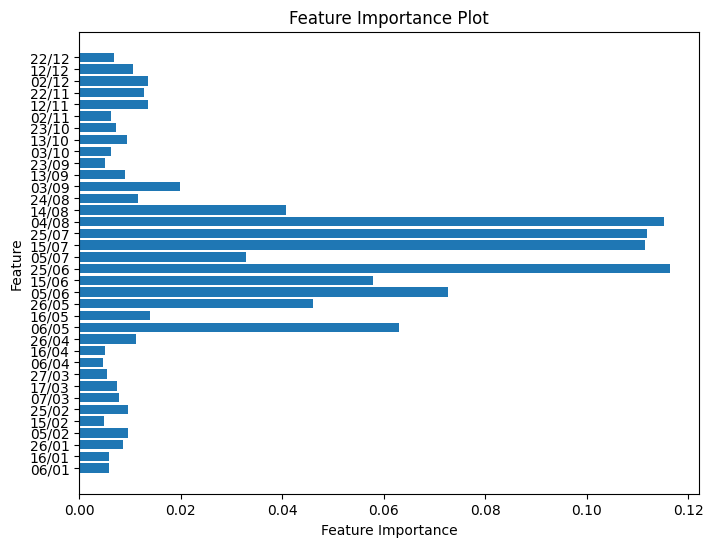

In [141]:
import matplotlib.pyplot as plt
from sklearn import tree

plt.figure(figsize=(8, 6))
plt.barh(range(X.shape[1]), best_model_cv.feature_importances_, align='center')
plt.yticks(range(X.shape[1]), X_test.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance Plot')
plt.show()


## b) SFFS "accuracy" based

In [185]:
!pip install mlxtend

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
   --- ------------------------------------ 0.1/1.4 MB 3.3 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.4 MB 7.2 MB/s eta 0:00:01
   ------------------------------ --------- 1.1/1.4 MB 8.8 MB/s eta 0:00:01
   ---------------------------------------- 1.4/1.4 MB 8.4 MB/s eta 0:00:00


In [216]:
#on effectue une sffs sur les données bi-classes (RECALL)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

clf = RandomForestClassifier(n_estimators=100, random_state=7)

sfs2 = SFS(clf,
              k_features=5,
              forward=True,
              floating=False,
              verbose=2,
              scoring='recall',
              cv=10,
              n_jobs=-1)

sfs2 = sfs2.fit(X, y)

print(sfs2.k_feature_names_)

sfs2.k_score_





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   36.4s remaining:   32.6s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   55.9s finished

[2024-03-04 15:45:55] Features: 1/5 -- score: 0.8897404228258333[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:   35.4s remaining:   42.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   56.4s finished

[2024-03-04 15:46:51] Features: 2/5 -- score: 0.9169817244145829[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:   33.5s remaining:   42.5s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   55.4s finished

[2024-03-04 15:47:47] Features: 3/5 -- score: 0.9381638014076306[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  3

('05/02', '07/03', '06/05', '25/07', '23/10')


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.5min finished

[2024-03-04 15:50:46] Features: 5/5 -- score: 0.9584130212539879

0.9584130212539879

In [217]:
sfs2.k_feature_names_

('05/02', '07/03', '06/05', '25/07', '23/10')

In [197]:
#on effectue une sffs sur les données bi-classes (ACCURACY)
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

clf = RandomForestClassifier(n_estimators=100, random_state=7)

sfs = SFS(clf,
              k_features=5,
              forward=True,
              floating=False,
              verbose=2,
              scoring='accuracy',
              cv=10,
              n_jobs=-1)

sfs = sfs.fit(X, y)

print(sfs.k_feature_names_)

sfs.k_score_





[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  36 | elapsed:   38.6s remaining:   34.5s
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:   59.4s finished

[2024-03-04 14:41:21] Features: 1/5 -- score: 0.9084882137445576[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 out of  35 | elapsed:   37.5s remaining:   44.6s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.0min finished

[2024-03-04 14:42:23] Features: 2/5 -- score: 0.9254233299546609[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  15 out of  34 | elapsed:   35.5s remaining:   45.0s
[Parallel(n_jobs=-1)]: Done  34 out of  34 | elapsed:   57.6s finished

[2024-03-04 14:43:20] Features: 3/5 -- score: 0.9454398383709621[Parallel(n_jobs=-1)]: Using backend LokyBackend with 28 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  3

('05/02', '06/05', '05/07', '25/07', '12/11')


[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  1.5min finished

[2024-03-04 14:46:26] Features: 5/5 -- score: 0.9644206944828383

0.9644206944828383

In [198]:
#define new X with the selected features
X_SFFS_2018 = sfs.transform(X)

X_SFFS_2018.shape

(38618, 5)

In [200]:
sfs.k_feature_names_

('05/02', '06/05', '05/07', '25/07', '12/11')

recall: ('05/02', '07/03', '06/05', ***'25/07'***, '23/10')

accuracy: ('05/02', '06/05', '05/07', ***'25/07'***, '12/11')


recall de Dr. Yousra Hamrouni: ('16/04','05/06', ***'25/07'***, '24/08', '23/10' )

In [202]:
X_SFFS_2018 = pd.DataFrame(X_SFFS_2018, columns=['05/02', '06/05', '05/07', '25/07', '12/11'])

In [203]:
X_SFFS_2018.head()

05/02   06/05   05/07  25/07   12/11
0   218.0  -941.0 -1021.0 -992.0 -1529.0
1 -1782.0  -726.0  -979.0 -923.0 -1399.0
2  -243.0  -803.0  -876.0 -926.0  -463.0
3 -1713.0 -3342.0 -1041.0 -963.0 -1287.0
4  1097.0  -914.0 -1226.0 -874.0 -1161.0

In [60]:
X_test_SFFS_2018 = sfs.transform(X_test)
X_test_SFFS_2018 = pd.DataFrame(X_test_SFFS_2018, columns=['05/02', '06/05', '05/07', '25/07', '12/11'])

X_test_SFFS_2018.head()

NameError: name 'sfs' is not defined

### Train sur le SFFS "accuracy" based

In [30]:
X_SFFS_2018 = X[['05/02', '06/05', '05/07', '25/07', '12/11']]
X_test_SFFS_2018 = X_test[['05/02', '06/05', '05/07', '25/07', '12/11']]
X_test_SFFS_2018.head()

05/02   06/05   05/07   25/07   12/11
0 -1383.0  -858.0  -709.0  -847.0 -1495.0
1 -1707.0 -1302.0 -2632.0 -2834.0 -3506.0
2 -1813.0 -2242.0 -2540.0 -2353.0 -2032.0
3 -2294.0 -1844.0 -2896.0 -2370.0 -2264.0
4 -2002.0 -1066.0  -992.0 -1009.0 -1754.0

Fold 0 Accuracy: 0.9637493526670119
Fold 1 Accuracy: 0.965820818228897
Fold 2 Accuracy: 0.9642672190574831
Fold 3 Accuracy: 0.9681512169860176
Fold 4 Accuracy: 0.9575349559813569
Fold 5 Accuracy: 0.9655618850336614
Fold 6 Accuracy: 0.9624546866908338
Fold 7 Accuracy: 0.9640082858622475
Fold 8 Accuracy: 0.9655529655529655
Fold 9 Accuracy: 0.9663299663299664
Meilleur score d'exactitude : 0.97
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  37.22654843330383
Test Set Accuracy: 0.7388248646760956


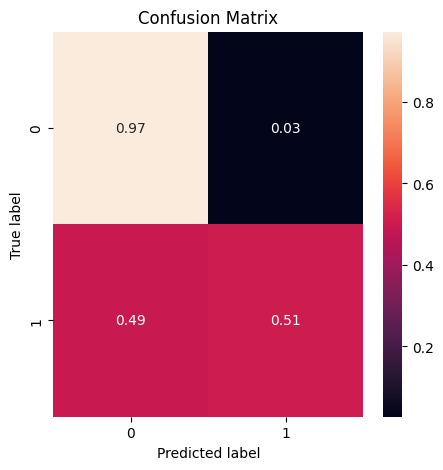

              precision    recall  f1-score   support

         0.0       0.66      0.97      0.79     22908
         1.0       0.95      0.51      0.66     22908

    accuracy                           0.74     45816
   macro avg       0.81      0.74      0.72     45816
weighted avg       0.81      0.74      0.72     45816



In [76]:
# cross validation
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs = []

best_accuracy_cv = 0.0

best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS_2018.values)):
    X_train, X_val = X_SFFS_2018.values[train_index], X_SFFS_2018.values[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS_2018.values, y)

#joblib.dump(best_model_cv, 'SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_test_SFFS_2018.values)
accuracy_test = accuracy_score(y_test.values, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

#Matrice de confusion

cm = confusion_matrix(y_test.values, y_pred_test, labels=[0,1], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))




### Avec la PCA

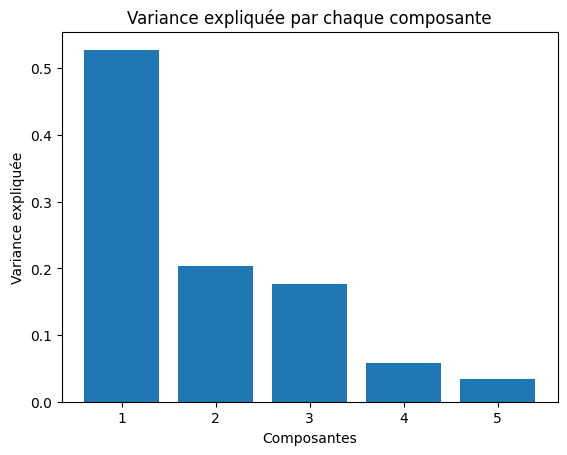

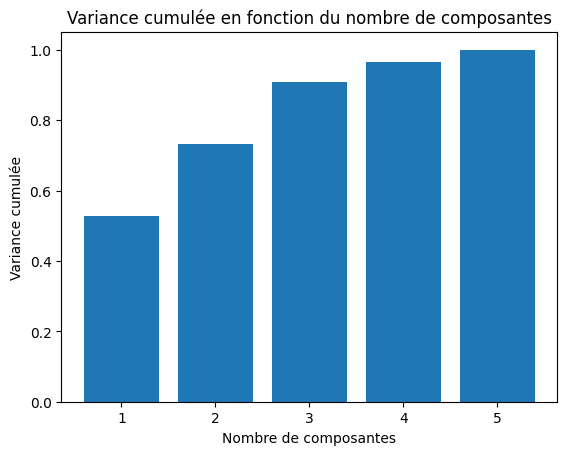

<Figure size 640x480 with 0 Axes>

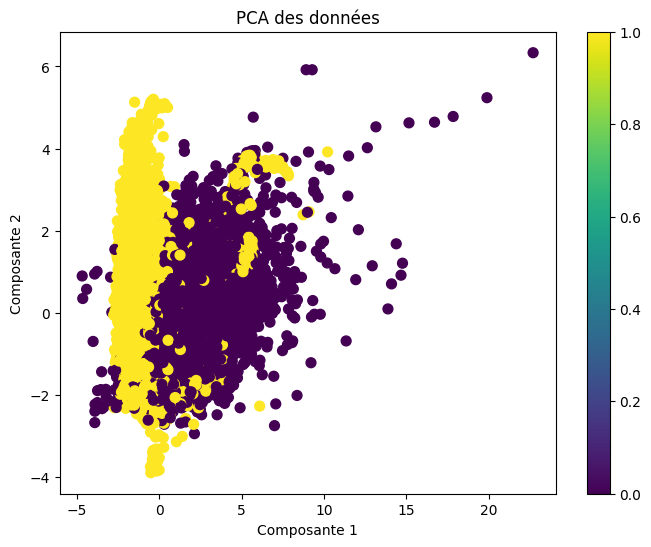

In [40]:
#PCA sur les données SFFS 2018
scaler = StandardScaler()
X_SFFS_2018_scaled = scaler.fit_transform(X_SFFS_2018)

pca = PCA()
X_SFFS_2018_pca = pca.fit_transform(X_SFFS_2018_scaled)

explained_variance = pca.explained_variance_ratio_
explained_variance

cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

plt.figure(14)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

plt.figure(15)
plt.bar(range(1, len(cum_explained_variance)+1), cum_explained_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Variance cumulée en fonction du nombre de composantes')
plt.show()

plt.figure(16)
plt.figure(figsize=(8, 6))
plt.scatter(X_SFFS_2018_pca[:, 0], X_SFFS_2018_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

X_SFFS_2018_pca = X_SFFS_2018_pca[:, :5]

In [41]:
#Données de test sffs 2018 pca
scaler = StandardScaler()
X_test_SFFS_2018_scaled = scaler.fit_transform(X_test_SFFS_2018)

pca = PCA()
X_test_SFFS_2018_pca = pca.fit_transform(X_test_SFFS_2018_scaled)

X_test_SFFS_2018_pca = X_test_SFFS_2018_pca[:, :5]


Fold 0 Accuracy: 0.9655618850336614
Fold 1 Accuracy: 0.9640082858622475
Fold 2 Accuracy: 0.9642672190574831
Fold 3 Accuracy: 0.9665976178146038
Fold 4 Accuracy: 0.9603832211289487
Fold 5 Accuracy: 0.9611600207146557
Fold 6 Accuracy: 0.9616778871051269
Fold 7 Accuracy: 0.9627136198860694
Fold 8 Accuracy: 0.9660709660709661
Fold 9 Accuracy: 0.9681429681429682
Meilleur score d'exactitude : 0.97
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  55.95208191871643
Test Set Accuracy: 0.5621398638030383


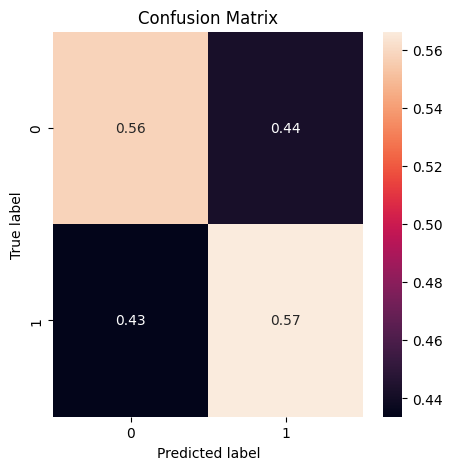

              precision    recall  f1-score   support

         0.0       0.56      0.56      0.56     22908
         1.0       0.56      0.57      0.56     22908

    accuracy                           0.56     45816
   macro avg       0.56      0.56      0.56     45816
weighted avg       0.56      0.56      0.56     45816



In [42]:
# cross validation
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs_pca = []

best_accuracy_cv = 0.0

best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS_2018_pca)):
    X_train, X_val = X_SFFS_2018_pca[train_index], X_SFFS_2018_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS_2018_pca, y)

#joblib.dump(best_model_cv, 'PCA_SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state=7.pkl')

y_pred_test = best_model_cv.predict(X_test_SFFS_2018_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

#Matrice de confusion

cm = confusion_matrix(y_test.values, y_pred_test, labels=[0,1], normalize='true')

plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[0,1], yticklabels=[0,1])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))



## c) Classification en gardant toutes les classes

### 1) Sans Super résolution

### a) Données brutes

In [80]:
csv_file_path = 'data_30TYT_31TCJ_31UEQ.csv'
data = pd.read_csv(csv_file_path)

print("\nInformations sur les données :")
print(data.info())
data.drop(data[data['value_0']==0].index, inplace=True)

# on rééquilibre les classes avec classe 1 qui garde tous ses échantillons et les autres classes qui en perdent, on undersample aléatoirement
data = data.groupby('Classe').apply(lambda x: x.sample(n=data['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)

#on remplace les features value_0 à value_35 par les dates correspondantes
dates = ['06/01', '16/01', '26/01', '05/02', '15/02', '25/02', '07/03', '17/03', '27/03', '06/04', '16/04', '26/04', '06/05', '16/05', '26/05', '05/06', '15/06', '25/06', '05/07', '15/07', '25/07', '04/08', '14/08', '24/08', '03/09', '13/09', '23/09', '03/10', '13/10', '23/10', '02/11', '12/11', '22/11', '02/12', '12/12', '22/12']
for i in range(36):
    data = data.rename(columns={f'value_{i}': dates[i]})

#shuffle des données
data = data.sample(frac=1, random_state=7).reset_index(drop=True)

#Split en Features et Label
X = data.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid']) 
y = data['Classe']



Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123957 entries, 0 to 123956
Data columns (total 47 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   ID         123957 non-null  object 
 1   CODE_TFV   123957 non-null  object 
 2   TFV        123957 non-null  object 
 3   TFV_G11    123957 non-null  object 
 4   ESSENCE    123957 non-null  object 
 5   ID_plot    123957 non-null  int64  
 6   Classe     123957 non-null  int64  
 7   Dep        123957 non-null  int64  
 8   layer      123957 non-null  object 
 9   path       123957 non-null  object 
 10  originfid  123957 non-null  int64  
 11  value_0    123957 non-null  float64
 12  value_1    123957 non-null  float64
 13  value_2    123957 non-null  float64
 14  value_3    123957 non-null  float64
 15  value_4    123957 non-null  float64
 16  value_5    123957 non-null  float64
 17  value_6    123957 non-null  float64
 18  value_7    123957 non-null  floa

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_29408\1458691725.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Classe').apply(lambda x: x.sample(n=data['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


In [81]:
print(y.value_counts())
X.head()

Classe
5    8084
6    8084
4    8084
8    8084
1    8084
3    8084
2    8084
Name: count, dtype: int64


06/01   16/01   26/01   05/02   15/02   25/02   07/03   17/03   27/03  \
0  -672.0  -615.0  -816.0  1321.0   434.0 -1523.0 -1586.0 -1649.0 -1435.0   
1  -582.0  2651.0  1333.0    15.0 -1295.0 -1294.0 -1390.0 -1487.0 -1615.0   
2 -1955.0 -1627.0  -159.0  1310.0   899.0  -318.0 -1536.0 -2754.0 -3120.0   
3 -2070.0 -1792.0  -724.0   345.0   147.0  -593.0 -1334.0 -2074.0 -2311.0   
4  -371.0   -53.0   264.0   581.0  -166.0 -1978.0 -1860.0 -1742.0 -1623.0   

    06/04  ...   23/09   03/10   13/10   23/10   02/11   12/11   22/11  \
0 -1217.0  ... -1944.0 -2508.0 -2167.0 -1629.0  -957.0 -1021.0 -1085.0   
1 -1824.0  ... -1406.0 -1355.0 -1438.0  -952.0  -900.0  -753.0 -1321.0   
2 -3123.0  ... -1816.0 -1931.0 -2058.0 -2138.0 -2030.0 -1921.0 -1853.0   
3 -2333.0  ... -2500.0 -2403.0 -2677.0 -2805.0 -2357.0 -1908.0 -1898.0   
4 -1505.0  ... -1170.0 -1111.0 -1298.0 -1280.0 -1303.0 -1324.0 -1336.0   

    02/12   12/12   22/12  
0 -1149.0 -1086.0  -744.0  
1 -1321.0 -1321.0 -1321.0  
2 -1800.0 -1709.0 -1509.0  
3 -2075.0 -2250.0 -2292.0  
4 -1336.0 -1336.0 -1336.0  

[5 rows x 36 columns]

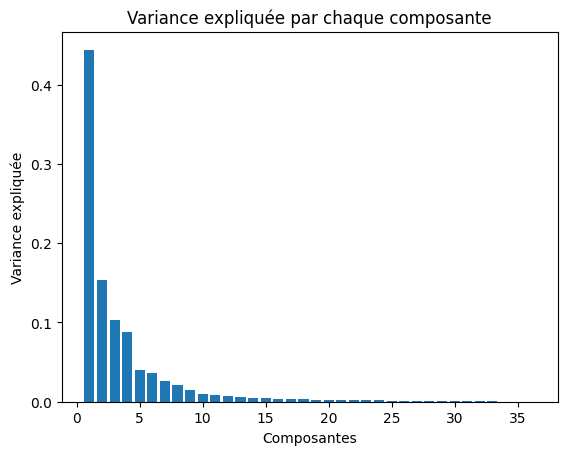

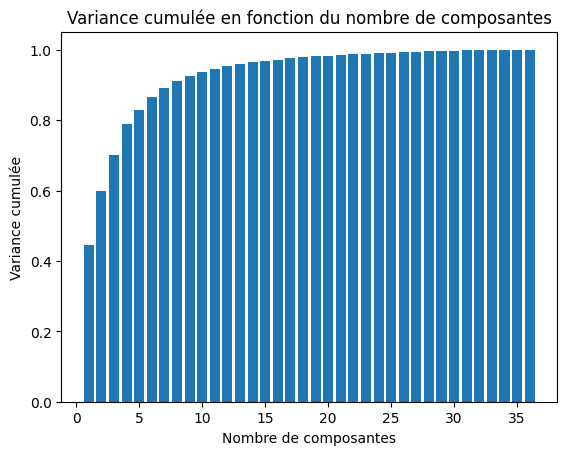

<Figure size 640x480 with 0 Axes>

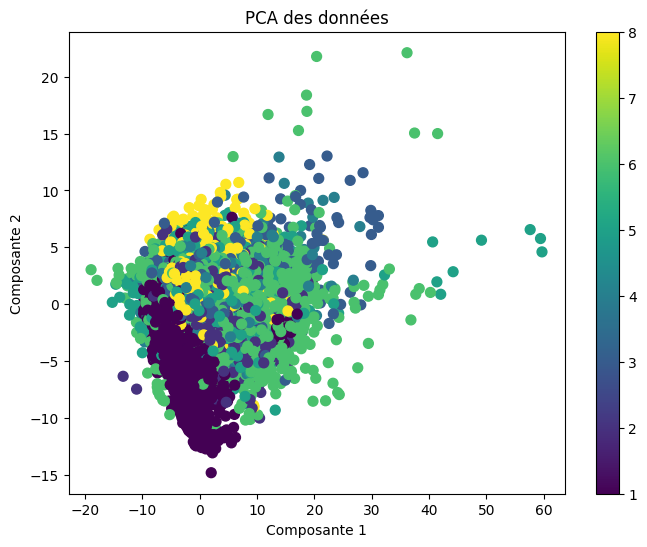

In [82]:
#PCA sur les données pour visualiser les composantes les plus importantes puis pour l'entrainement
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA()
X_pca = pca.fit_transform(X_scaled)

#on regarde la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
explained_variance

#on regarde la variance cumulée
cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

#on trace la variance expliquée par chaque composante en barres
plt.figure(9)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

#on trace la variance cumulée en barres
plt.figure(10)
plt.bar(range(1, len(cum_explained_variance)+1), cum_explained_variance)
plt.xlabel('Nombre de composantes')
plt.ylabel('Variance cumulée')
plt.title('Variance cumulée en fonction du nombre de composantes')
plt.show()

#on va tracer les deux premières composantes principales
plt.figure(11)
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

#on va créer X_PCA qui contient les 5 premières composantes principales
X_pca = X_pca[:, :5]


In [83]:
#on extrait les colonnes 05/06, 23/10, 25/07, 24/08 et 16/04 pour les garder en features
X_SFFS = X[['05/06', '23/10', '25/07', '24/08', '16/04']]


#X_SFFS_PCA


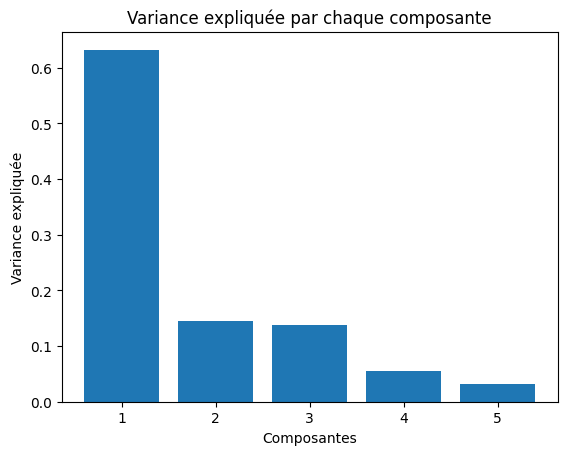

<Figure size 640x480 with 0 Axes>

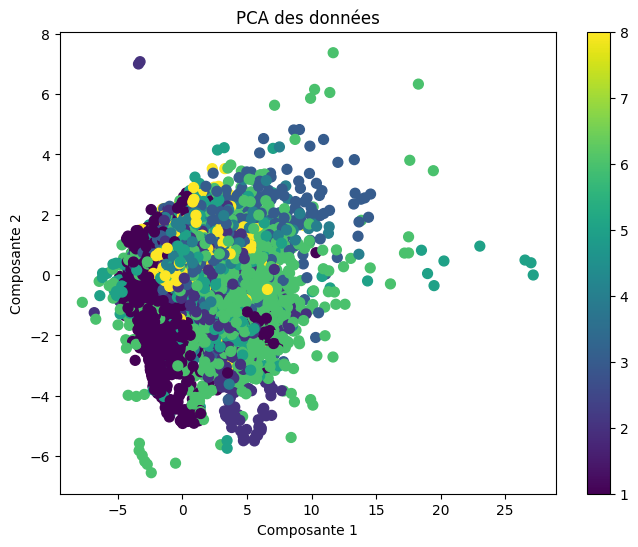

In [84]:
#pca
scaler = StandardScaler()
X_sffs_scaled = scaler.fit_transform(X_SFFS)

pca = PCA()
X_sffs_pca = pca.fit_transform(X_sffs_scaled)

#on regarde la variance expliquée par chaque composante
explained_variance = pca.explained_variance_ratio_
explained_variance

#on regarde la variance cumulée
cum_explained_variance = np.cumsum(explained_variance)
cum_explained_variance

#on trace la variance expliquée par chaque composante en barres
plt.figure(12)
plt.bar(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Composantes')
plt.ylabel('Variance expliquée')
plt.title('Variance expliquée par chaque composante')
plt.show()

#on trace les deux premières composantes principales
plt.figure(13)
plt.figure(figsize=(8, 6))
plt.scatter(X_sffs_pca[:, 0], X_sffs_pca[:, 1], c=y, cmap='viridis', s=50)
plt.colorbar()
plt.xlabel('Composante 1')
plt.ylabel('Composante 2')
plt.title('PCA des données')
plt.show()

#on va créer X_SFFS_PCA qui contient les 2 premières composantes principales
X_sffs_pca = X_sffs_pca[:, :5]


### Données de test

In [85]:
csv_file_path = 'data_30TYQ_peupliers.csv'
csv_file_path_non_peupliers = "data_30TYQ_non_peupliers.csv"
csv_file_path_peup_aug = 'data_30TYQ_peupliers_AUG.csv'

peupliers = pd.read_csv(csv_file_path)
peupliers_aug = pd.read_csv(csv_file_path_peup_aug)

peupliers = pd.concat([peupliers, peupliers_aug], ignore_index=True)

#ajouter la colonne "Classe" dans data_test et donner la valeur 1 à tous les échantillons
peupliers['Classe'] = pd.DataFrame(np.ones(peupliers.shape[0]), columns=['Classe'])

data_test_non_peupliers = pd.read_csv(csv_file_path_non_peupliers)

#Fusionner les deux dataframes
data_test = pd.concat([peupliers, data_test_non_peupliers], ignore_index=True)

#shuffle
data_test = data_test.sample(frac=1, random_state=7).reset_index(drop=True)

print("\nInformations sur les données :")
print(data_test.info())

#on retire les échantillons avec features nuls
data_test.drop(data_test[data_test['value_0']==0].index, inplace=True) 

for i in range(36):
    data_test = data_test.rename(columns={f'value_{i}': dates[i]})

print(data_test.value_counts('Classe'))


#on rééquilibre les classes 
data_test = data_test.groupby('Classe').apply(lambda x: x.sample(n=data_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)

print(data_test.value_counts('Classe'))


Informations sur les données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54348 entries, 0 to 54347
Data columns (total 41 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Annee_pl   17451 non-null  float64
 1   Cultivars  17451 non-null  object 
 2   value_0    54348 non-null  float64
 3   value_1    54348 non-null  float64
 4   value_2    54348 non-null  float64
 5   value_3    54348 non-null  float64
 6   value_4    54348 non-null  float64
 7   value_5    54348 non-null  float64
 8   value_6    54348 non-null  float64
 9   value_7    54348 non-null  float64
 10  value_8    54348 non-null  float64
 11  value_9    54348 non-null  float64
 12  value_10   54348 non-null  float64
 13  value_11   54348 non-null  float64
 14  value_12   54348 non-null  float64
 15  value_13   54348 non-null  float64
 16  value_14   54348 non-null  float64
 17  value_15   54348 non-null  float64
 18  value_16   54348 non-null  float64
 19  value_17   543

C:\Users\Pierre Ribardière\AppData\Local\Temp\ipykernel_29408\1184689809.py:34: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_test = data_test.groupby('Classe').apply(lambda x: x.sample(n=data_test['Classe'].value_counts().min(), random_state=7)).reset_index(drop=True)


In [86]:
#On split en features et label
X_test = data_test.drop(columns=['Annee_pl', 'Cultivars', 'Classe','id', 'originfid'])
y_test = data_test['Classe']

X_test.head()

06/01   16/01   26/01   05/02   15/02   25/02   07/03   17/03   27/03  \
0  1422.0  -757.0 -1456.0 -1401.0 -1520.0 -1813.0 -1974.0 -2003.0 -1935.0   
1 -2136.0 -2108.0  -670.0 -1588.0    18.0   512.0  -553.0 -2078.0 -2571.0   
2 -2524.0 -1718.0 -2506.0 -2589.0 -2771.0 -3049.0 -2901.0 -2894.0 -2993.0   
3 -1321.0 -1114.0 -1054.0 -1018.0 -1037.0 -1113.0 -1189.0 -1380.0 -1775.0   
4 -1739.0 -1648.0 -1548.0 -1531.0  1659.0  2148.0   118.0 -1624.0 -1860.0   

    06/04  ...   23/09   03/10   13/10   23/10   02/11   12/11   22/11  \
0 -1770.0  ... -2157.0 -2121.0 -2187.0 -2353.0 -2103.0 -1855.0 -2614.0   
1 -2303.0  ... -1865.0 -4352.0 -3835.0 -3873.0 -3465.0 -3057.0 -3351.0   
2 -2628.0  ... -1076.0 -1029.0 -1351.0 -1764.0 -2376.0 -2988.0 -3210.0   
3 -1913.0  ... -2118.0 -2032.0 -2083.0 -2242.0 -2155.0 -2068.0 -2409.0   
4 -1745.0  ... -1692.0 -1773.0 -2029.0 -2564.0 -2552.0 -2541.0 -2718.0   

    02/12   12/12   22/12  
0 -1843.0 -1727.0 -1727.0  
1 -2554.0 -2357.0 -2357.0  
2 -2785.0 -2658.0 -2658.0  
3 -1911.0 -1563.0 -1563.0  
4 -2415.0 -2173.0 -2173.0  

[5 rows x 36 columns]

In [87]:
#features sffs
X_test_sffs = X_test[['05/06', '23/10', '25/07', '24/08', '16/04']]
X_test_sffs

05/06   23/10   25/07   24/08   16/04
0    -1642.0 -2353.0 -3224.0 -2181.0 -1605.0
1    -1612.0 -3873.0 -3121.0 -3007.0 -2034.0
2    -1411.0 -1764.0 -1056.0  -993.0 -2263.0
3    -1906.0 -2242.0 -2966.0 -2133.0 -2051.0
4    -1620.0 -2564.0 -2051.0 -1741.0 -1630.0
...      ...     ...     ...     ...     ...
9223 -2146.0 -1921.0 -2146.0 -2347.0 -2399.0
9224 -1922.0 -2147.0 -2746.0 -2395.0 -3112.0
9225 -2579.0 -2847.0 -2512.0 -3001.0 -2652.0
9226 -1591.0 -1380.0 -1587.0 -1624.0 -1530.0
9227 -1292.0  -730.0 -1123.0  -941.0 -1297.0

[9228 rows x 5 columns]

In [88]:
#pca sur les features sffs
#PCA sur les données de test
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X_test)

pca = PCA()
X_test_pca = pca.fit_transform(X_test_scaled)

#on garde les cinq premières composantes principales
X_test_pca = X_test_pca[:, :5]

scaler = StandardScaler()
X_test_sffs_scaled = scaler.fit_transform(X_test_sffs)

pca = PCA()
X_test_sffs_pca = pca.fit_transform(X_test_sffs_scaled)

X_test_sffs_pca = X_test_sffs_pca[:,:5]

In [89]:
X = X.values #on convertit en np array
y = y.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X)):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)


Fold 0 Accuracy: 0.8284149142958119
Fold 1 Accuracy: 0.8229369146492314
Fold 2 Accuracy: 0.8300053012899805
Fold 3 Accuracy: 0.8250574306414561
Fold 4 Accuracy: 0.8307121399540555
Fold 5 Accuracy: 0.8301820109559993
Fold 6 Accuracy: 0.8301820109559993
Fold 7 Accuracy: 0.8333627849443365
Fold 8 Accuracy: 0.8273241428066455
Fold 9 Accuracy: 0.8237893248497702
Meilleur score d'exactitude : 0.83
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  196.5159764289856


In [90]:
best_model_cv.fit(X, y)
y_pred_test = best_model_cv.predict(X_test.values)
accuracy_test = accuracy_score(y_test.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)

Test Set Accuracy: 0.40030342436064154


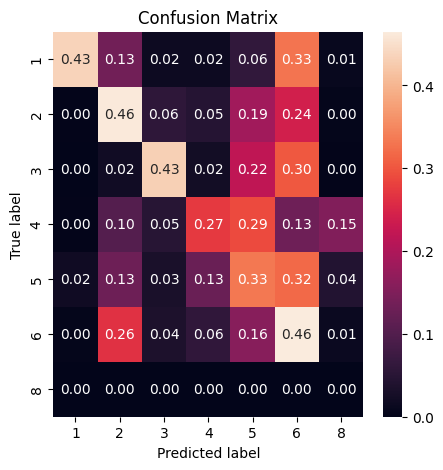

              precision    recall  f1-score   support

         1.0       0.94      0.43      0.59      1538
         2.0       0.41      0.46      0.44      1538
         3.0       0.70      0.43      0.53      1538
         4.0       0.50      0.27      0.35      1538
         5.0       0.27      0.33      0.30      1538
         6.0       0.26      0.46      0.33      1538
         8.0       0.00      0.00      0.00         0

    accuracy                           0.40      9228
   macro avg       0.44      0.34      0.36      9228
weighted avg       0.51      0.40      0.43      9228



d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [91]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test, labels=[1,2,3,4,5,6,8], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[1,2,3,4,5,6,8], yticklabels=[1,2,3,4,5,6,8])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))



### b) 36 features avec PCA


In [92]:
#Avec les données PCA
X_pca
y = y
X_test_pca
#y_test = y_test.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucler sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_pca)):
    X_train, X_val = X_pca[train_index], X_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    # Sauvegarder le modèle et son score
    models.append((rf_model, accuracy))

    # Mettre à jour le meilleur modèle si nécessaire
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_pca, y)
#joblib.dump(best_model_cv, 'PCA_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl')

# Evaluate the best model on the validation set
y_pred_test = best_model_cv.predict(X_test_pca)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Set Accuracy:", accuracy_test)

Fold 0 Accuracy: 0.6416327973140131
Fold 1 Accuracy: 0.63509453967132
Fold 2 Accuracy: 0.6359780880014136
Fold 3 Accuracy: 0.6444601519703128
Fold 4 Accuracy: 0.6508216999469871
Fold 5 Accuracy: 0.646934087294575
Fold 6 Accuracy: 0.6368616363315074
Fold 7 Accuracy: 0.6552394415974554
Fold 8 Accuracy: 0.6514669494521033
Fold 9 Accuracy: 0.6436903499469777
Meilleur score d'exactitude : 0.66
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  98.28213882446289
Test Set Accuracy: 0.1304724750758561


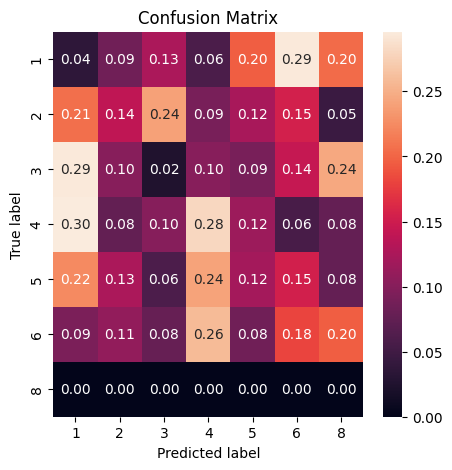

              precision    recall  f1-score   support

         1.0       0.03      0.04      0.03      1538
         2.0       0.22      0.14      0.17      1538
         3.0       0.04      0.02      0.03      1538
         4.0       0.27      0.28      0.28      1538
         5.0       0.17      0.12      0.14      1538
         6.0       0.18      0.18      0.18      1538
         8.0       0.00      0.00      0.00         0

    accuracy                           0.13      9228
   macro avg       0.13      0.11      0.12      9228
weighted avg       0.15      0.13      0.14      9228



d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test, labels=[1,2,3,4,5,6,8], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[1,2,3,4,5,6,8], yticklabels=[1,2,3,4,5,6,8])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

### c) Avec features SFFS

In [94]:
X_SFFS = X_SFFS.values
#y = y.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_SFFS)):
    X_train, X_val = X_SFFS[train_index], X_SFFS[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_SFFS, y)
#joblib.dump(best_model_cv, 'SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state_7.pkl')


Fold 0 Accuracy: 0.5566354479590033
Fold 1 Accuracy: 0.5679448665842022
Fold 2 Accuracy: 0.5690051245803145
Fold 3 Accuracy: 0.562820286269659
Fold 4 Accuracy: 0.5725393179006891
Fold 5 Accuracy: 0.5815515108676445
Fold 6 Accuracy: 0.5589326736172469
Fold 7 Accuracy: 0.5691818342463333
Fold 8 Accuracy: 0.5655708731000354
Fold 9 Accuracy: 0.5653941322021916
Meilleur score d'exactitude : 0.58
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  71.07540941238403


RandomForestClassifier(random_state=7)

d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Test Set Accuracy: 0.276766363242306


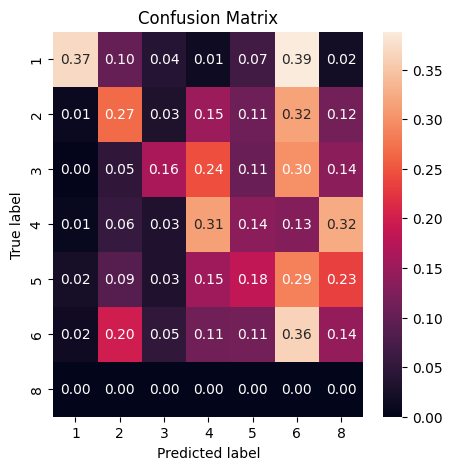

              precision    recall  f1-score   support

         1.0       0.86      0.37      0.52      1538
         2.0       0.35      0.27      0.30      1538
         3.0       0.47      0.16      0.24      1538
         4.0       0.32      0.31      0.31      1538
         5.0       0.26      0.18      0.21      1538
         6.0       0.20      0.36      0.26      1538
         8.0       0.00      0.00      0.00         0

    accuracy                           0.28      9228
   macro avg       0.35      0.24      0.26      9228
weighted avg       0.41      0.28      0.31      9228



d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [95]:
y_pred_test = best_model_cv.predict(X_test_sffs)
accuracy_test = accuracy_score(y_test, y_pred_test)

print("Test Set Accuracy:", accuracy_test)

#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test, labels=[1,2,3,4,5,6,8], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[1,2,3,4,5,6,8], yticklabels=[1,2,3,4,5,6,8])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

In [96]:
num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7)

models_sffs_pca = []

best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

for i, (train_index, val_index) in enumerate (kf.split(X_sffs_pca)):
    X_train, X_val = X_sffs_pca[train_index], X_sffs_pca[val_index]
    y_train, y_val = y[train_index], y[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    models_sffs_pca.append((rf_model, accuracy))

    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model

    print("Fold", i, "Accuracy:", accuracy)


print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_sffs_pca, y)
#joblib.dump(best_model_cv, 'PCA_SFFS_Binary_target_bal_RandomForestClassifier_max_depth=df_max_features=df_n_estimators=100_random_state=7.pkl')



Fold 0 Accuracy: 0.5705955115744831
Fold 1 Accuracy: 0.5665311892560523
Fold 2 Accuracy: 0.5690051245803145
Fold 3 Accuracy: 0.5737762855628202
Fold 4 Accuracy: 0.574659833892914
Fold 5 Accuracy: 0.585792542852094
Fold 6 Accuracy: 0.569358543912352
Fold 7 Accuracy: 0.5709489309065205
Fold 8 Accuracy: 0.5692824319547544
Fold 9 Accuracy: 0.5767055496641923
Meilleur score d'exactitude : 0.59
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  99.80615663528442


RandomForestClassifier(random_state=7)

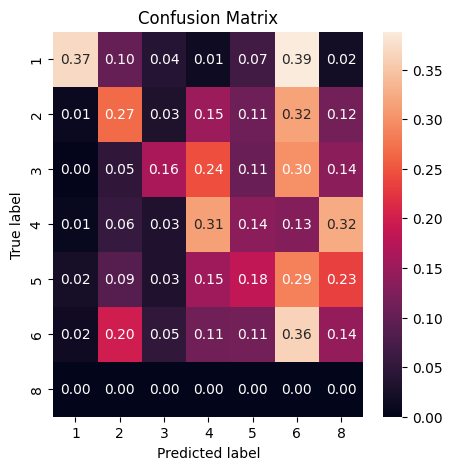

              precision    recall  f1-score   support

         1.0       0.86      0.37      0.52      1538
         2.0       0.35      0.27      0.30      1538
         3.0       0.47      0.16      0.24      1538
         4.0       0.32      0.31      0.31      1538
         5.0       0.26      0.18      0.21      1538
         6.0       0.20      0.36      0.26      1538
         8.0       0.00      0.00      0.00         0

    accuracy                           0.28      9228
   macro avg       0.35      0.24      0.26      9228
weighted avg       0.41      0.28      0.31      9228



d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Programmes\pinokio\bin\miniconda\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [97]:
#Matrice de confusion
cm = confusion_matrix(y_test.values, y_pred_test, labels=[1,2,3,4,5,6,8], normalize='true')
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".2f", xticklabels=[1,2,3,4,5,6,8], yticklabels=[1,2,3,4,5,6,8])
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(classification_report(y_test, y_pred_test))

## 4) Courbes des accuracy en fonction du nombre de composantes principales pour la PCA

a) PCA sur données 36 features

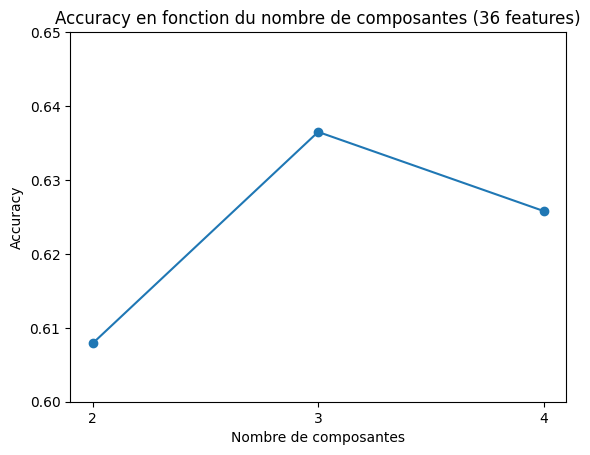

In [64]:
accuracy_pca = [0.6079, 0.6365, 0.6258]
compo_pca = [2, 3,4]

plt.plot(compo_pca, accuracy_pca, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction du nombre de composantes (36 features)')
plt.xticks(compo_pca)
plt.ylim(0.6, 0.65)
plt.show()

b) PCA sur données SFFS 2017

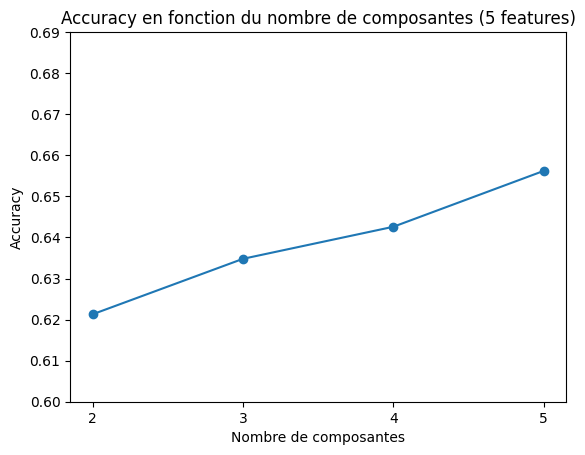

In [65]:
accuracy_sffs2017_pca = [0.6213, 0.6348, 0.6426, 0.6562]

compo_sffs2017_pca = [2, 3, 4, 5]

plt.plot(compo_sffs2017_pca, accuracy_sffs2017_pca, marker='o')
plt.xlabel('Nombre de composantes')
plt.ylabel('Accuracy')
plt.title('Accuracy en fonction du nombre de composantes (5 features)')
plt.ylim(0.6, 0.69)
plt.xticks(compo_sffs2017_pca)
plt.show()


## 5) Classification sur 2 tuiles de train et 1 tuile de test parmis le trainset initial

### a) Test sur T30TYT

In [465]:
#Pour l'entrainement avec deux tuiles du train et la troisieme pour le test -  trainset=(31TCJ, 31UEQ), testset=30TYT
X_train2 = data.drop(data[data['layer'] == 'GroundTruth_30TYT_2154'].index)
y_train2 = X_train2['Classe']
X_train2 = X_train2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid']) 

X_test2 = data.drop(data[data['layer'] == 'GroundTruth_31TCJ_2154'].index)
X_test2 = data.drop(data[data['layer'] == 'GroundTruth_31UEQ_2154'].index)
y_test2 = X_test2['Classe']
X_test2 = X_test2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

In [466]:
X_train2 = X_train2.values #on convertit en np array
y_train2 = y_train2.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_train2)):
    X_train, X_val = X_train2[train_index], X_train2[val_index]
    y_train, y_val = y_train2[train_index], y_train2[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_train2, y_train2)

y_pred_test = best_model_cv.predict(X_test2.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test2.values)
accuracy_test = accuracy_score(y_test2.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)


Fold 0 Accuracy: 0.9688581314878892
Fold 1 Accuracy: 0.9642445213379469
Fold 2 Accuracy: 0.9665513264129181
Fold 3 Accuracy: 0.9694348327566321
Fold 4 Accuracy: 0.9590542099192618
Fold 5 Accuracy: 0.9653979238754326
Fold 6 Accuracy: 0.9532871972318339
Fold 7 Accuracy: 0.9601846508944027
Fold 8 Accuracy: 0.9590305828043855
Fold 9 Accuracy: 0.9653779572994806
Meilleur score d'exactitude : 0.97
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  65.48113012313843
Test Set Accuracy: 0.9599825441850316


### a) Test sur T31TCJ

In [467]:
#Pour l'entrainement avec deux tuiles du train et la troisieme pour le test -  trainset=(31TCJ, 31UEQ), testset=30TYT
X_train2 = data.drop(data[data['layer'] == 'GroundTruth_31TCJ_2154'].index)
y_train2 = X_train2['Classe']
X_train2 = X_train2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid']) 

X_test2 = data.drop(data[data['layer'] == 'GroundTruth_30TYT_2154'].index)
X_test2 = data.drop(data[data['layer'] == 'GroundTruth_31UEQ_2154'].index)
y_test2 = X_test2['Classe']
X_test2 = X_test2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

In [468]:
X_train2 = X_train2.values #on convertit en np array
y_train2 = y_train2.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_train2)):
    X_train, X_val = X_train2[train_index], X_train2[val_index]
    y_train, y_val = y_train2[train_index], y_train2[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_train2, y_train2)

y_pred_test = best_model_cv.predict(X_test2.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test2.values)
accuracy_test = accuracy_score(y_test2.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)


Fold 0 Accuracy: 0.9764801297648013
Fold 1 Accuracy: 0.9816166531494999
Fold 2 Accuracy: 0.9764801297648013
Fold 3 Accuracy: 0.9816166531494999
Fold 4 Accuracy: 0.9772850189291509
Fold 5 Accuracy: 0.9791779340183883
Fold 6 Accuracy: 0.9808004326663061
Fold 7 Accuracy: 0.9780962682531098
Fold 8 Accuracy: 0.9764737696051919
Fold 9 Accuracy: 0.9783666846944294
Meilleur score d'exactitude : 0.98
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  110.5593810081482
Test Set Accuracy: 0.9969452323805368


### a) Test sur T31UEQ

In [469]:
#Pour l'entrainement avec deux tuiles du train et la troisieme pour le test -  trainset=(31TCJ, 31UEQ), testset=30TYT
X_train2 = data.drop(data[data['layer'] == 'GroundTruth_31UEQ_2154'].index)
y_train2 = X_train2['Classe']
X_train2 = X_train2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid']) 

X_test2 = data.drop(data[data['layer'] == 'GroundTruth_30TYT_2154'].index)
X_test2 = data.drop(data[data['layer'] == 'GroundTruth_31TCJ_2154'].index)
y_test2 = X_test2['Classe']
X_test2 = X_test2.drop(columns=['Classe', 'ID', 'CODE_TFV', 'TFV', 'TFV_G11', 'ESSENCE', 'ID_plot', 'Dep', 'layer', 'path', 'originfid'])

In [470]:
X_train2 = X_train2.values #on convertit en np array
y_train2 = y_train2.values

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_train2)):
    X_train, X_val = X_train2[train_index], X_train2[val_index]
    y_train, y_val = y_train2[train_index], y_train2[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_train2, y_train2)

y_pred_test = best_model_cv.predict(X_test2.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test2.values)
accuracy_test = accuracy_score(y_test2.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)


Fold 0 Accuracy: 0.9899650959860384
Fold 1 Accuracy: 0.9899650959860384
Fold 2 Accuracy: 0.9890924956369983
Fold 3 Accuracy: 0.9930191972076788
Fold 4 Accuracy: 0.9895287958115183
Fold 5 Accuracy: 0.9921431689218682
Fold 6 Accuracy: 0.9921431689218682
Fold 7 Accuracy: 0.9960715844609341
Fold 8 Accuracy: 0.9938891313836753
Fold 9 Accuracy: 0.9947621126145788
Meilleur score d'exactitude : 1.00
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  52.91588091850281
Test Set Accuracy: 0.9256164828033744


### d) On reteste l'entrainement sur les trois tuiles et test sur T30TYQ

In [479]:
X_train2 = X.values #on convertit en np array
y_train2 = y

num_folds = 10

kf = KFold(n_splits=num_folds, shuffle=True, random_state=7) 

#On stocke les modèles de chaque fold
models = []

#Pour garder le meilleur modèle
best_accuracy_cv = 0.0
best_model_cv = None

t0 = time.time()

#Boucle sur chaque expérience de validation croisée
for i, (train_index, val_index) in enumerate (kf.split(X_train2)):
    X_train, X_val = X_train2[train_index], X_train2[val_index]
    y_train, y_val = y_train2[train_index], y_train2[val_index]

    rf_model = RandomForestClassifier(n_estimators=100, random_state=7)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)

    #Sauvegarde du modèle et de son score
    models.append((rf_model, accuracy))

    #Mise à jour du meilleur modèle
    if accuracy > best_accuracy_cv:
        best_accuracy_cv = accuracy
        best_model_cv = rf_model
        
    print("Fold", i, "Accuracy:", accuracy)

#Le meilleur modèle
print(f"Meilleur score d'exactitude : {best_accuracy_cv:.2f}")
print("Caractéristiques du meilleur modèle : ", best_model_cv)
print("Temps de l'entrainement total: ", time.time()-t0)

best_model_cv.fit(X_train2, y_train2)

y_pred_test = best_model_cv.predict(X_test.values)
y_pred_test_proba = best_model_cv.predict_proba(X_test.values)
accuracy_test = accuracy_score(y_test.values, y_pred_test)
print("Test Set Accuracy:", accuracy_test)


Fold 0 Accuracy: 0.9774728120145003
Fold 1 Accuracy: 0.9785085447954428
Fold 2 Accuracy: 0.9766960124287933
Fold 3 Accuracy: 0.981874676333506
Fold 4 Accuracy: 0.9754013464526152
Fold 5 Accuracy: 0.9766960124287933
Fold 6 Accuracy: 0.9761781460383221
Fold 7 Accuracy: 0.9795442775763853
Fold 8 Accuracy: 0.9772079772079773
Fold 9 Accuracy: 0.98005698005698
Meilleur score d'exactitude : 0.98
Caractéristiques du meilleur modèle :  RandomForestClassifier(random_state=7)
Temps de l'entrainement total:  152.71208477020264
Test Set Accuracy: 0.7299633315872185
